In [1]:
import csv
import os 
import ROOT
import math
import numpy as np
from ROOT import *
from etaprogress.progress import ProgressBar
#from lhereader import readLHEF 

Welcome to JupyROOT 6.22/06


In [2]:
class Particle():
    def __init__(self):
        self.TLV=TLorentzVector()
 
    def GetTLV (self):    
        return self.TLV

    def Pt(self):
        # Returns transverse momentum
        TLV = self.TLV
        return TLV.Pt()
    
    def P(self):
        # Returns full momentum
        TLV = self.TLV
        return TLV.P()
    
    def Pl(self):
        # Returns longitudinal momentum
        p = self.TLV.P()
        pt= self.TLV.Pt()
        return TMath.Sqrt(p*p-pt*pt)

    def Eta(self):
        # Returns jet pseudorapidity
        TLV = self.TLV
        return TLV.Eta()
    
    def Phi(self):
        # Returns jet azimuth angle
        TLV = self.TLV
        return TLV.Phi()

    ### Delta methods

    def DeltaR(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        return TLV1.DeltaR(TLV2)

    def DeltaEta(self, v2):
        return self.Eta() - v2.Eta()

    def DeltaPhi(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        return TLV1.DeltaPhi(TLV2)

    def sDeltaPT(self, v2):
        return self.Pt() - v2.Pt()

    def vDeltaPT(self, v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        a=TVector2(TLV1.Px(), TLV1.Py())
        b=TVector2(TLV2.Px(), TLV2.Py())
        c=a-b
        return c.Mod()

    def vDeltaP(self,v2):
        TLV1 = self.TLV
        TLV2 = v2.GetTLV()
        a=TVector3(TLV1.Px(), TLV1.Py(), TLV1.Pz())
        b=TVector3(TLV2.Px(), TLV2.Py(), TLV2.Pz())
        c=a-b
        return c.Mag()
    
class JetVector(Particle):
    def __init__(self, event, j):
        super().__init__()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Jet.PT").GetValue(j), 
            event.GetLeaf("Jet.Eta").GetValue(j), 
            event.GetLeaf("Jet.Phi").GetValue(j), 
            event.GetLeaf("Jet.Mass").GetValue(j)
        )
        self.BTag   = event.GetLeaf("Jet.BTag").GetValue(j)
        self.Charge = event.GetLeaf("Jet.Charge").GetValue(j)
        self.TauTag = event.GetLeaf("Jet.TauTag").GetValue(j)
        
    def getCharge(self):
        return self.Charge
    
class MuonVector(Particle):
    def __init__(self, event, j):
        super().__init__()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Muon.PT").GetValue(j), 
            event.GetLeaf("Muon.Eta").GetValue(j), 
            event.GetLeaf("Muon.Phi").GetValue(j), 
            0.1056583755
        )
        self.Charge = event.GetLeaf("Muon.Charge").GetValue(j)

    ### Retrieval methods
    def getCharge(self):
        return self.Charge
    
class ElectronVector(Particle):
    def __init__(self, event, j):
        super().__init__()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Electron.PT").GetValue(j), 
            event.GetLeaf("Electron.Eta").GetValue(j), 
            event.GetLeaf("Electron.Phi").GetValue(j), 
            0.000511
        )
        self.Charge = event.GetLeaf("Electron.Charge").GetValue(j)
    
    ### Retrieval methods
    def getCharge(self):
        return self.Charge

In [3]:
!curl -O https://raw.githubusercontent.com/cfrc2694/Pheno_BSM/main/SimulationsPaths.csv
class DelphesSignal():
    def __init__(self, name_signal=None):
        # Reading diccionary path
        data = {}
        with open("SimulationsPaths.csv", 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                name_signal_dict = row.pop(0)
                data[name_signal_dict] = [*row]
        self.name=name_signal
        
        # verify dictionary path    Is name_signal bool?
        if name_signal:
            try:
                path_to_signal = data[self.name][0] # Path
            except KeyError:
                raise Exception("Error: " + name_signal + " Signal not defined")
            bkg = data[self.name][1] # BKG
            bkg = True if bkg == "True" else False
        else:
            self.name="SingleLQ_500"
            path_to_signal = data[self.name][0]
            bkg = False
        
        self.tree = self.getTree(path_to_signal, bkg)
        load=self.name+" imported!\n"
        load+=str(self.tree.GetEntries()) + " events have been loaded from\n"
        load+=path_to_signal+"\n"
        print(load)
        #self.declareHistos()
        
    def getTree(self,path, bkg=False):
        path_to_signal=path
        tree = TChain('Delphes;1')
        if not(bkg):
            ev_dir = path_to_signal + "/Events/"
            dirs=next(os.walk(ev_dir))[1]
            for folder in dirs :
                directory = str(folder+'/tag_1_delphes_events.root')
                tree.Add(ev_dir + directory)
            return tree
        else:
            ev_dir=path
            dirs=next(os.walk(ev_dir))[1]
            for folder in dirs :
                if (folder !="Cards" and folder != "ParamCard"):
                    directory=ev_dir+folder
                    directory+= "/Events/run_01"  +"/m_delphes_events.root"
                    tree.Add(directory)
            return tree


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   945  100   945    0     0  27000      0 --:--:-- --:--:-- --:--:-- 27000


In [4]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
        self.declareHistos()
        
    def declareHistos(self):
        self.hist_list=TList()

        def defineHisto(name, title, x_label, y_label, bins, lo, hi):
            h=TH1F(name, "{}; {}; {}".format(title, x_label, y_label), bins, lo, hi)
            h.SetDirectory(0)
            self.hist_list.Add(h)

        #cutflow histogram to record the absolute efficiency of each cut
        defineHisto('e-cutflow', 'Cutflow (electrons)', 'Cut', 'Events', 10, 0, 10)
        defineHisto('mu-cutflow', 'Cutflow (muons)', 'Cut', 'Events', 10, 0, 10)
        #CutFlowHist

        #Histogram to record  Number of Jets  reported by Delphes
        defineHisto('n_jets', 'Number of Jets', 'Jet multiplicity', 'Events', 10, 0, 10)
        
        #Histogram to record  Number of good Jets reconstructed
        defineHisto('n_good_jets',
            'Number of Good Jets', 'Jet multiplicity', 'Events',
            10,0,10
        )
        
        #Histograms to Record  the reconstructed mass of LQ
        defineHisto('m_LQ_tau1', 
            'M_{b+#tau} (electrons)', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_tau2', 
            'M_{b+#tau} (muons)', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_tau1_met', 
            'M_{b+#tau+MET}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_tau2_met', 
            'M_{b+#tau+MET}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_e', 
            'M_{b+e}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_e_met', 
            'M_{b+e+MET}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_mu', 
            'M_{b+#mu}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        defineHisto('m_LQ_mu_met', 
            'M_{b+#mu+MET}', 'Reconstructed mass (GeV)', 'Events', 
            40, 0.0, 4000.0
        )
        
        #Histograms to Record the pt of LQ

        defineHisto('pt_LQ1', 
            'Pt_{b+#tau} (electronic channel)', 'P_{t} (GeV)', 'Events', 
            40, 0.0, 2000.0
        )

        defineHisto('pt_LQ2', 
            'Pt_{b+#tau} (muonic channel)', 'P_{t} (GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        defineHisto('pt_LQ1_met', 
            'Pt_{b+#tau+M} (electronic channel)', 'P_{t} (GeV)', 'Events', 
            40, 0.0, 2000.0
        )

        defineHisto('pt_LQ2_met', 
            'Pt_{b+#tau} (muonic channel)', 'P_{t} (GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        defineHisto('pt_LQe', 
            'Pt_{b+e}', 'P_{t} (GeV)', 'Events', 
            40, 0.0, 2000.0
        )

        defineHisto('pt_LQmu', 
            'Pt_{b+#mu}', 'P_{t} (GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        defineHisto('pt_LQe_met', 
            'Pt_{b+e+MET}', 'P_{t} (GeV)', 'Events', 
            40, 0.0, 2000.0
        )

        defineHisto('pt_LQmu_met', 
            'Pt_{b+#mu+MET}', 'P_{t} (GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        #Histograms to Record  the pt of all reconstructed jets
        
        defineHisto('pt_all_jets1', 
            'Pt_{all-jets} (electronic channel)', 'Pt(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        defineHisto('pt_all_jets2', 
            'Pt_{all-jets} (muonic channel)', 'Pt(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        defineHisto('pt_all_ljets1', 
            'Pt_{all-light-jets} (electronic channel)', 'Pt(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        defineHisto('pt_all_ljets2', 
            'Pt_{all-light-jets} (muonic channel)', 'Pt(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        defineHisto('pt_all_bjets1', 
            'Pt_{all-bjets} (electronic channel)', 'Pt(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        defineHisto('pt_all_bjets2', 
            'Pt_{all-bjets} (muonic channel)', 'Pt(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        defineHisto('pt_all_taujets1', 
            'Pt_{all-#tau jets} (electronic channel)', 'Pt(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        defineHisto('pt_all_taujets2', 
            'Pt_{all-#tau jets} (muonic channel)', 'Pt(GeV)', 'Events', 
            40, 0.0, 2000.0
        )
        
        #Histograms to Record  the eta of all reconstructed jets
        
        defineHisto('eta_all_jets1', 
            '#eta_{all-jets} (electronic channel)', '#eta', 'Events', 
            100, -5, 5
        )
        defineHisto('eta_all_jets2', 
            '#eta_{all-jets} (muonic channel)', '#eta', 'Events', 
            100, -5, 5
        )
        
        defineHisto('eta_all_ljets1', 
            '#eta_{all-light-jets} (electronic channel)', '#eta', 'Events', 
            100, -5, 5
        )
        defineHisto('eta_all_ljets2', 
            '#eta_{all-light-jets} (muonic channel)', '#eta', 'Events', 
            100, -5, 5
        )
        
        defineHisto('eta_all_bjets1', 
            '#eta_{all-bjets} (electronic channel)', '#eta', 'Events', 
            100, -5, 5
        )
        defineHisto('eta_all_bjets2', 
            '#eta_{all-bjets} (muonic channel)', '#eta', 'Events', 
            100, -5, 5
        )
        
        defineHisto('eta_all_taujets1', 
            '#eta_{all-#tau jets} (electronic channel)', '#eta', 'Events', 
            100, -5, 5
        )
        defineHisto('eta_all_taujets2', 
            '#eta_{all-#tau jets} (muonic channel)', '#eta', 'Events', 
            100, -5, 5
        )

        # f_states = ['b', 'tau', 'j', 'lpt', 'met']
        # observables = ['pt', 'eta', 'phi']
        # labels = ['P_{t} (GeV)', '#eta', '#phi']
        # bins = [30, 20, 20]
        # lims = [(0.0,1500.0), (-5,5), (-3.5,3.5)]

        # for i, obs in enumerate(observables[:-1]):
        #     for state in f_states[:-1]:
        #         histName = obs + '_' + state
        #         if obs=='pt':
        #             histTitle = 'P_{t}({state})'.format(state=state)
        #         else:
        #             histTitle = '{var} ({state})'.format(var=labels[i], state=state) 
        #         defineHisto(histName, histTitle, labels[i], 'Events', bins[i], lims[i][0], lims[i][1])

        #Histograms to record the pt of each output particle
        #############################
        defineHisto('pt_lead_ljet1', 
            'Pt_{j} (electronic channels)', 'P_{t} (GeV)', 'Events', 
            30, 0.0, 1500.0
        )
        defineHisto('pt_lead_ljet2', 
            'Pt_{j} (muonic channel)', 'P_{t} (GeV)', 'Events', 
            30, 0.0, 1500.0
        )

        defineHisto('pt_lead_bjet1', 
            'Pt_{b} (electronic channels)', 'P_{t} (GeV)', 'Events', 
            30, 0.0, 1500.0
        )
        defineHisto('pt_lead_bjet2', 
            'Pt_{b} (muonic channel)', 'P_{t} (GeV)', 'Events', 
            30, 0.0, 1500.0
        )
        
        defineHisto('pt_lead_tau1', 
            'Pt_{#tau} (electronic channels)', 'P_{t} (GeV)', 'Events', 
            30, 0.0, 1500.0
        )
        defineHisto('pt_lead_tau2', 
            'Pt_{#tau} (muonic channel)', 'P_{t} (GeV)', 'Events', 
            30, 0.0, 1500.0
        )

        defineHisto('pt_e', 
            'Pt_{e}', 'P_{t} (GeV)', 'Events', 
            30, 0.0, 1500.0
        )
        defineHisto('pt_mu', 
            'Pt_{#mu}', 'P_{t} (GeV)', 'Events', 
            30, 0.0, 1500.0
        )
        

        #############################
        #Histograms to record the eta of each output particle
        defineHisto('eta_lead_ljet1', 
            '#eta_{j}', '#eta', 'Events', 
            20, -5, 5
        )
        defineHisto('eta_lead_ljet2', 
            '#eta_{j}', '#eta', 'Events', 
            20, -5, 5
        )
        
        defineHisto('eta_lead_bjet1', 
            '#eta_{b}', '#eta', 'Events', 
            20, -5, 5
        )
        defineHisto('eta_lead_bjet2', 
            '#eta_{b}', '#eta', 'Events', 
            20, -5, 5
        )

        defineHisto('eta_lead_tau1', 
            '#eta_{#tau}', '#eta', 'Events', 
            20, -5, 5
        )
        defineHisto('eta_lead_tau2', 
            '#eta_{#tau}', '#eta', 'Events', 
            20, -5, 5
        )
        
        defineHisto('eta_e', 
            '#eta_{e}', '#eta', 'Events', 
            20, -5, 5
        )
        defineHisto('eta_mu', 
            '#eta_{#mu}', '#eta', 'Events', 
            20, -5, 5
        )
        
        #############################
        
        
        #Histograms to record the delta eta between each possible pair of jets
        
        defineHisto('deltaEta_tau_e',
            '#Delta #eta_{(#tau e)}', '#Delta #eta', 'Events',
            40,-5,5
        )

        defineHisto('deltaEta_tau_mu',
            '#Delta #eta_{(#tau #mu)}', '#Delta #eta', 'Events',
            40,-5,5
        )
        
        defineHisto('deltaEta_b_tau1',
            '#Delta #eta_{(b #tau)} (electronic channel)', '#Delta #eta', 'Events',
            40,-5,5
        )
        defineHisto('deltaEta_b_tau2',
            '#Delta #eta_{(b #tau)} (muonic channel)', '#Delta #eta', 'Events',
            40,-5,5
        )
        
        defineHisto('deltaEta_b_e',
            '#Delta #eta_{(b e)}', '#Delta #eta', 'Events',
            20,-5,5
        )
        defineHisto('deltaEta_b_mu',
            '#Delta #eta_{(b #mu)}', '#Delta #eta', 'Events',
            20,-5,5
        )


        defineHisto('deltaEta_j_tau1',
            '#Delta #eta_{(j #tau)} (electronic channel)', '#Delta #eta', 'Events',
            40,-5,5
        )
        defineHisto('deltaEta_j_tau2',
            '#Delta #eta_{(j #tau)} (muonic channel)', '#Delta #eta', 'Events',
            40,-5,5
        )
        
        defineHisto('deltaEta_j_e',
            '#Delta #eta_{(j e)}', '#Delta #eta', 'Events',
            40,-5,5
        )
        defineHisto('deltaEta_j_mu',
            '#Delta #eta_{(j #mu)}', '#Delta #eta', 'Events',
            40,-5,5
        )
        
        defineHisto('deltaEta_b_j1',
            '#Delta #eta_{(b j)} (electronic channel)', '#Delta #eta', 'Events',
            40,-5,5
        )
        defineHisto('deltaEta_b_j2',
            '#Delta #eta_{(b j)} (muonic channel)', '#Delta #eta', 'Events',
            40,-5,5
        )
        
        #############################
        
        #Histograms to record the delta phi between each possible pair of jets
        defineHisto('deltaPhi_tau_e',
            '#Delta #phi_{(#tau e)}', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        defineHisto('deltaPhi_tau_mu',
            '#Delta #phi_{(#tau #mu)}', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        
        defineHisto('deltaPhi_b_tau1',
            '#Delta #phi_{(b #tau)} (electronic channel)', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        defineHisto('deltaPhi_b_tau2',
            '#Delta #phi_{(b #tau)} (muonic channel)', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        
        defineHisto('deltaPhi_b_e',
            '#Delta #phi_{(b e)}', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        defineHisto('deltaPhi_b_mu',
            '#Delta #phi_{(b #mu)}', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        
        defineHisto('deltaPhi_j_tau1',
            '#Delta #phi_{(j #tau)} (electronic channel)', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        defineHisto('deltaPhi_j_tau2',
            '#Delta #phi_{(j #tau)} (muonic channel)', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        
        defineHisto('deltaPhi_j_e',
            '#Delta #phi_{(j e)}', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        defineHisto('deltaPhi_j_mu',
            '#Delta #phi_{(j #mu)}', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        
        defineHisto('deltaPhi_b_j1',
            '#Delta #phi_{(b j)} (electronic channel)', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )
        defineHisto('deltaPhi_b_j2',
            '#Delta #phi_{(b j)} (muonic channel)', '#Delta #phi', 'Events',
            28,-3.5,3.5
        )

        
        #Histograms to record the delta PT between each possible pair of jets
        defineHisto('vDeltaPT_tau_e',
            '#Delta #vec{PT}_{(#tau e)}', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        defineHisto('vDeltaPT_tau_mu',
            '#Delta #vec{PT}_{(#tau #mu)}', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        
        defineHisto('vDeltaPT_b_tau1',
            '#Delta #vec{PT}_{(b #tau)} (electronic channel)', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        defineHisto('vDeltaPT_b_tau2',
            '#Delta #vec{PT}_{(b #tau)} (muonic channel)', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        
        defineHisto('vDeltaPT_b_e',
            '#Delta #vec{PT}_{(b e)}', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        defineHisto('vDeltaPT_b_mu',
            '#Delta #vec{PT}_{(b #mu)}', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        
        defineHisto('vDeltaPT_j_tau1',
            '#Delta #vec{PT}_{(j #tau_{L})} (electronic channel)', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        defineHisto('vDeltaPT_j_tau2',
            '#Delta #vec{PT}_{(j #tau_{L})} (muonic channel)', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        
        defineHisto('vDeltaPT_j_e',
            '#Delta #vec{PT}_{(j e)}', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        defineHisto('vDeltaPT_j_mu',
            '#Delta #vec{PT}_{(j #mu)}', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        
        defineHisto('vDeltaPT_b_j1',
            '#Delta #vec{PT}_{(b j)}', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        defineHisto('vDeltaPT_b_j2',
            '#Delta #vec{PT}_{(b j)}', '#Delta PT (GeV)', 'Events',
            40, 0.0, 2000.0
        )
        
        return self.hist_list

In [5]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
    def writelist(self):
        !rm -rf {self.name}.root
        f =TFile(self.name+".root","RECREATE")
        self.hist_list.Write("histlist", TObject.kSingleKey)
        f.ls()
        print(self.name+" Done!")

In [6]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
        
    def fillJetHistos(self, JD, MET, ch_bool):

        if ch_bool:
            compl = '1'
            lepton = 'e'
            key = 'electrons'
        else:
            compl = '2'
            lepton = 'mu'
            key = 'muons'

        #All jets kinematics histos
        for jet in JD['all_jets']:
            self.hist_list.FindObject("pt_all_jets"+compl).Fill(jet.Pt())
            self.hist_list.FindObject("eta_all_jets"+compl).Fill(jet.Eta())
        
        for jet in JD['l_jets']:
            self.hist_list.FindObject("pt_all_ljets"+compl).Fill(jet.Pt())
            self.hist_list.FindObject("eta_all_ljets"+compl).Fill(jet.Eta())
            
        for jet in JD['b_jets']:
            self.hist_list.FindObject("pt_all_bjets"+compl).Fill(jet.Pt())
            self.hist_list.FindObject("eta_all_bjets"+compl).Fill(jet.Eta())
            
        for jet in JD['tau_jets']:
            self.hist_list.FindObject("pt_all_taujets"+compl).Fill(jet.Pt())
            self.hist_list.FindObject("eta_all_taujets"+compl).Fill(jet.Eta())
        
        #Reconstructed mass
        
        lqTLV=JD['b_jets'][0].TLV + JD['tau_jets'][0].TLV
        self.hist_list.FindObject("m_LQ_tau"+compl).Fill(lqTLV.M())
        self.hist_list.FindObject("pt_LQ"+compl).Fill(lqTLV.Pt())
        lqTLV = lqTLV + MET
        self.hist_list.FindObject("m_LQ_tau"+compl+'_met').Fill(lqTLV.M())
        self.hist_list.FindObject("pt_LQ"+compl+'_met').Fill(lqTLV.Pt())
        
        lqTLV=JD['b_jets'][0].TLV + JD[key][0].TLV
        self.hist_list.FindObject("m_LQ_"+lepton).Fill(lqTLV.M())
        self.hist_list.FindObject("pt_LQ"+lepton).Fill(lqTLV.Pt())
        lqTLV = lqTLV + MET
        self.hist_list.FindObject("m_LQ_"+lepton+'_met').Fill(lqTLV.M())
        self.hist_list.FindObject("pt_LQ"+lepton+'_met').Fill(lqTLV.Pt())
        
        #Pt Histos
        
        self.hist_list.FindObject("pt_lead_ljet"+compl).Fill(
            JD['l_jets'][0].Pt()
        )
        self.hist_list.FindObject("pt_lead_bjet"+compl).Fill(
            JD['b_jets'][0].Pt()
        )
        self.hist_list.FindObject("pt_lead_tau"+compl).Fill(
            JD['tau_jets'][0].Pt()
        )
        self.hist_list.FindObject("pt_"+lepton).Fill(
            JD[key][0].Pt()
        )
        
        #Eta Histos
        
        self.hist_list.FindObject("eta_lead_ljet"+compl).Fill(
            JD['l_jets'][0].Eta()
        )
        self.hist_list.FindObject("eta_lead_bjet"+compl).Fill(
            JD['b_jets'][0].Eta()
        )
        self.hist_list.FindObject("eta_lead_tau"+compl).Fill(
            JD['tau_jets'][0].Eta()
        )
        self.hist_list.FindObject("eta_"+lepton).Fill(
            JD[key][0].Eta()
        )
        
        #Delta Eta Histos
        
        self.hist_list.FindObject("deltaEta_tau_"+lepton).Fill(
            JD['tau_jets'][0].DeltaEta(JD[key][0])
        )
        
        self.hist_list.FindObject("deltaEta_b_tau"+compl).Fill(
            JD['b_jets'][0].DeltaEta(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("deltaEta_b_"+lepton).Fill(
            JD['b_jets'][0].DeltaEta(JD[key][0])
        )
        
        self.hist_list.FindObject("deltaEta_j_tau"+compl).Fill(
            JD['l_jets'][0].DeltaEta(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("deltaEta_j_"+lepton).Fill(
            JD['l_jets'][0].DeltaEta(JD[key][0])
        )
        
        self.hist_list.FindObject("deltaEta_b_j"+compl).Fill(
            JD['b_jets'][0].DeltaEta(JD['l_jets'][0])
        )
        
        ########
        
        self.hist_list.FindObject("deltaPhi_tau_"+lepton).Fill(
            JD['tau_jets'][0].DeltaPhi(JD[key][0])
        )
        
        self.hist_list.FindObject("deltaPhi_b_tau"+compl).Fill(
            JD['b_jets'][0].DeltaPhi(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("deltaPhi_b_"+lepton).Fill(
            JD['b_jets'][0].DeltaPhi(JD[key][0])
        )
        
        self.hist_list.FindObject("deltaPhi_j_tau"+compl).Fill(
            JD['l_jets'][0].DeltaPhi(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("deltaPhi_j_"+lepton).Fill(
            JD['l_jets'][0].DeltaPhi(JD[key][0])
        )
        
        self.hist_list.FindObject("deltaPhi_b_j"+compl).Fill(
            JD['b_jets'][0].DeltaPhi(JD['l_jets'][0])
        )
        
        ########
        
        self.hist_list.FindObject("vDeltaPT_tau_"+lepton).Fill(
            JD['tau_jets'][0].vDeltaPT(JD[key][0])
        )
        
        self.hist_list.FindObject("vDeltaPT_b_tau"+compl).Fill(
            JD['b_jets'][0].vDeltaPT(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("vDeltaPT_b_"+lepton).Fill(
            JD['b_jets'][0].vDeltaPT(JD[key][0])
        )
        
        self.hist_list.FindObject("vDeltaPT_j_tau"+compl).Fill(
            JD['l_jets'][0].vDeltaPT(JD['tau_jets'][0])
        )
        
        self.hist_list.FindObject("vDeltaPT_j_"+lepton).Fill(
            JD['l_jets'][0].vDeltaPT(JD[key][0])
        )
        
        self.hist_list.FindObject("vDeltaPT_b_j"+compl).Fill(
            JD['b_jets'][0].vDeltaPT(JD['l_jets'][0])
        )

In [7]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
    def getGoodJets(self,event):
        part_dic = {
            'l_jets' : [],
            'b_jets' : [],
            'tau_jets' : [],
            'muons' : [],
            'electrons' : [],
            'other_jets' : [],
            'all_jets' : []
        }

        Ljet_Pt_cut=30.
        Ljet_Eta_cut=5.

        bjet_Pt_cut=30.
        bjet_Eta_cut=2.5

        taujet_Pt_cut=20.
        taujet_Eta_cut=2.5

        lepton_Pt_cut = 24.
        lepton_Eta_cut = 2.3

        n_jets=event.Jet.GetEntries()
        
        for j in range(n_jets):
            jet=JetVector(event, j)
            #Classify by type jet according to its Tag
            #apply its corresponding kinematic cut.
            if( jet.BTag==0 and jet.TauTag==0):
                ptcut= (jet.Pt()>= Ljet_Pt_cut)
                etacut= (abs(jet.Eta())<= Ljet_Eta_cut)
                if (ptcut and etacut ):
                    part_dic['l_jets'] += [jet]
            elif( jet.BTag==1 and jet.TauTag==0): 
                ptcut= (jet.Pt()>= bjet_Pt_cut)
                etacut= (abs(jet.Eta())<= bjet_Eta_cut)
                if (ptcut and etacut ):
                    part_dic['b_jets'] += [jet]
            elif( jet.BTag==0 and jet.TauTag==1): 
                ptcut= (jet.Pt()>= taujet_Pt_cut)
                etacut= (abs(jet.Eta())<= taujet_Eta_cut)
                if (ptcut and etacut ):
                    part_dic['tau_jets'] += [jet]
            else: 
                ptcut= (jet.Pt()>= Ljet_Pt_cut)
                etacut= (abs(jet.Eta())<= Ljet_Eta_cut)
                if (ptcut and etacut ):
                    part_dic['other_jets'] += [jet]

        n_muons = event.Muon.GetEntries()

        for i in range(n_muons):
            muon = MuonVector(event, i)
            ptcut= (muon.Pt()>= lepton_Pt_cut)
            etacut= (abs(muon.Eta())<= lepton_Eta_cut)
            if (ptcut and etacut ):
                part_dic['muons'] += [muon]

        n_electrons = event.Electron.GetEntries()

        for i in range(n_electrons):
            electron = ElectronVector(event, i)
            ptcut= (electron.Pt()>= lepton_Pt_cut)
            etacut= (abs(electron.Eta())<= lepton_Eta_cut)
            if (ptcut and etacut ):
                part_dic['electrons'] += [electron]
                
        part_dic['all_jets']+=part_dic['l_jets']
        part_dic['all_jets']+=part_dic['b_jets']
        part_dic['all_jets']+=part_dic['tau_jets']
        part_dic['all_jets']+=part_dic['other_jets']

        
        for key in part_dic:
            part_dic[key].sort(reverse = True, key = Particle.Pt)
        
        return part_dic


In [10]:
class DelphesSignal(DelphesSignal):
    def __init__(self, name_signal=None):
        super().__init__(name_signal)
    def eventSelection(self):
        nEvents=self.tree.GetEntries()
        self.goodEventIndex=[]
        bar = ProgressBar(nEvents, max_width=60)
        printEachPercent=10.0
        bar.numerator = 0
        print(self.name, bar)
        nSplits=int(100/printEachPercent)
        last_printed=0
        f_electrons = open(self.name+"_electrons.csv", "w")
        f_muons = open(self.name+"_muons.csv", "w")
        
        for i, event in enumerate(self.tree):
            n_jets=event.Jet.GetEntries()
            self.hist_list.FindObject("e-cutflow").Fill(0)
            self.hist_list.FindObject("mu-cutflow").Fill(0)
            self.hist_list.FindObject("n_jets").Fill(n_jets)
            
            if( float(i)/float(nEvents)>=0.002 ): break
                
            n_leptons = event.Electron.GetEntries() + event.Muon.GetEntries()
            
            if not(n_jets>2 and n_leptons>0): continue
            self.hist_list.FindObject("e-cutflow").Fill(1)
            self.hist_list.FindObject("mu-cutflow").Fill(1)
            
            #let's try to identify all the good jets
            jets = self.getGoodJets(event)

            # Update particle numbers with good jets
            n_jets = len(jets['all_jets'])
            n_leptons = len(jets['muons']) + len(jets['electrons'])

            self.hist_list.FindObject("n_good_jets").Fill(n_jets)
            
            #Discard events with less than two good jets
            if not (n_jets>2): continue
            self.hist_list.FindObject("e-cutflow").Fill(2)
            self.hist_list.FindObject("mu-cutflow").Fill(2)

            #Discard events without b-jets
            if not (len(jets['b_jets'])>0): continue
            self.hist_list.FindObject("e-cutflow").Fill(3)
            self.hist_list.FindObject("mu-cutflow").Fill(3)

            #Discard events without light-jets
            if not (len(jets['l_jets'])>0): continue
            self.hist_list.FindObject("e-cutflow").Fill(4)
            self.hist_list.FindObject("mu-cutflow").Fill(4)

            #Discard events without tau-jets
            if not (len(jets['tau_jets'])>0): continue
            self.hist_list.FindObject("e-cutflow").Fill(5)
            self.hist_list.FindObject("mu-cutflow").Fill(5)

            #Discard events with more than one tau-jet
            if not (len(jets['tau_jets'])==1): continue
            self.hist_list.FindObject("e-cutflow").Fill(6)
            self.hist_list.FindObject("mu-cutflow").Fill(6)

            #Discard events without leptons
            if not (n_leptons>0): continue
            self.hist_list.FindObject("e-cutflow").Fill(7)
            self.hist_list.FindObject("mu-cutflow").Fill(7)

            #Discard events with more than one lepton
            if not (n_leptons==1): continue
            self.hist_list.FindObject("e-cutflow").Fill(8)
            self.hist_list.FindObject("mu-cutflow").Fill(8)

            if len(jets['electrons'])==1:
                electronic = True
                self.hist_list.FindObject("e-cutflow").Fill(9)
                lepton = jets['electrons'][0]
                #Discard events in which the tau-jet and the lepton have the same charge
                qt1 =jets['tau_jets'][0].getCharge()
                qt2 =lepton.getCharge()
                if ( qt1*qt2>0 ): continue
                self.hist_list.FindObject("e-cutflow").Fill(10)
            else:
                electronic = False
                self.hist_list.FindObject("mu-cutflow").Fill(9)
                lepton = jets['muons'][0]
                #Discard events in which the tau-jet and the lepton have the same charge
                qt1 =jets['tau_jets'][0].getCharge()
                qt2 =lepton.getCharge()
                if ( qt1*qt2>0 ): continue
                self.hist_list.FindObject("mu-cutflow").Fill(10)
            
            
            j=jets['l_jets'][0]
            b=jets['b_jets'][0]
            tau=jets['tau_jets'][0]
            
            met=event.GetLeaf("MissingET.MET").GetValue()
            met_phi=event.GetLeaf("MissingET.Phi").GetValue()
            met_eta=event.GetLeaf("MissingET.Eta").GetValue()

            metTLV=TLorentzVector()
            metTLV.SetPtEtaPhiE(met,met_eta,met_phi,met)

            LQ = b.TLV + tau.TLV
            LQ_MET = LQ + metTLV
            LQ_lept = b.TLV + lepton.TLV
            LQ_leptMET = LQ_lept + metTLV
            row=[
                LQ.M(),
                LQ.Pt(),
                LQ_MET.M(),
                LQ_MET.Pt(),
                LQ_lept.M(),
                LQ_lept.Pt(),
                LQ_leptMET.M(),
                LQ_leptMET.Pt(),
                j.Pt(),
                b.Pt(),
                tau.Pt(),
                lepton.Pt(),
                j.Eta(),
                b.Eta(),
                tau.Eta(),
                lepton.Eta(),
                j.Phi(),
                b.Phi(),
                tau.Phi(),
                lepton.Phi(),
                j.vDeltaPT(b),
                j.vDeltaPT(tau),
                j.vDeltaPT(lepton),
                b.vDeltaPT(tau),
                b.vDeltaPT(lepton),
                tau.vDeltaPT(lepton), 
                j.vDeltaP(b),
                j.vDeltaP(tau),
                j.vDeltaP(lepton),
                b.vDeltaP(tau),
                b.vDeltaP(lepton),
                tau.vDeltaP(lepton),
                j.sDeltaPT(b),
                j.sDeltaPT(tau),
                j.sDeltaPT(lepton),
                b.sDeltaPT(tau),
                b.sDeltaPT(lepton),
                tau.sDeltaPT(lepton),
                j.DeltaPhi(b),
                j.DeltaPhi(tau),
                j.DeltaPhi(lepton),
                b.DeltaPhi(tau),
                b.DeltaPhi(lepton),
                tau.DeltaPhi(lepton),
                j.DeltaEta(b),
                j.DeltaEta(tau),
                j.DeltaEta(lepton),
                b.DeltaEta(tau),
                b.DeltaEta(lepton),
                tau.DeltaEta(lepton),
                qt1*qt2
            ]
            
            str_row=""
            for feature in row:
                str_row+=str(feature)
                str_row+=","
            str_row+="\n"
            if electronic:
                f_electrons.write(str_row)
            else:
                f_muons.write(str_row)
            
            self.fillJetHistos(jets, metTLV, electronic)
            self.goodEventIndex.append(i)
            
            if int(nSplits*(i)/nEvents)!=last_printed:
                last_printed=int(nSplits*i/nEvents)
                bar.numerator=i
                
        f_electrons.close()
        f_muons.close()
        self.writelist()
        return self.goodEventIndex

In [11]:
li=DelphesSignal("SingleLQ_0500").eventSelection()
len(li)

SingleLQ_0500 imported!
500000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq500

SingleLQ_0500   0% (     0/500000) [                         ] eta --:-- -
SingleLQ_0500 Done!


106

TFile**		SingleLQ_0500.root	
 TFile*		SingleLQ_0500.root	
  KEY: TList	histlist;1	Doubly linked list


In [12]:
li=DelphesSignal("bkg_DBwz").eventSelection()
len(li)

bkg_DBwz imported!
9850000 events have been loaded from
/disco2/disco3_ORG/SIMULACIONES/wz/

bkg_DBwz   0% (      0/9850000) [                       ] eta --:-- \
bkg_DBwz Done!


5

TFile**		bkg_DBwz.root	
 TFile*		bkg_DBwz.root	
  KEY: TList	histlist;1	Doubly linked list


Error in <TObjArray::At>: index 23 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 24 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 25 out of bounds (size: 23, this: 0x55c2a31487c0)
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo for version 2 of class GenParticle read from the file /disco2/disco3_ORG/SIMULACIONES/wz/wz_91/Events/run_01/m_delphes_events.root
   has a different checksum than the previously loaded StreamerInfo.
   Reading objects of type GenParticle from the file /disco2/disco3_ORG/SIMULACIONES/wz/wz_91/Events/run_01/m_delphes_events.root 
   (and potentially other files) might not work correctly.
   Most likely the version number of the class was not properly
   updated [See ClassDef(GenParticle,2)].
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float CtgTheta; //
vs
 

In [13]:
from multiprocessing import Pool
#"SingleLQ_1500" ,"SingleLQ_2500"
signal_list=["SingleLQ_0500","SingleLQ_1000","SingleLQ_2000","SingleLQ_2500"]
bkg_list=["bkg_ttbar","bkg_DYw","bkg_DYz","bkg_DBww","bkg_DBzz"] #"bkg_DBwz" 


#signal_list=["SingleLQ_500","SingleLQ_1000"]
signal_list+=bkg_list

def f(name):
    a=DelphesSignal(name).eventSelection()
    return name, a

with Pool(8) as p:
    goodEvents_dict=dict(p.map(f,signal_list))


SingleLQ_0500 imported!
500000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq500

SingleLQ_0500   0% (     0/500000) [                         ] eta --:-- |
SingleLQ_1000 imported!
500000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq1000

SingleLQ_1000 SingleLQ_2500 imported!
500000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq2500
  0% (     0/500000) [                         ] eta --:-- |

SingleLQ_2500   0% (     0/500000) [                         ] eta --:-- |
SingleLQ_2000 imported!
500000 events have been loaded from
/disco4/SIMULACIONES/Cristian/Madgraph/Single_LQ/Single_vlq_mlq2000

SingleLQ_2000   0% (     0/500000) [                         ] eta --:-- |
bkg_DBww imported!
12500000 events have been loaded from
/disco2/disco3_ORG/SIMULACIONES/ww/

bkg_DBww   0% (       0/12500000) [                     ] eta --:-- |
SingleLQ_0500 Done!
b

Error in <TObjArray::At>: index 23 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 24 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 25 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 23 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 23 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 24 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 25 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 24 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 25 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 23 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 24 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjArray::At>: index 25 out of bounds (size: 23, this: 0x55c2a31487c0)
Error in <TObjAr

In [14]:
import os
from ROOT import *
current_path = os.getcwd()
files=next(os.walk(current_path))[2]
files.sort()
print(current_path)

!rm -rf *.png
!rm -rf *.pdf
names=[]
for file in files:
    if ".root" in file:
        names+=[file.removesuffix('.root')]
names.sort()
#names=["SingleLQ_500"]
print(names)
colors = [3, 7, 6, kBlack, 2, 4, 8, 9, 1, 43, 97, 38]
linestyles = [1, 1, 1, 1, 10, 9, 8, 7, 6, 5, 4, 3]

f =TFile.Open(names[0]+".root")
histlist=f.Get("histlist")
plots = []
for h in histlist:
    plots.append(h.GetName())
l=TList()
for i, plot in enumerate(plots) :
    hs = THStack("hs", plot)
    c2 = TCanvas(plot,"Histos",1280,1024)
    c2.SetGrid()
    x_1 = 0.65
    x_2 = 0.89
    legend = TLegend(x_1,0.55,x_2,0.89)
    for j,name in enumerate(names):
        f =TFile.Open(name+".root")
        histlist=f.Get("histlist")
        h=histlist.FindObject(plot)
        h.SetDirectory(0)
        h.SetLineColor(colors[j])
        h.SetLineStyle(linestyles[j])
        h.SetLineWidth(2)
        
        if (plots[i]=="cutflow"):
            c2.SetLogy()
            legend.SetX1(0.12)
            legend.SetY2(0.52)
            legend.SetY1(0.12)
            legend.SetX2(0.37)
            gbin=h.GetBin(1)
            scale=1./h.GetBinContent(gbin)
            h.Scale(scale)
        else:
            integral=h.Integral()
            if not(integral==0):
                h.Scale(1.0/integral)
        legend.AddEntry(h,name,"l")
        legend.SetBorderSize(0)
        hs.Add(h)
        xlabel=h.GetXaxis().GetTitle()
        title=h.GetTitle()
    hs.Draw("NOSTACK HIST")
    hs.SetTitle(title)
    hs.GetXaxis().SetTitle(xlabel)
    hs.GetYaxis().SetTitle("a.u.")
    legend.Draw()
    l.Add(c2)
    c2.SaveAs(plot+".png")
    c2.SaveAs(plot+".pdf")


/root/nootebooks/LeptoquarksPheno
['SingleLQ_0500', 'SingleLQ_1000', 'SingleLQ_2000', 'SingleLQ_2500', 'bkg_DBww', 'bkg_DBwz', 'bkg_DBzz', 'bkg_DYw', 'bkg_DYz', 'bkg_ttbar']


Info in <TCanvas::Print>: png file e-cutflow.png has been created
Info in <TCanvas::Print>: pdf file e-cutflow.pdf has been created
Info in <TCanvas::Print>: png file mu-cutflow.png has been created
Info in <TCanvas::Print>: pdf file mu-cutflow.pdf has been created
Info in <TCanvas::Print>: png file n_jets.png has been created
Info in <TCanvas::Print>: pdf file n_jets.pdf has been created
Info in <TCanvas::Print>: png file n_good_jets.png has been created
Info in <TCanvas::Print>: pdf file n_good_jets.pdf has been created
Info in <TCanvas::Print>: png file m_LQ_tau1.png has been created
Info in <TCanvas::Print>: pdf file m_LQ_tau1.pdf has been created
Info in <TCanvas::Print>: png file m_LQ_tau2.png has been created
Info in <TCanvas::Print>: pdf file m_LQ_tau2.pdf has been created
Info in <TCanvas::Print>: png file m_LQ_tau1_met.png has been created
Info in <TCanvas::Print>: pdf file m_LQ_tau1_met.pdf has been created
Info in <TCanvas::Print>: png file m_LQ_tau2_met.png has been create

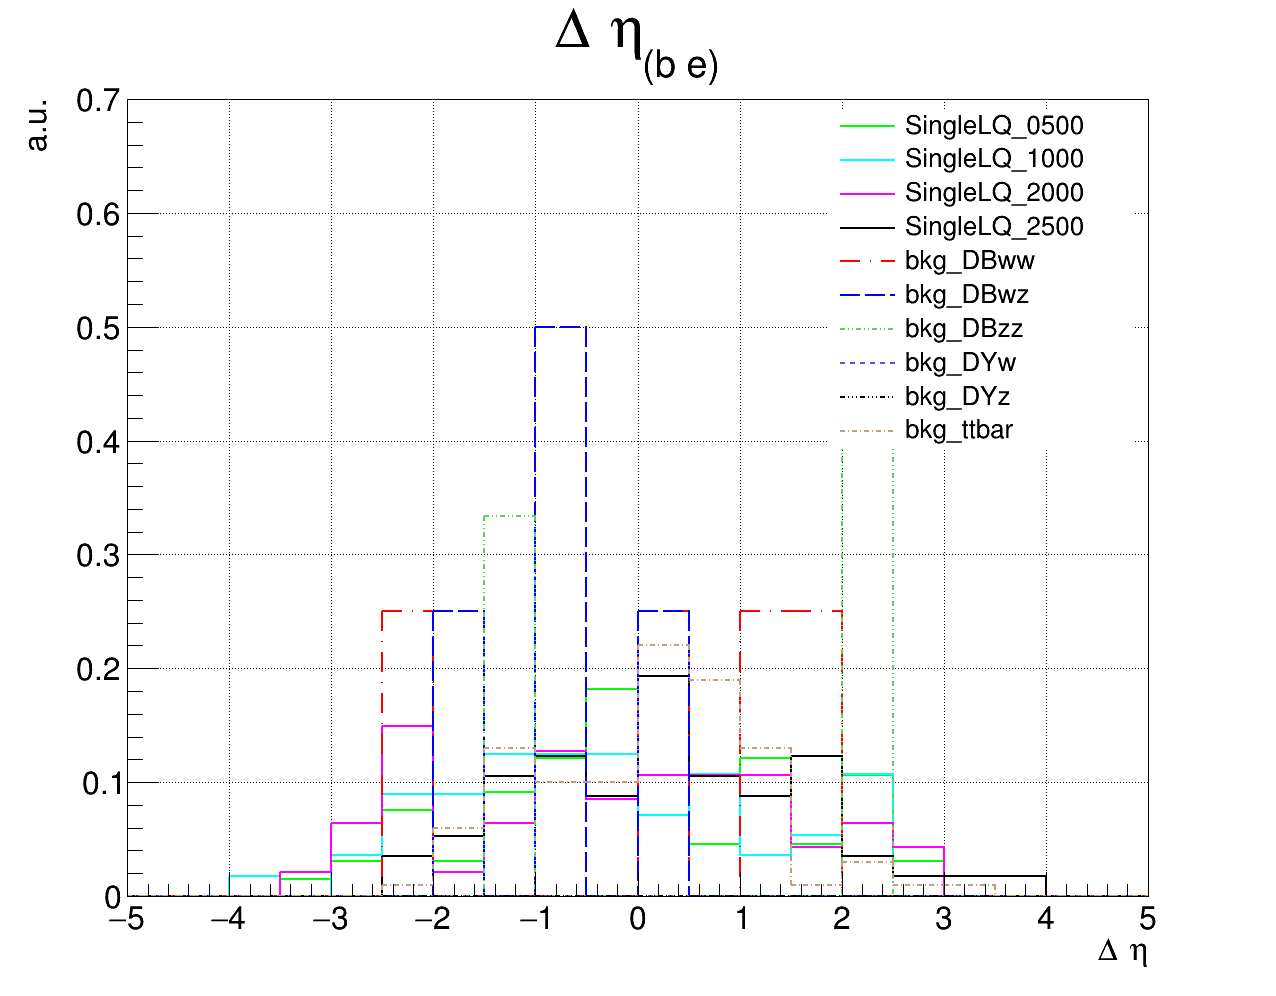

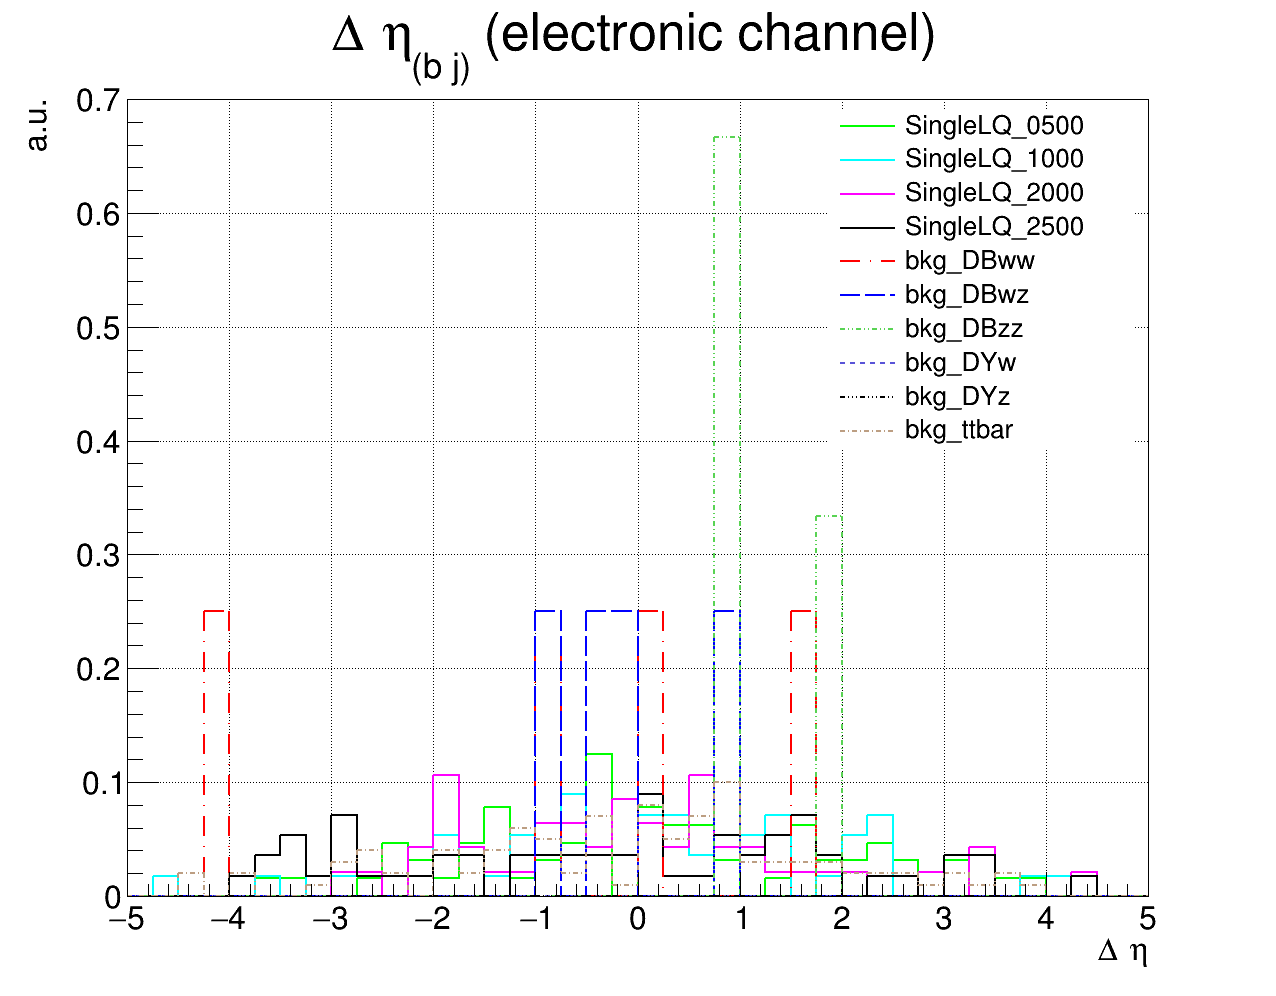

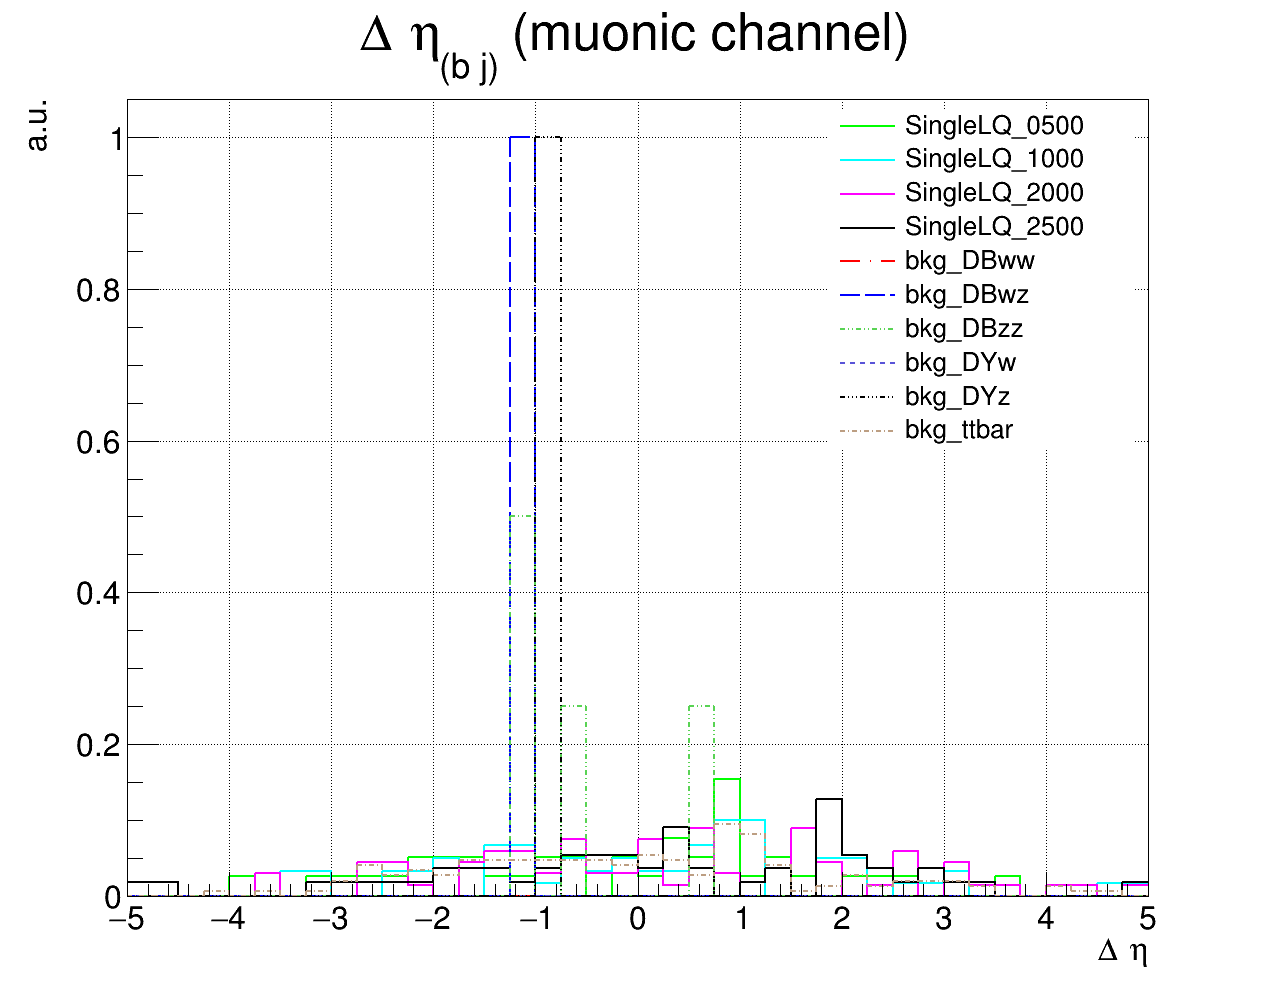

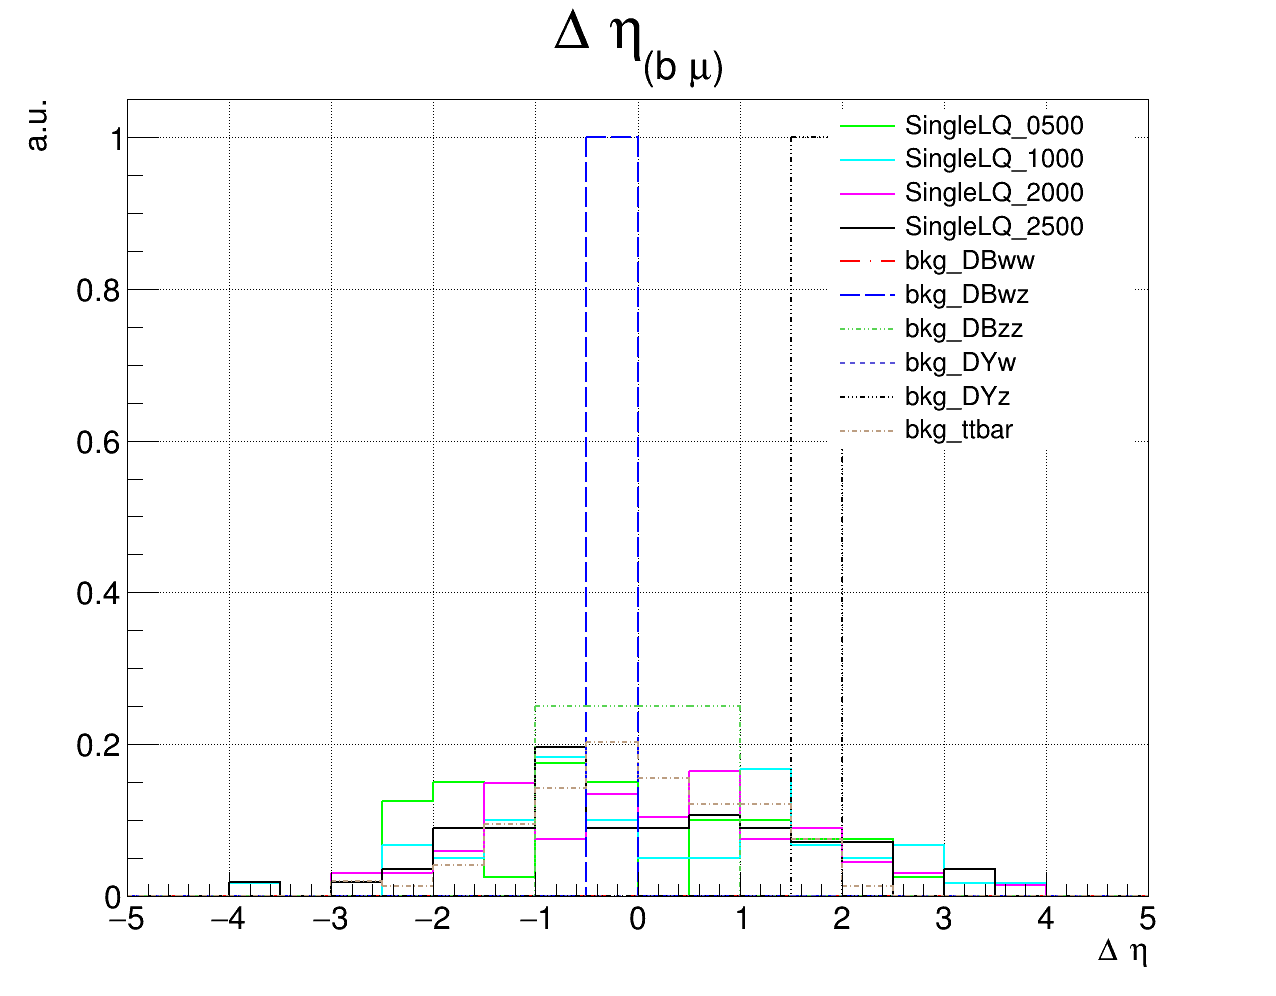

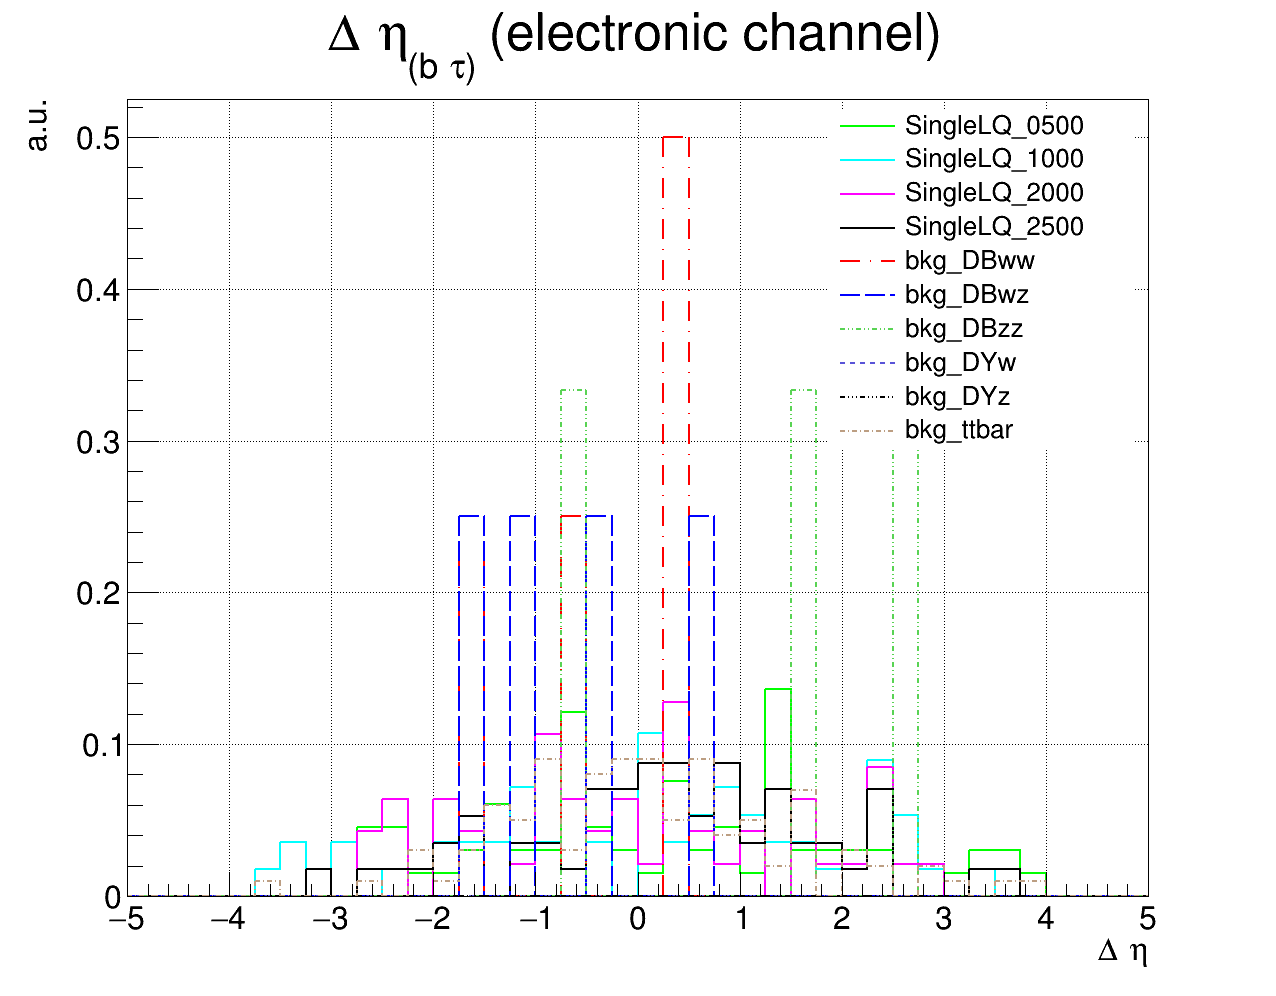

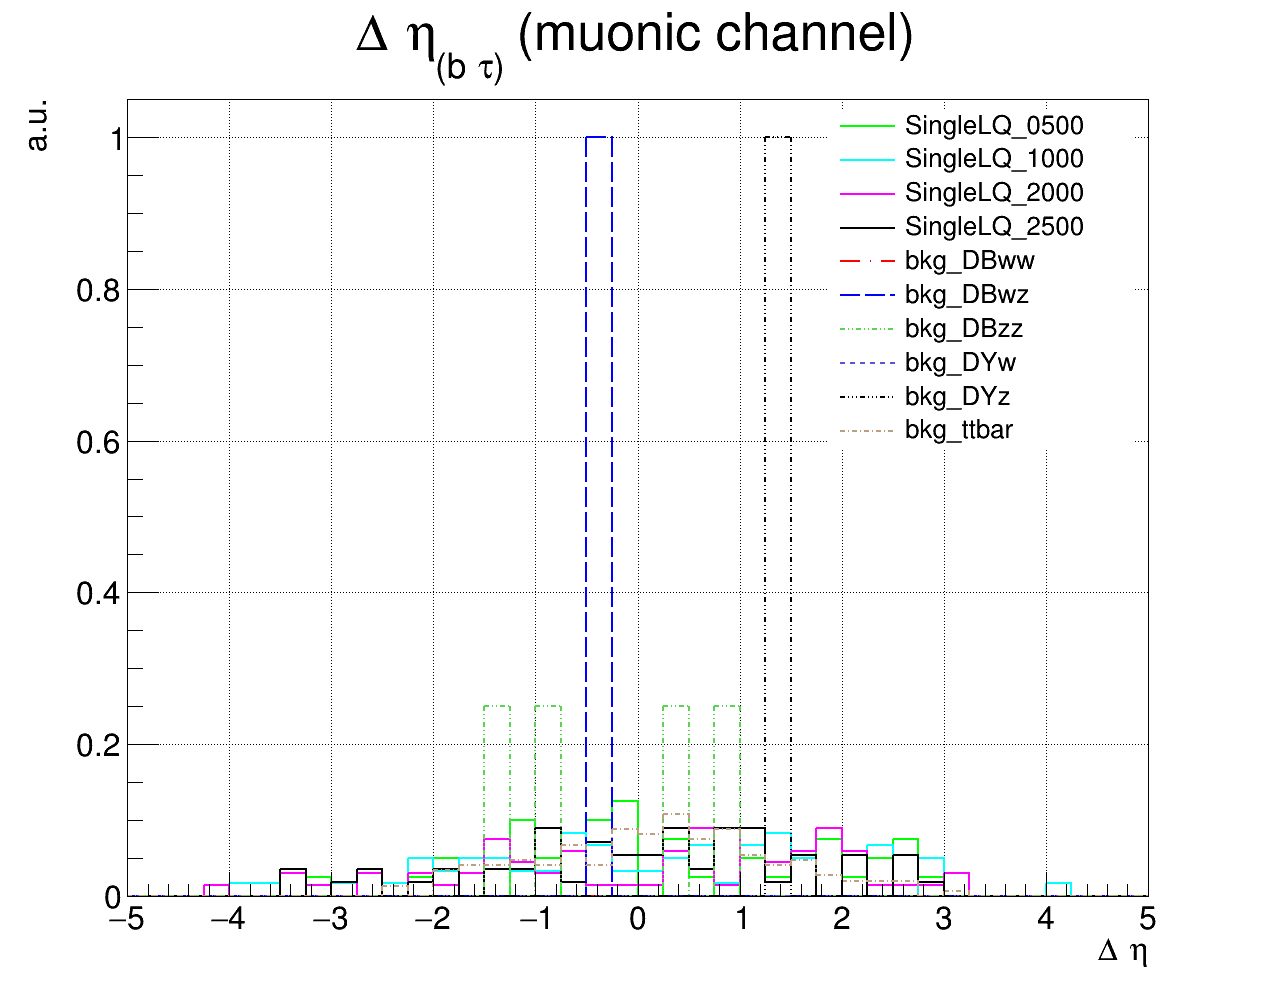

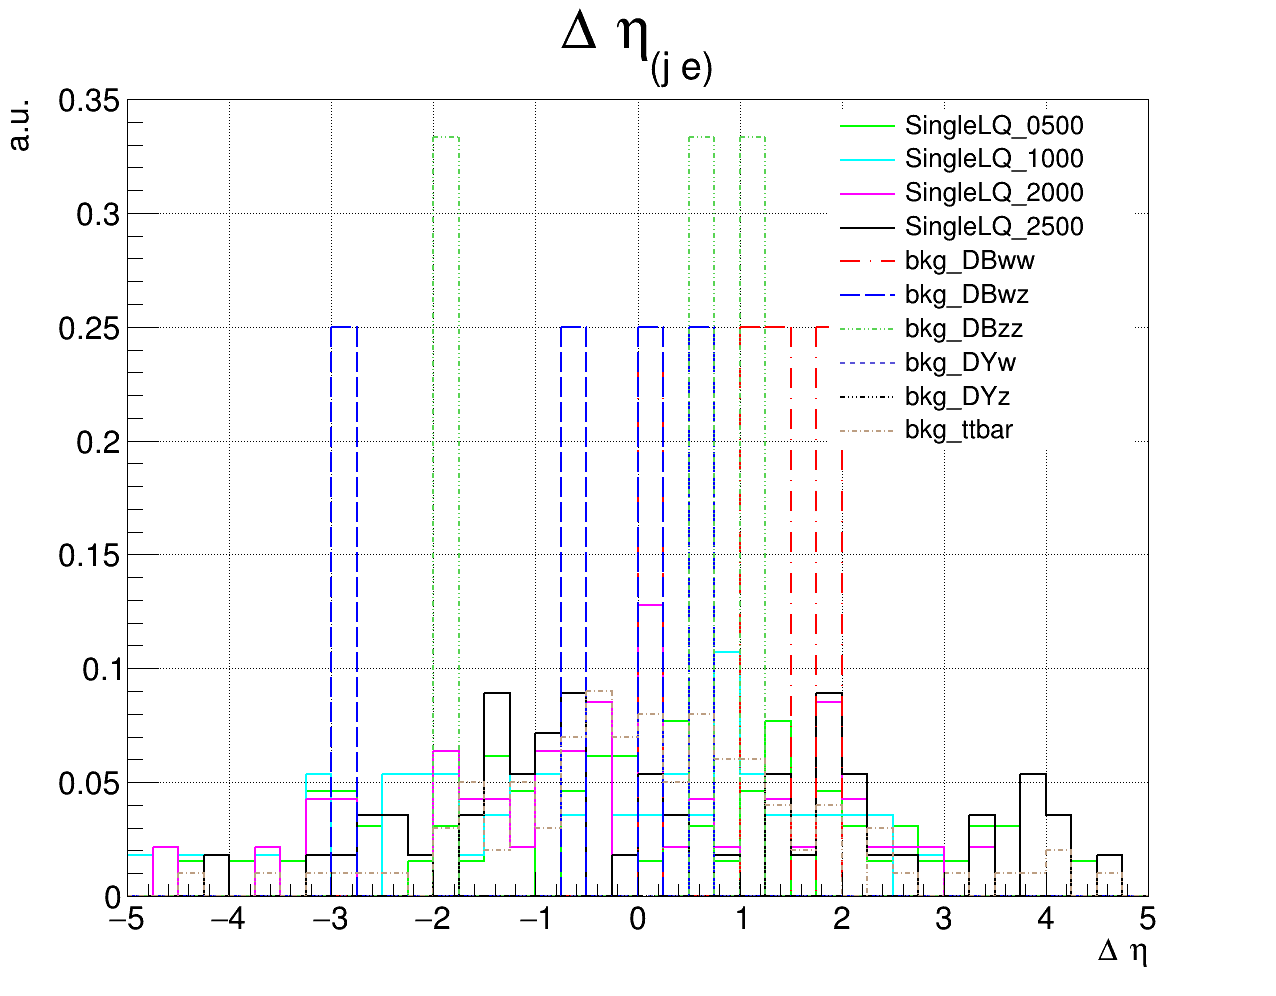

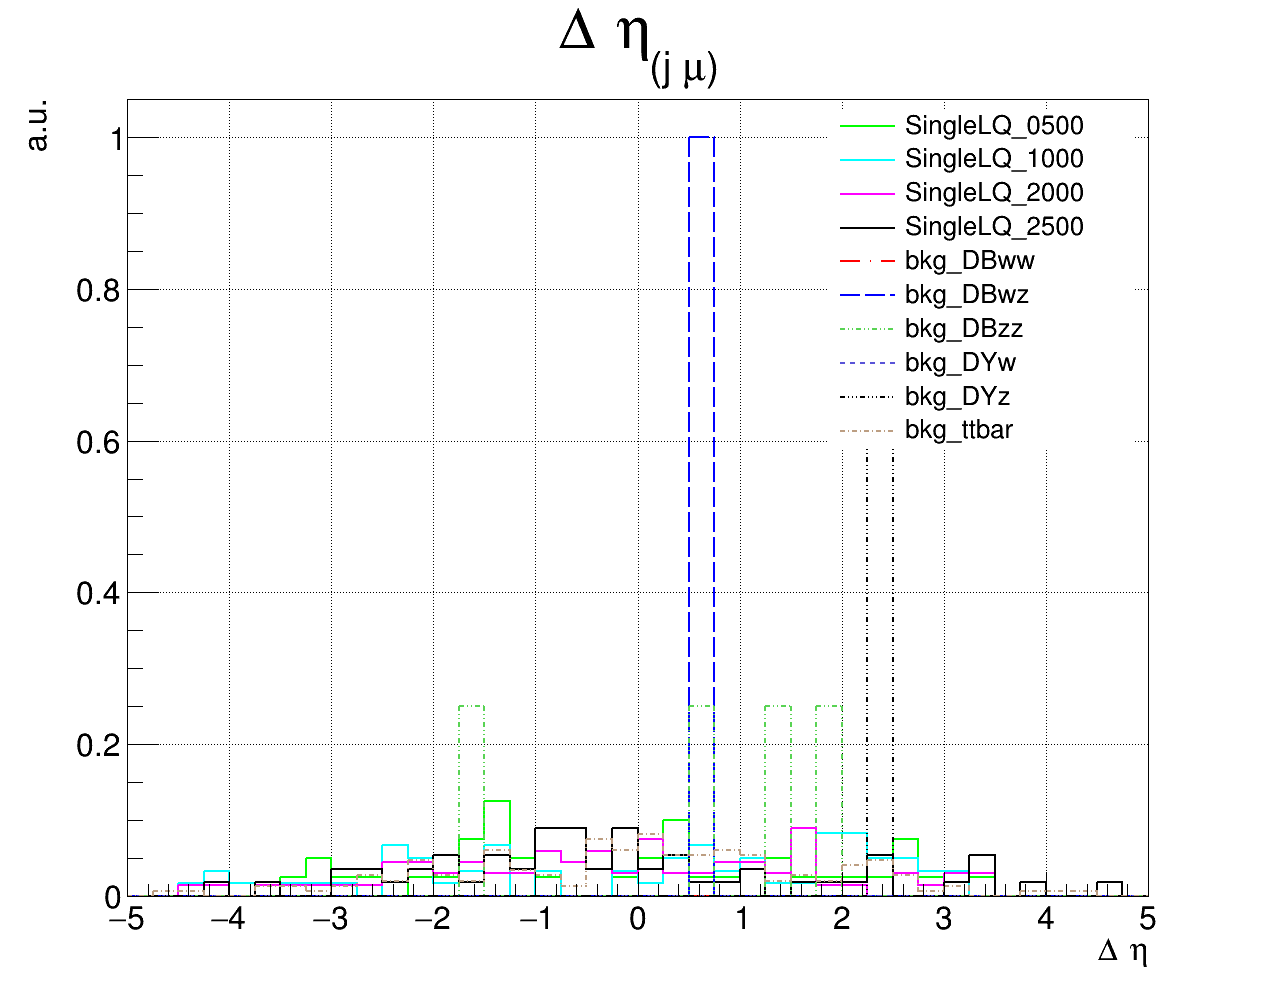

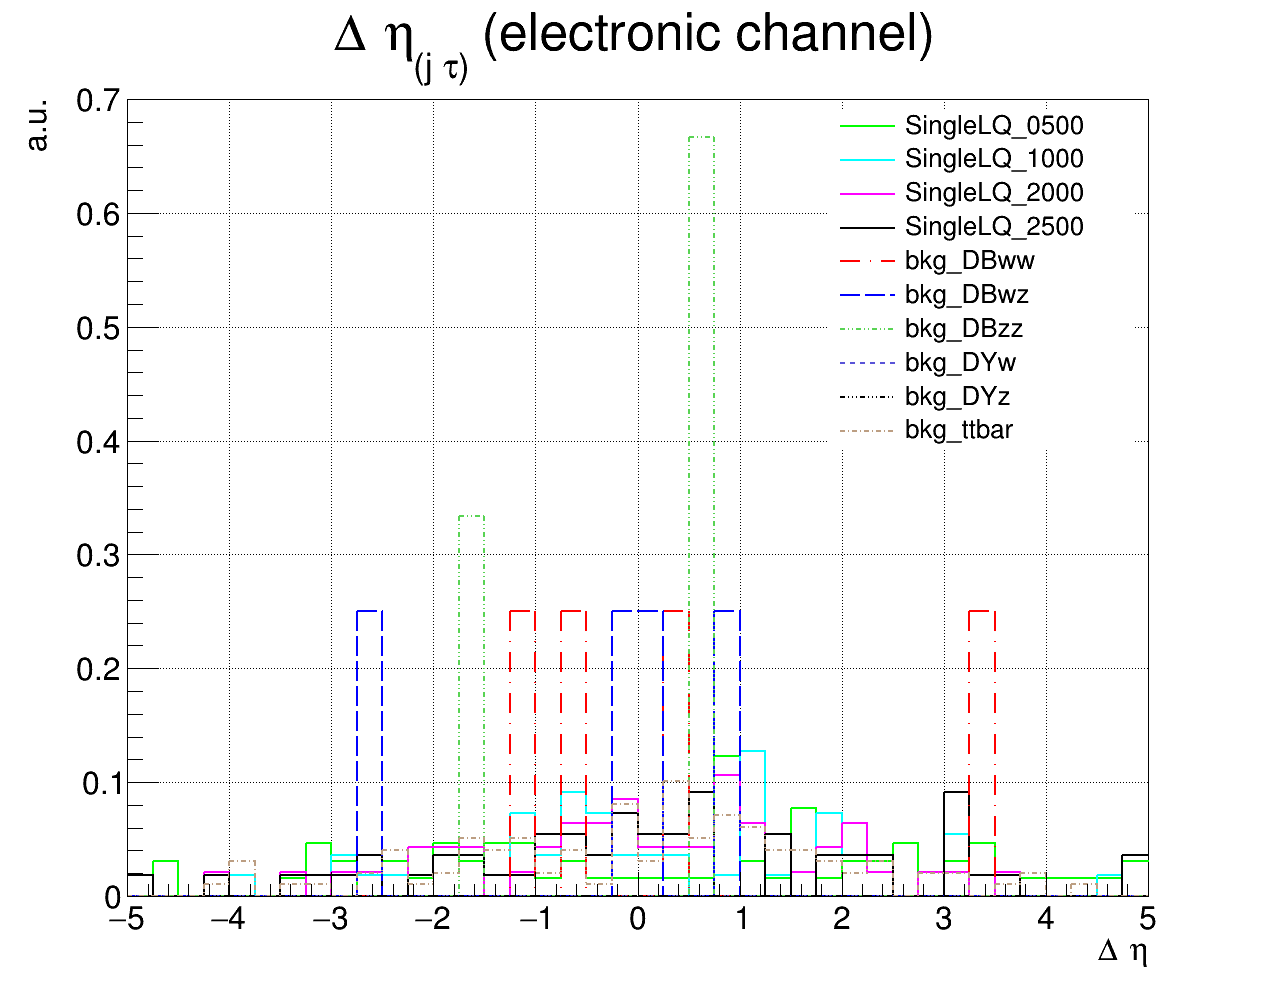

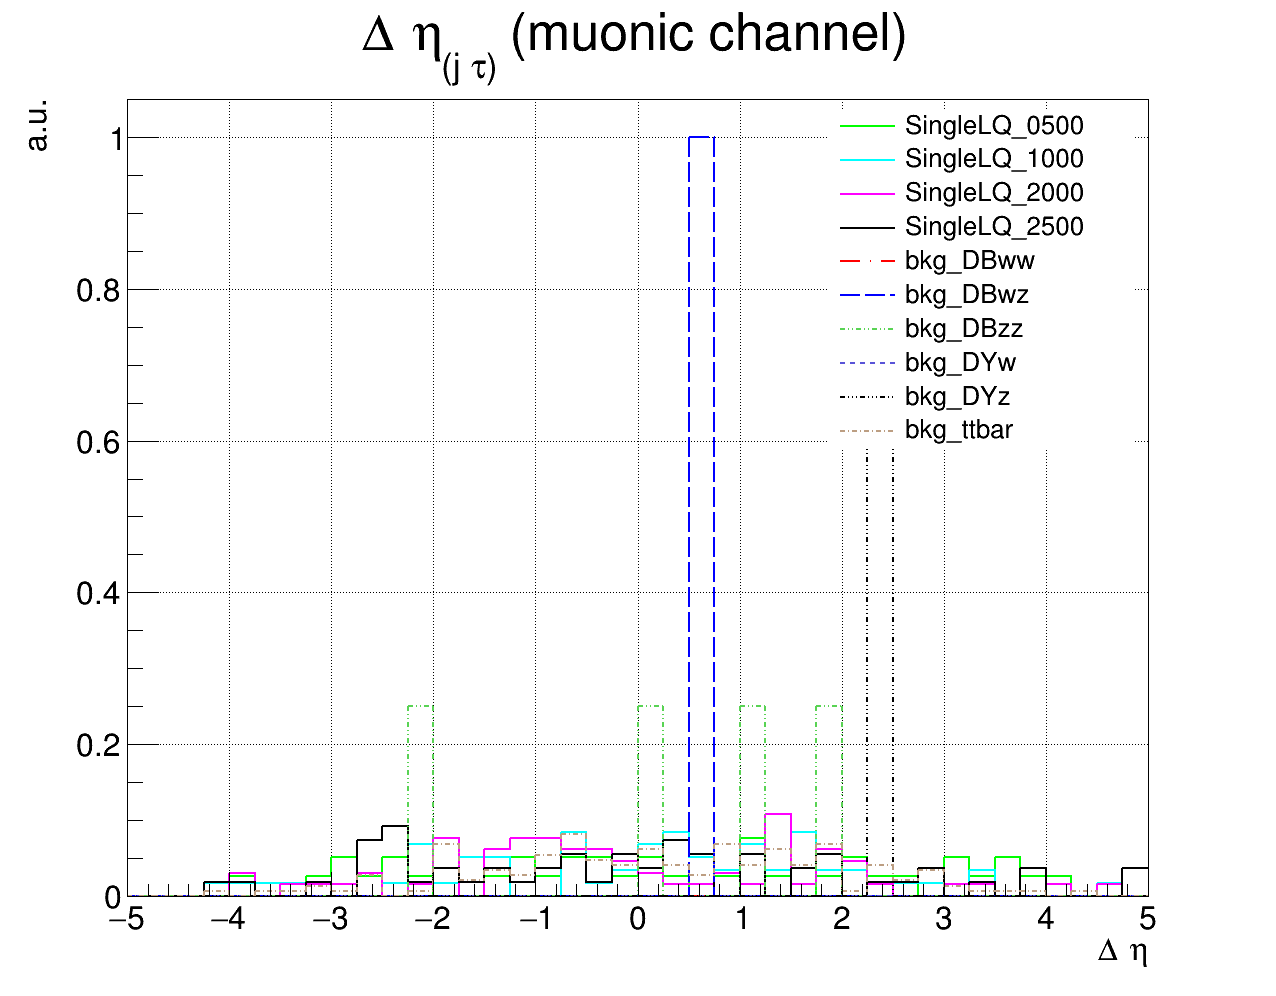

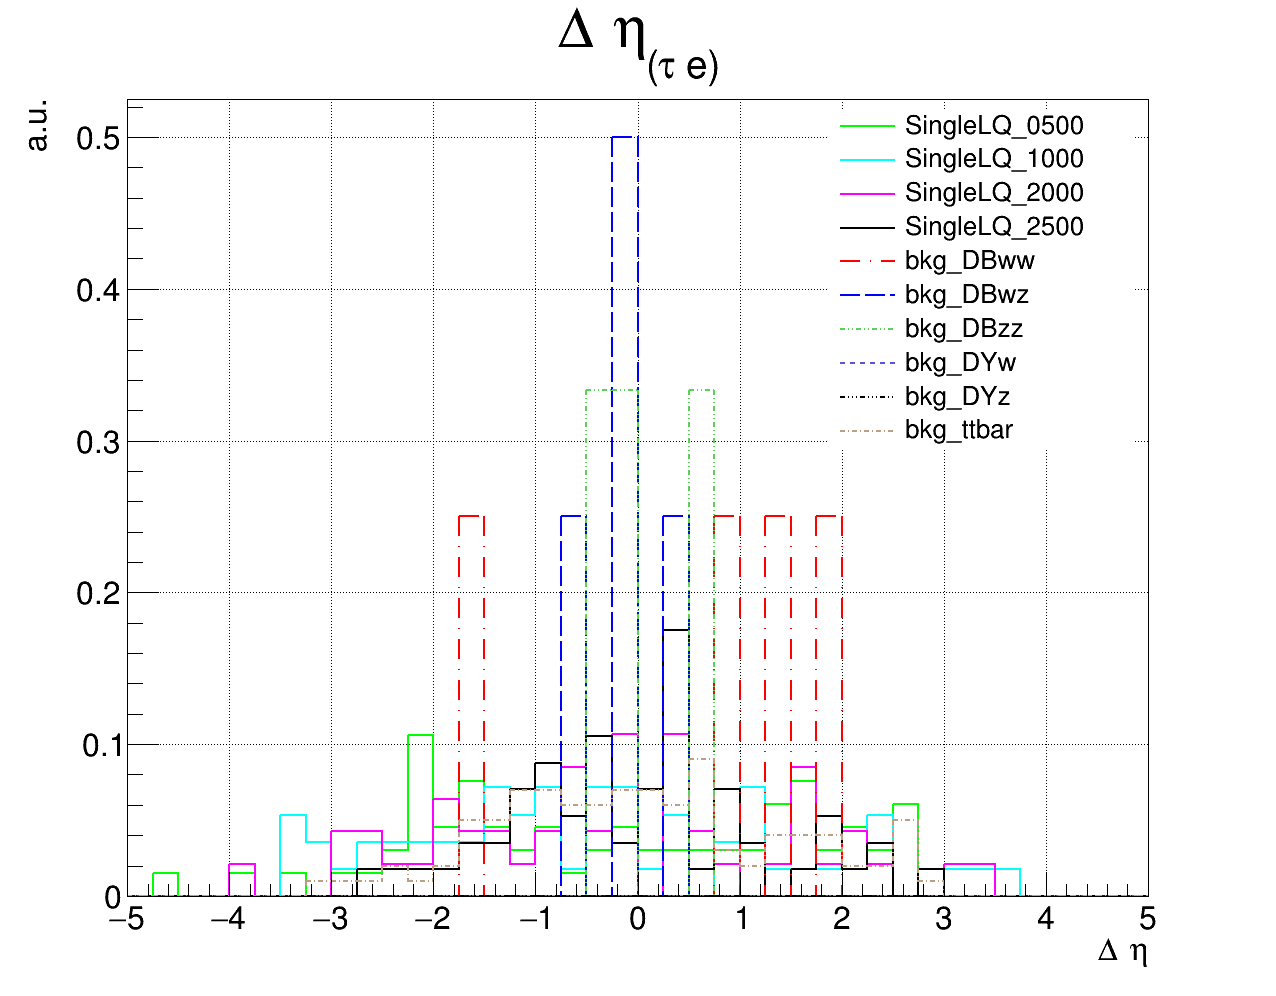

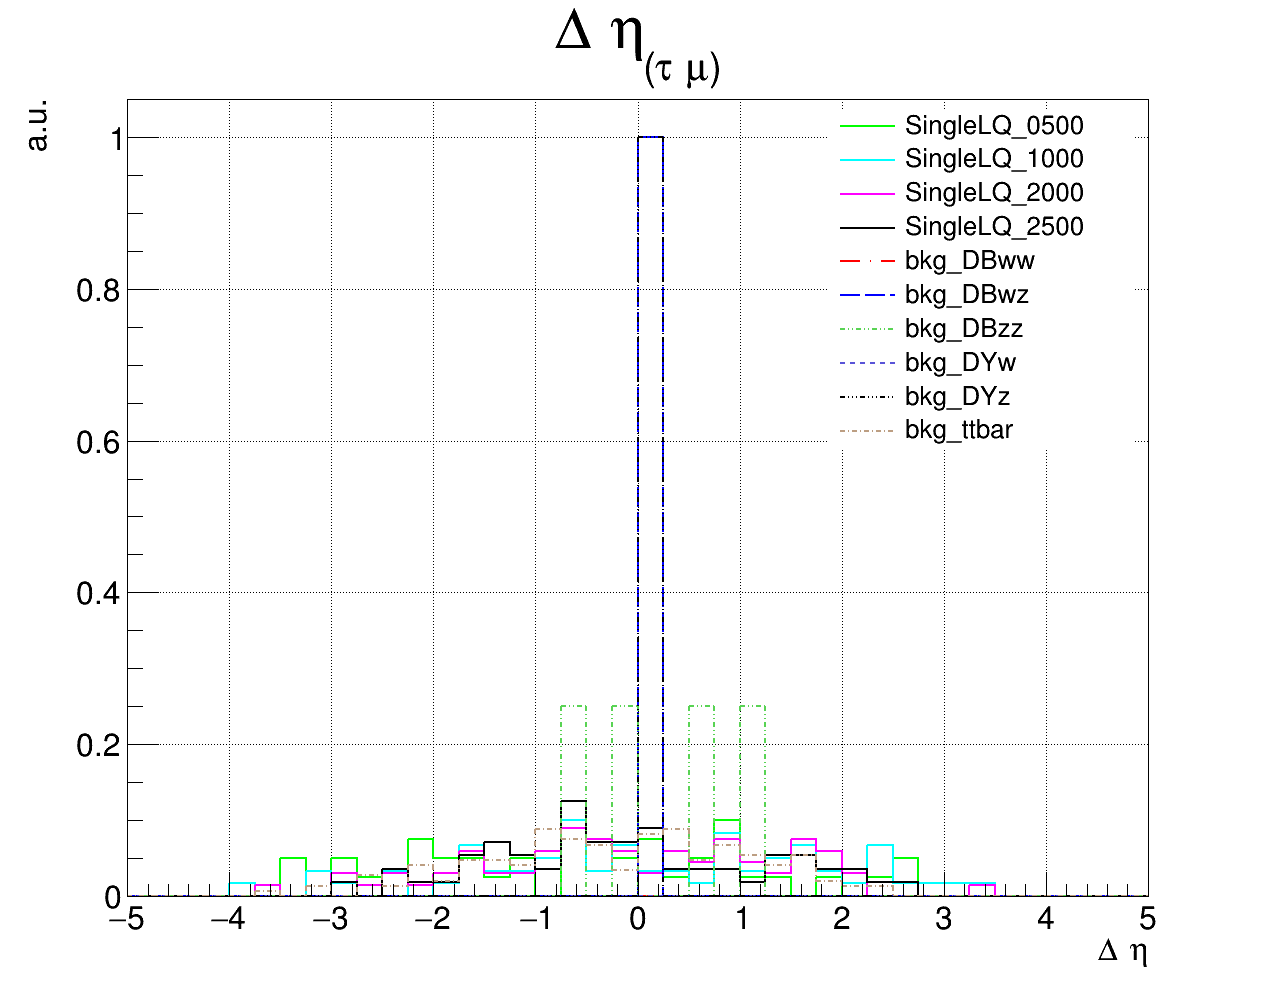

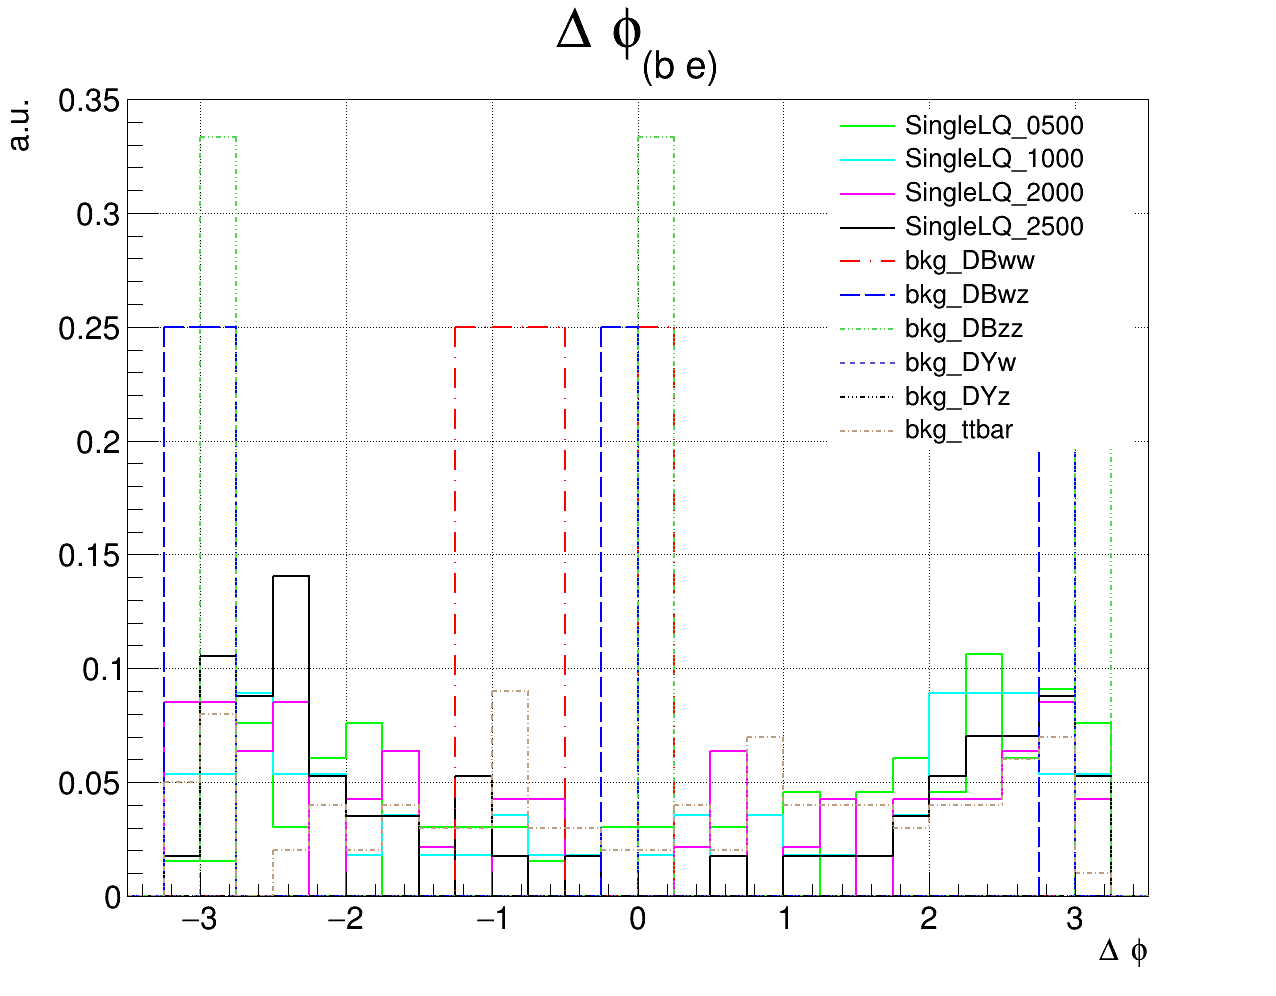

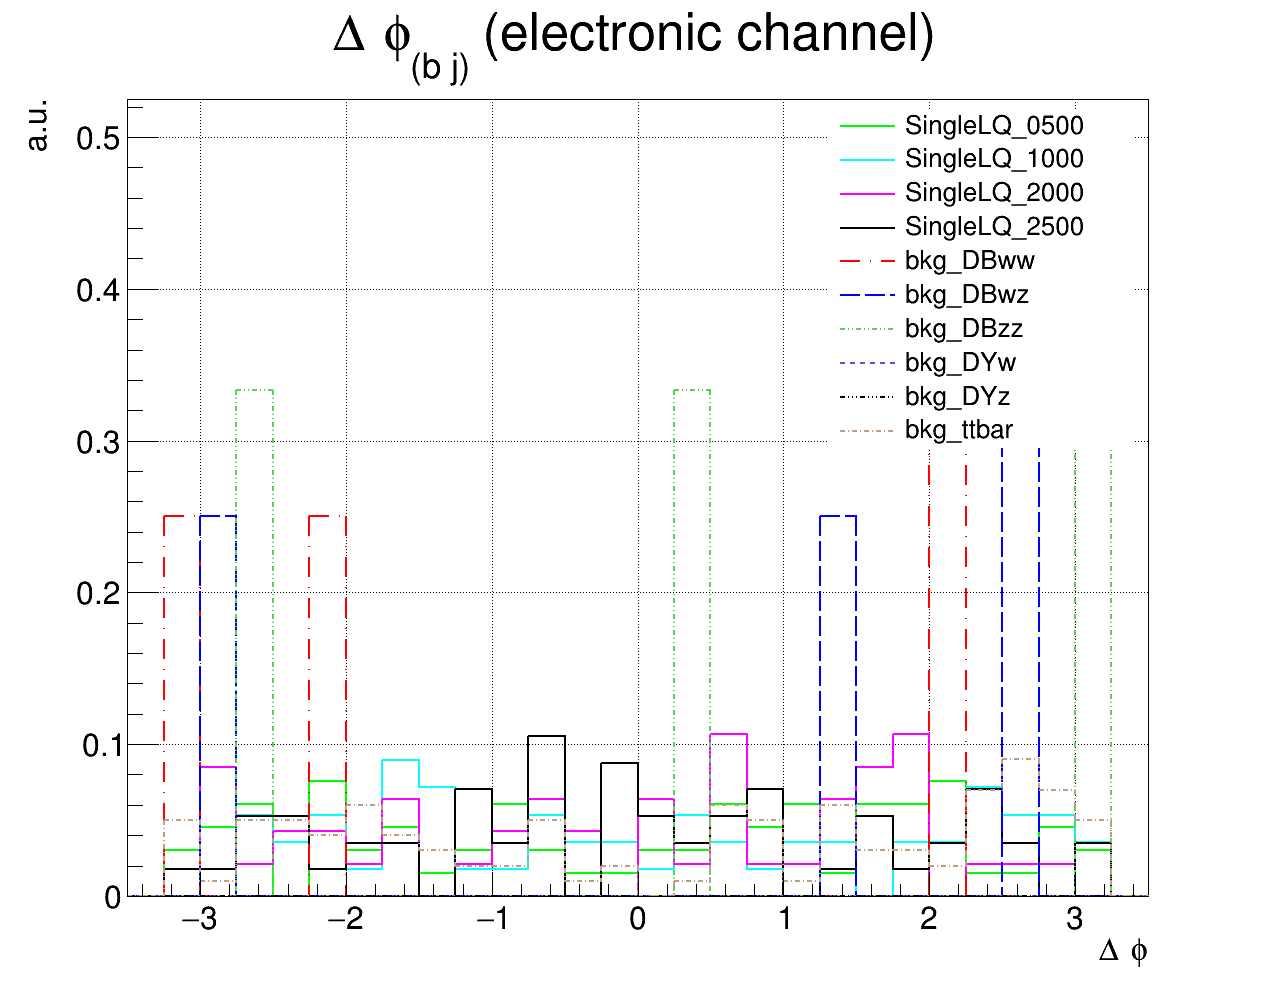

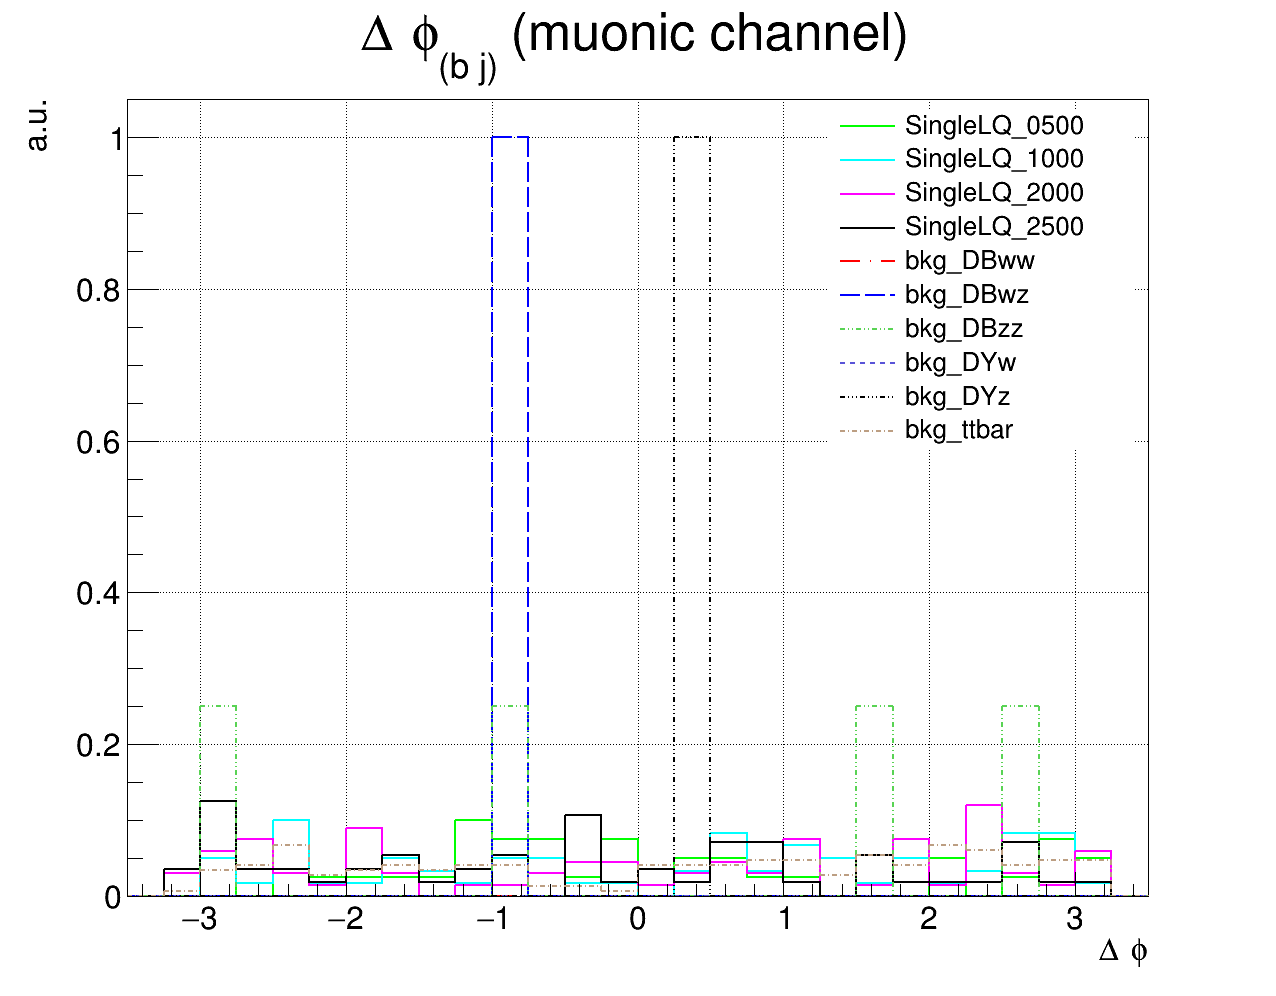

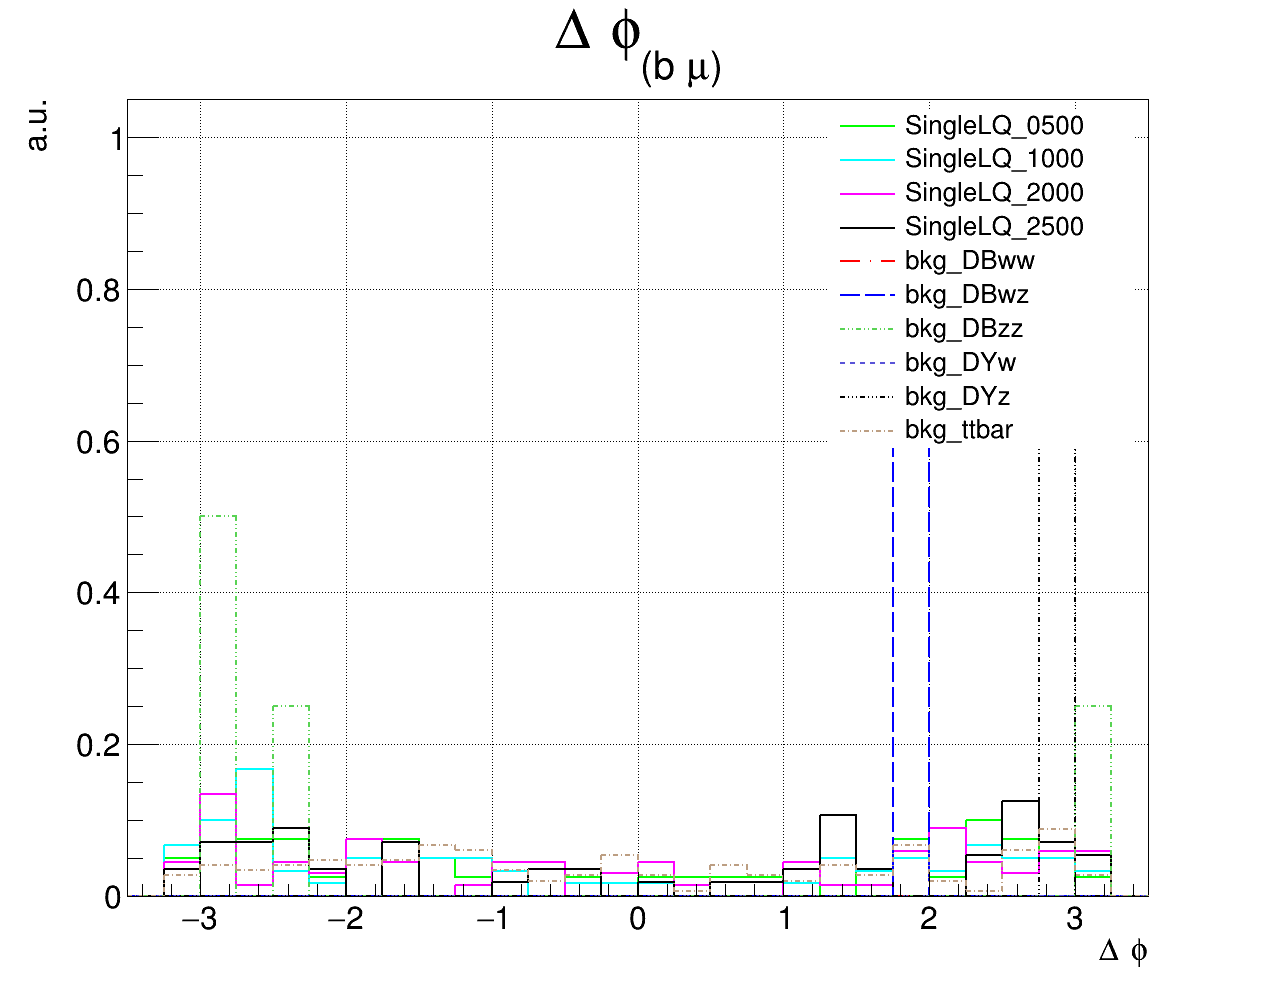

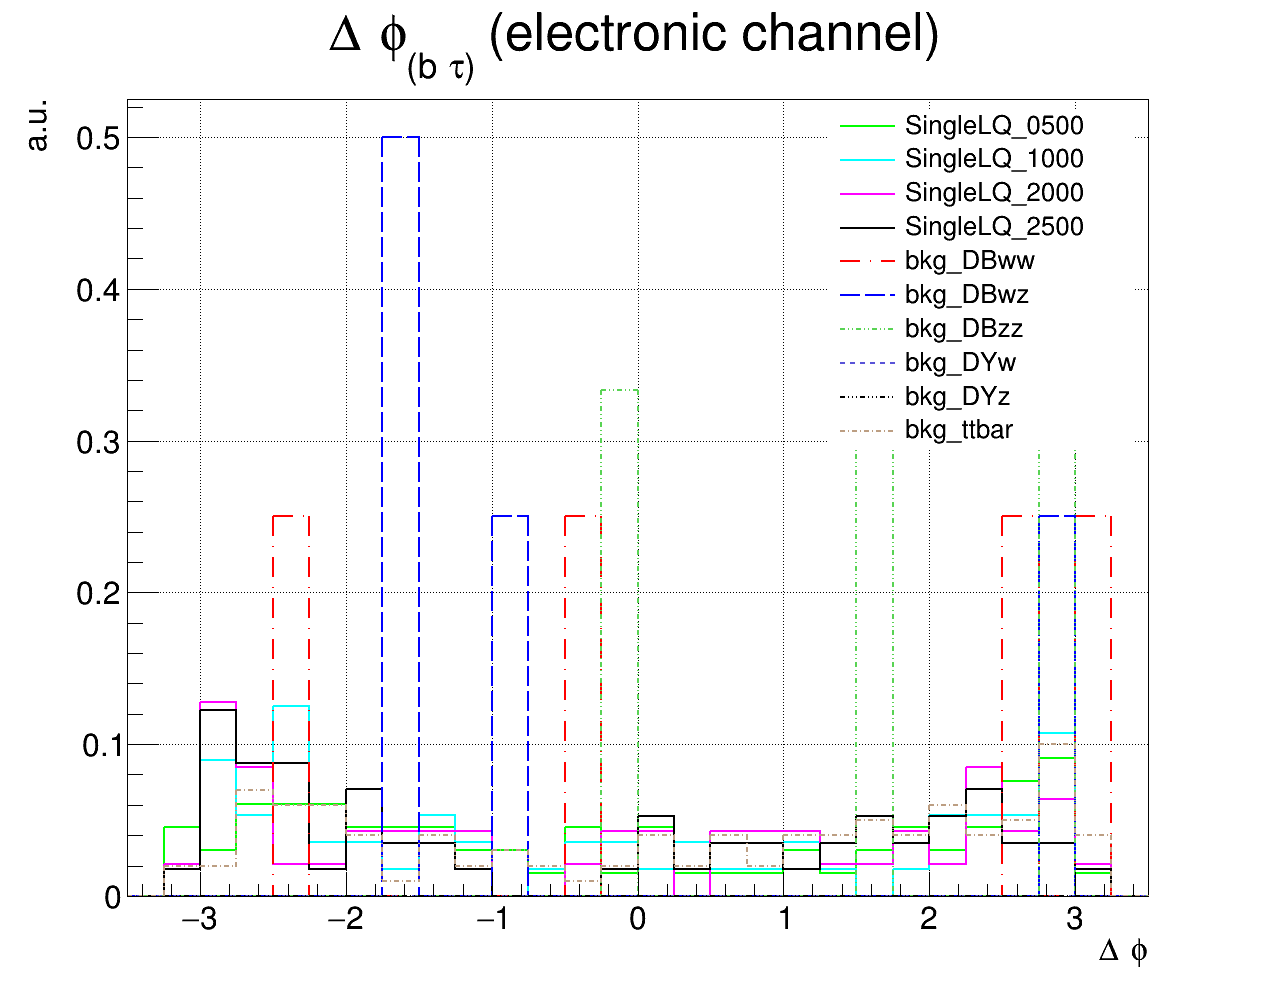

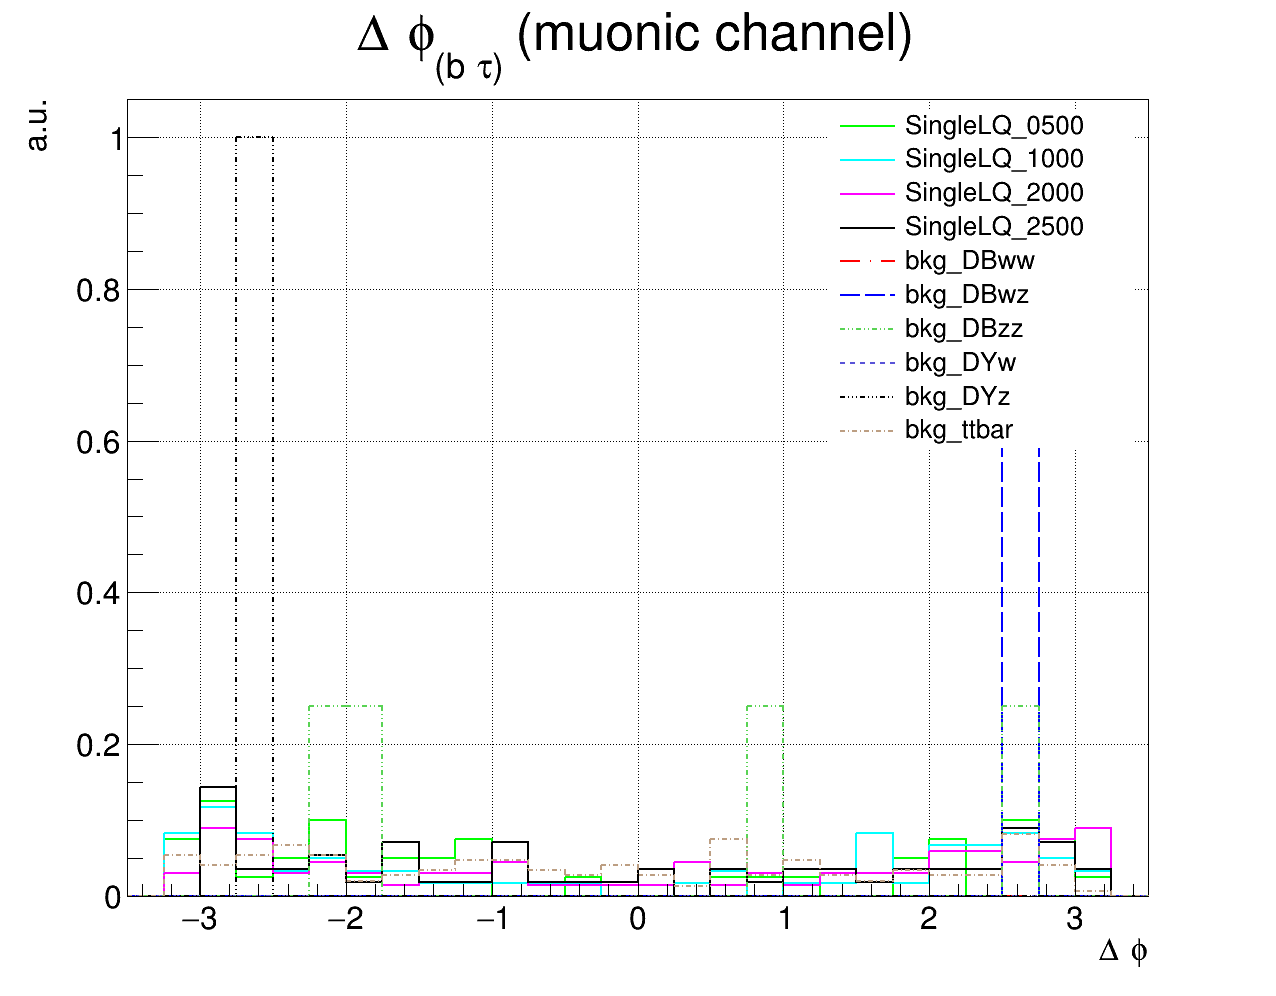

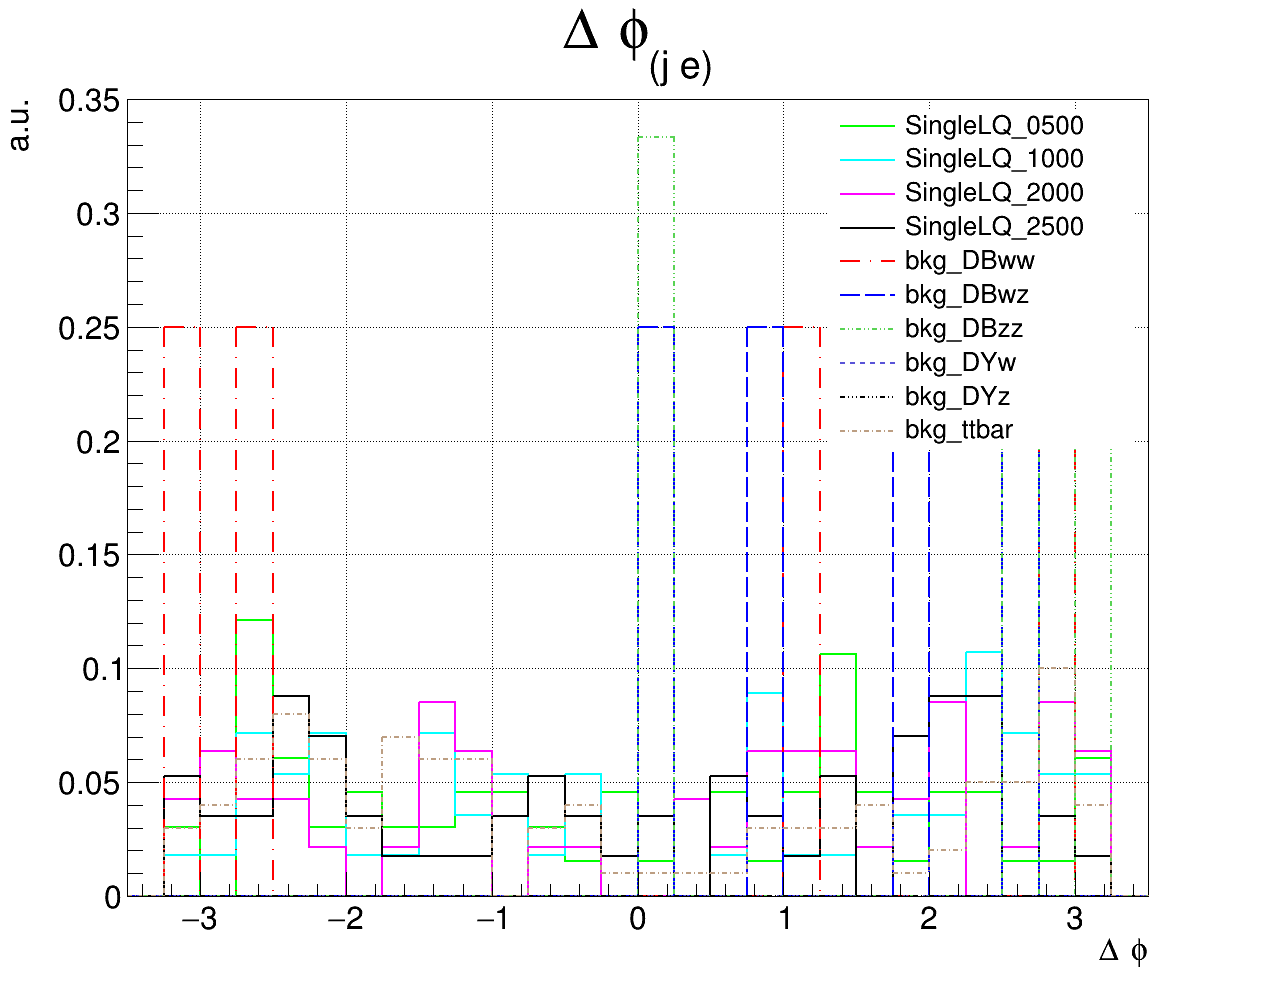

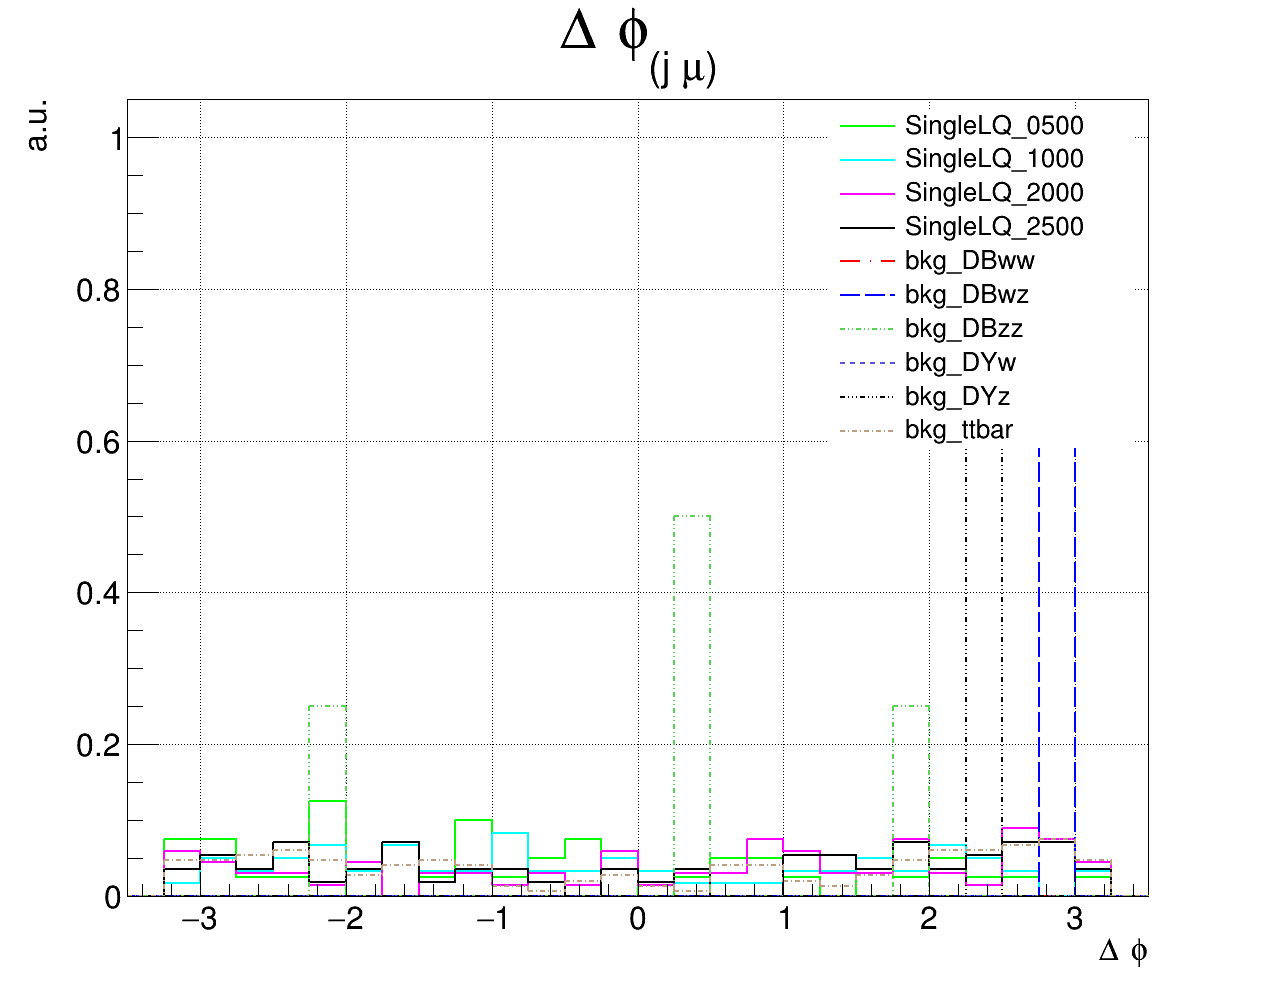

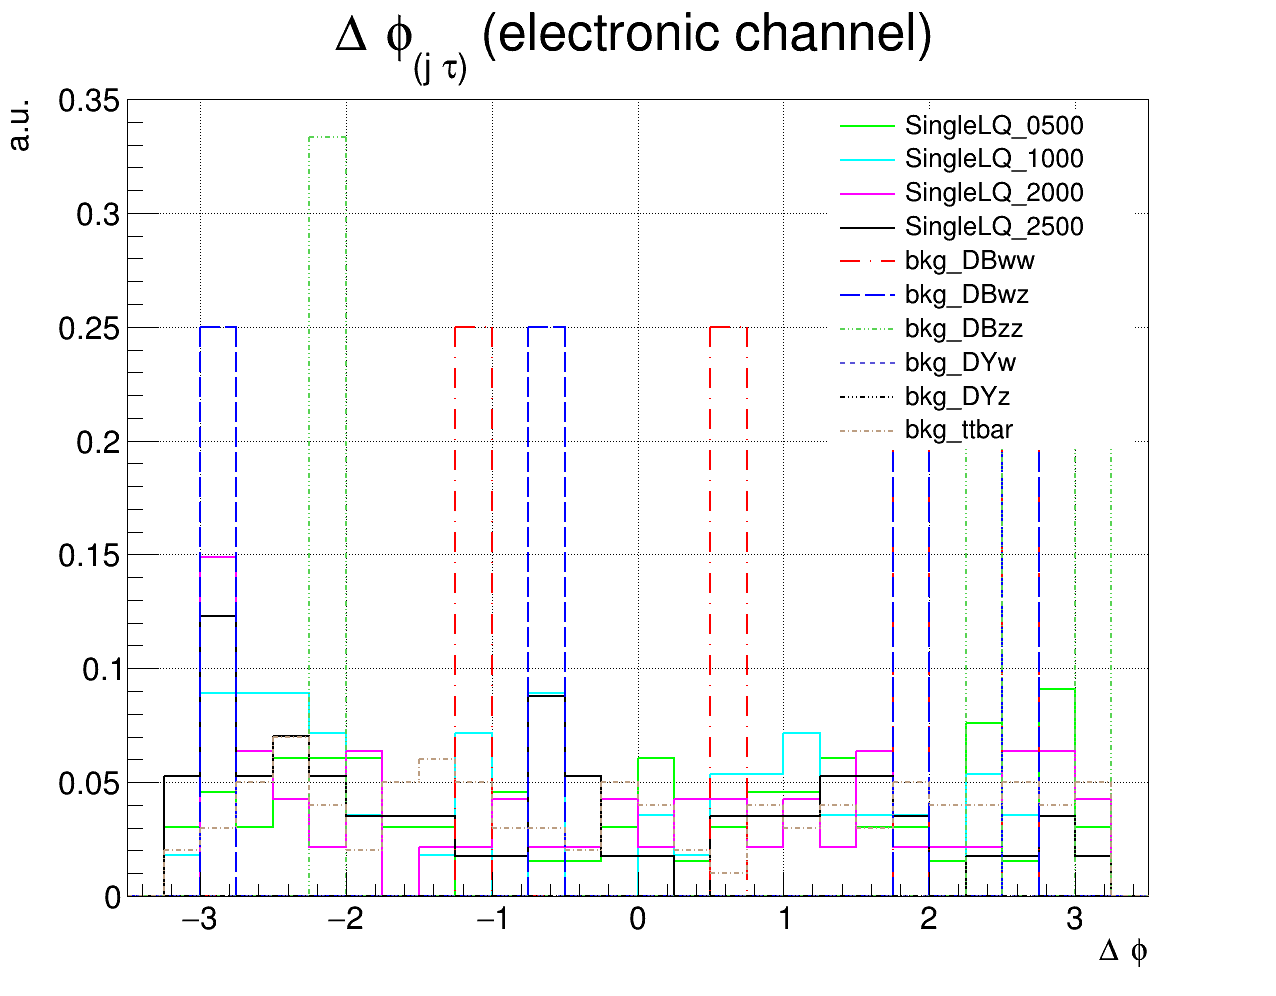

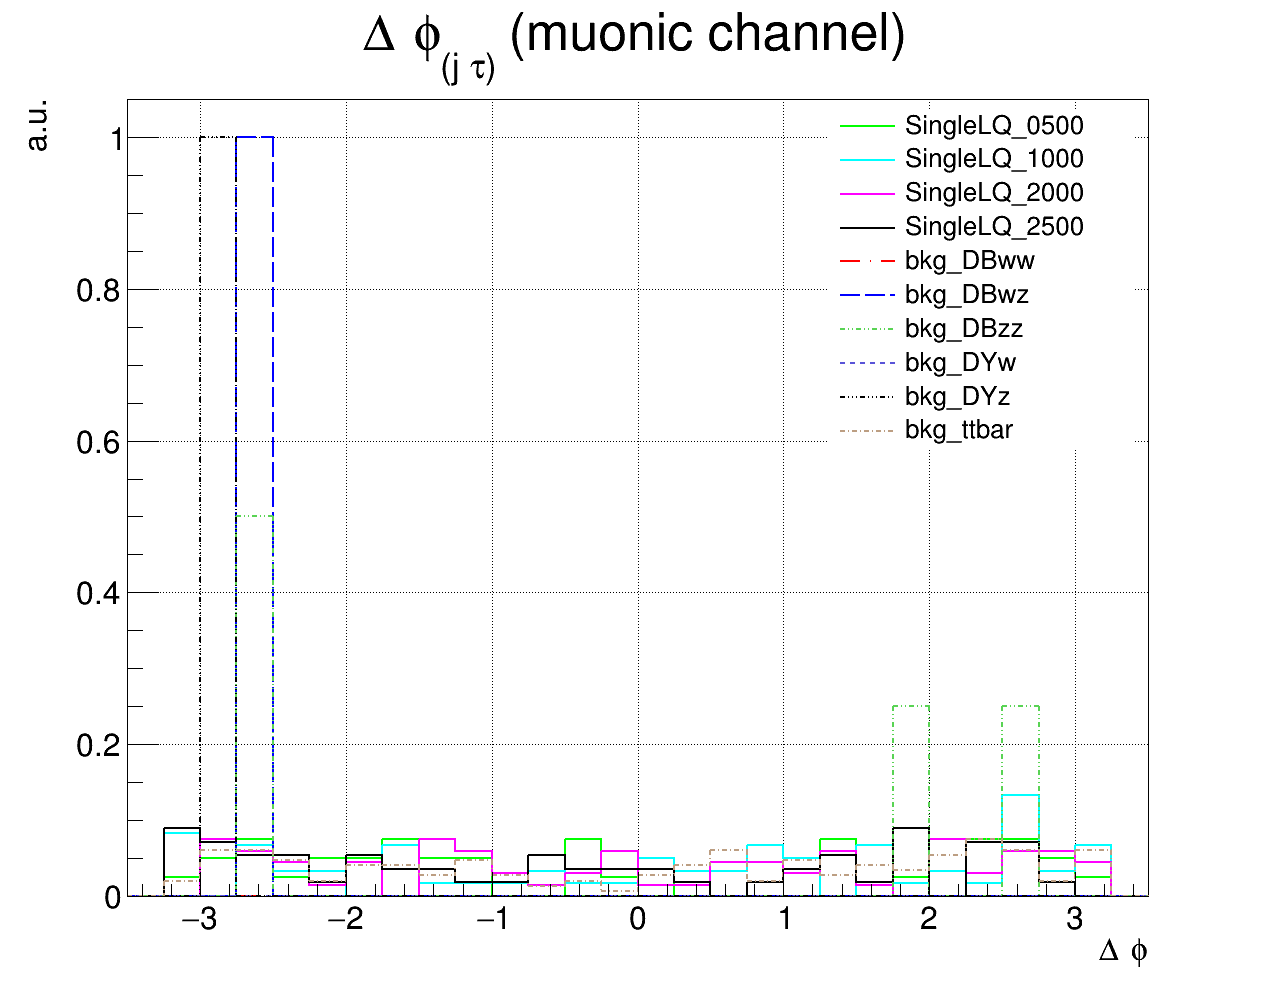

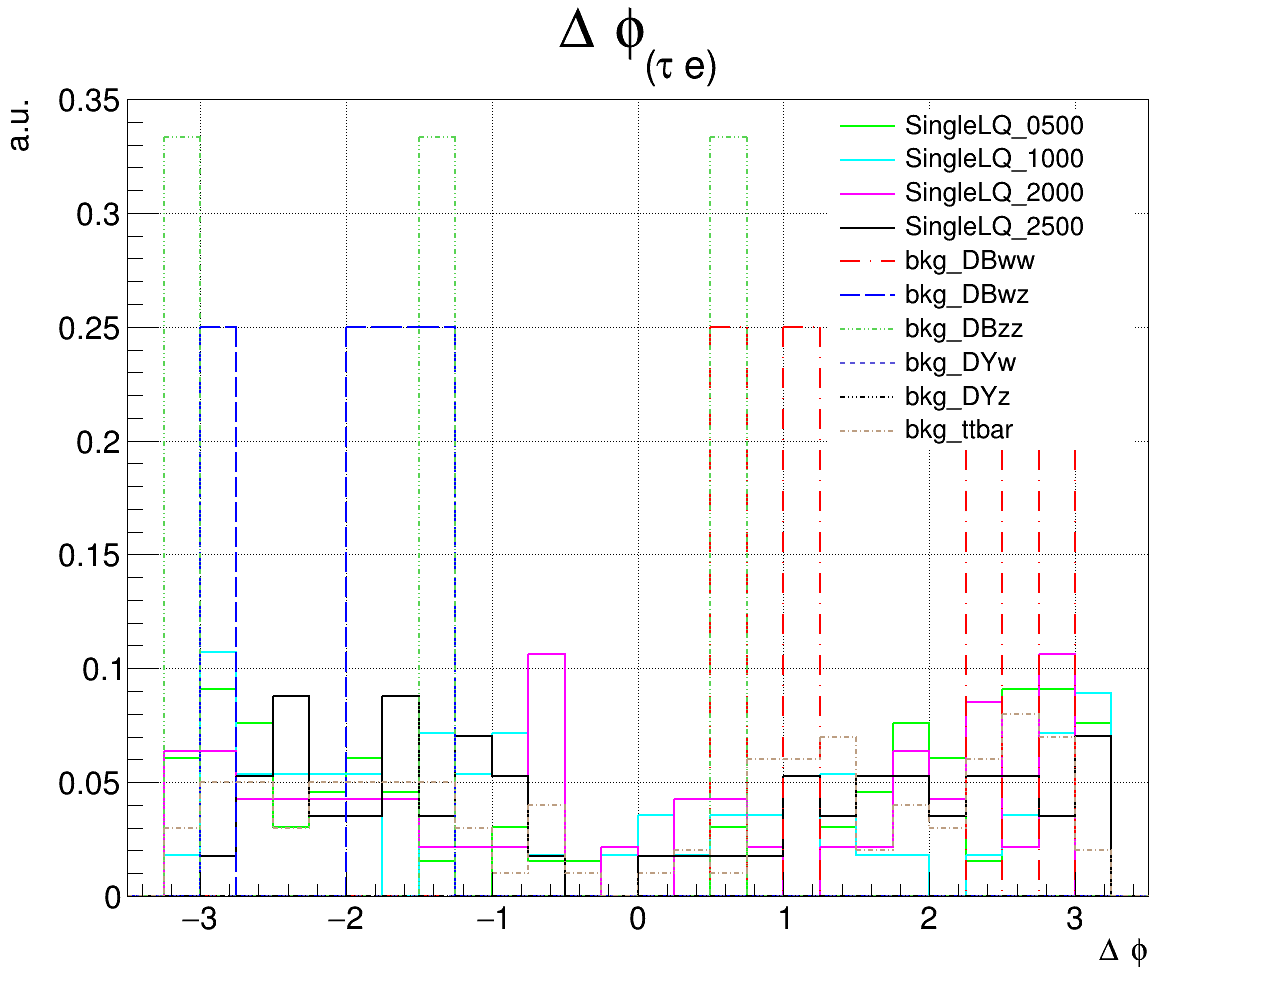

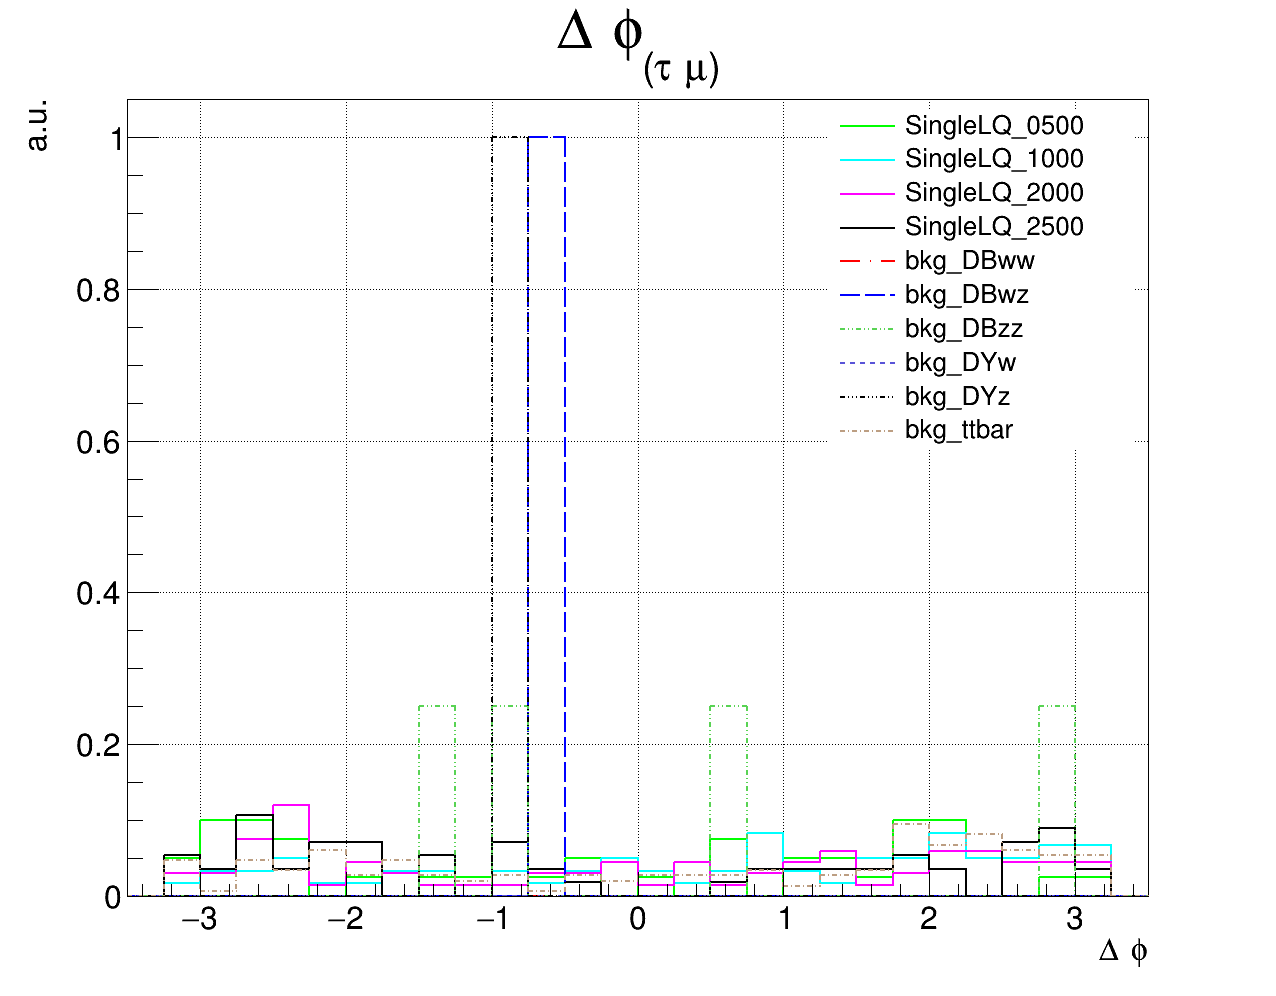

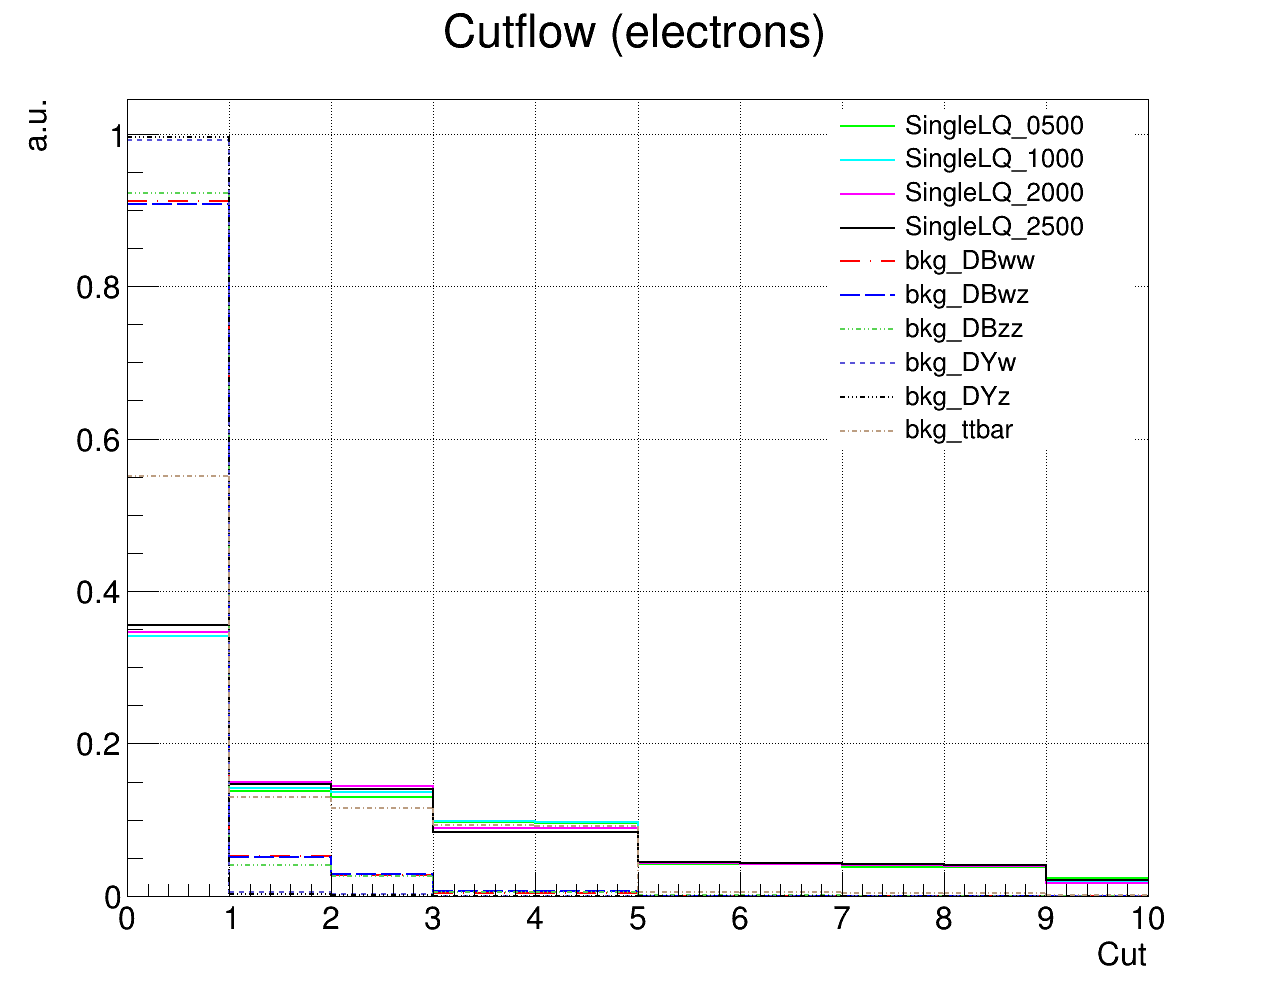

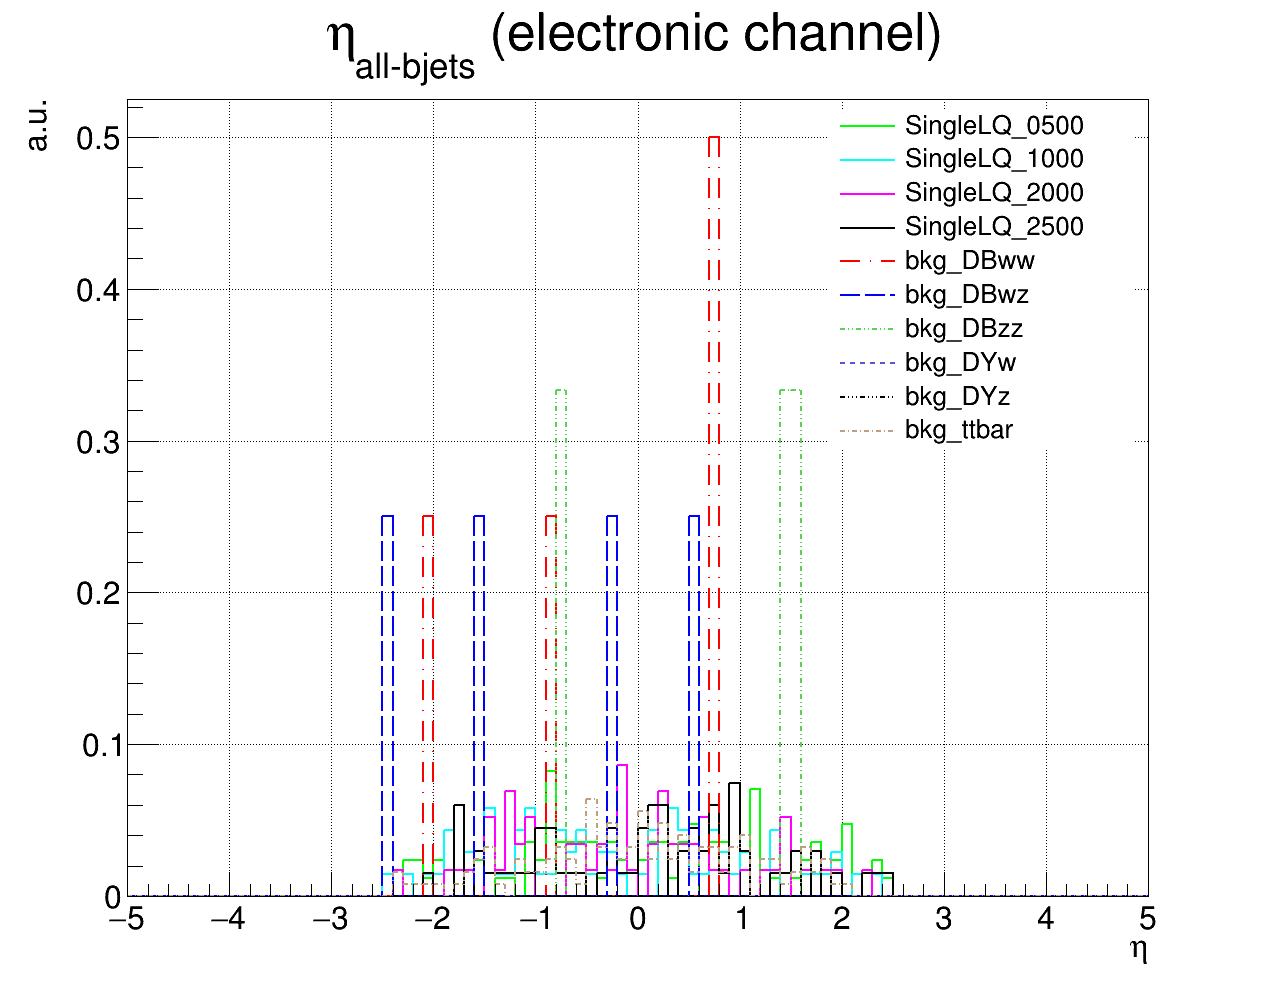

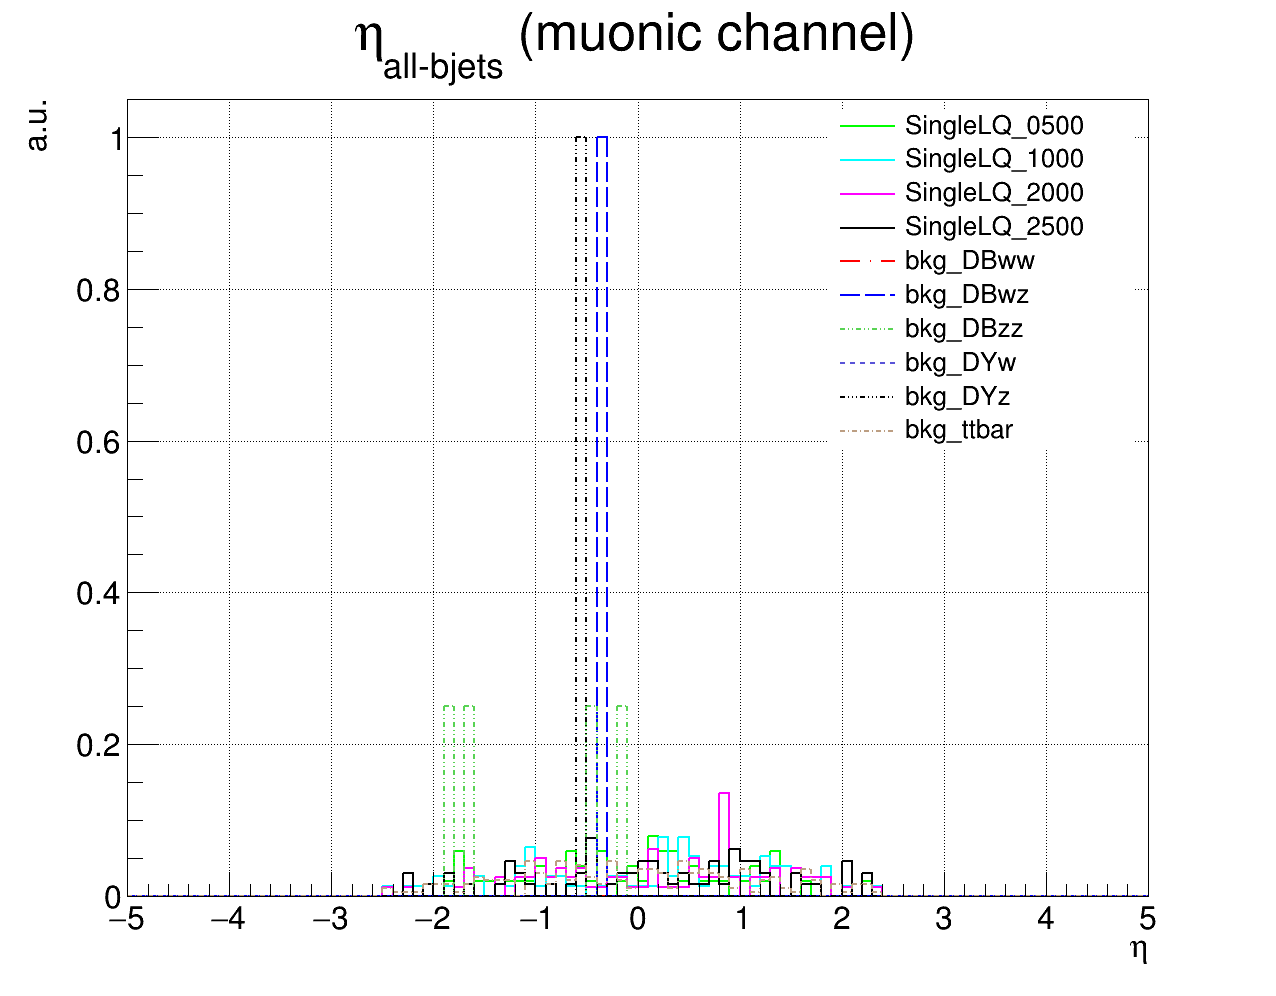

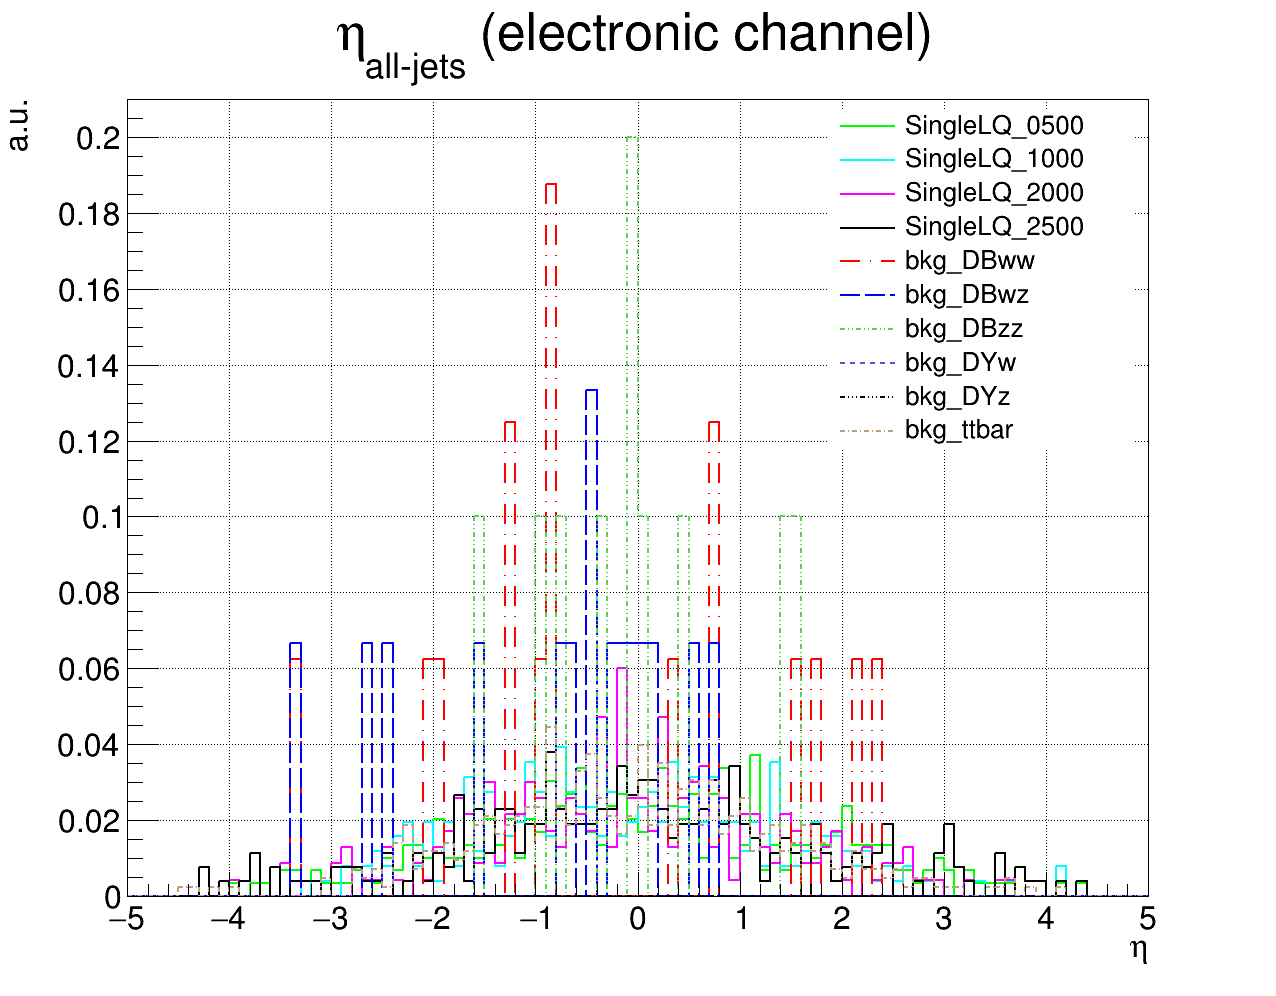

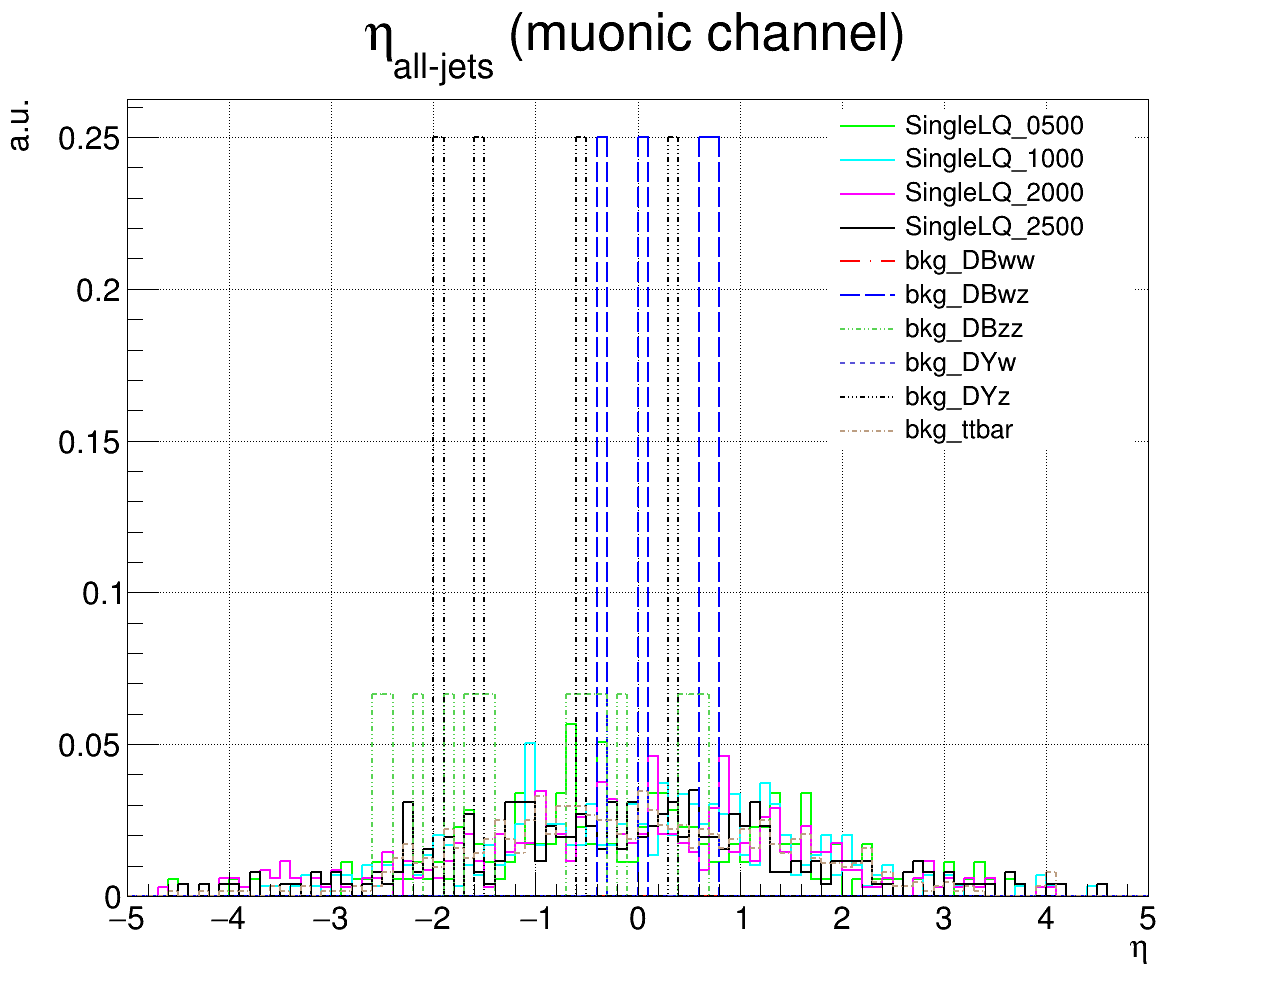

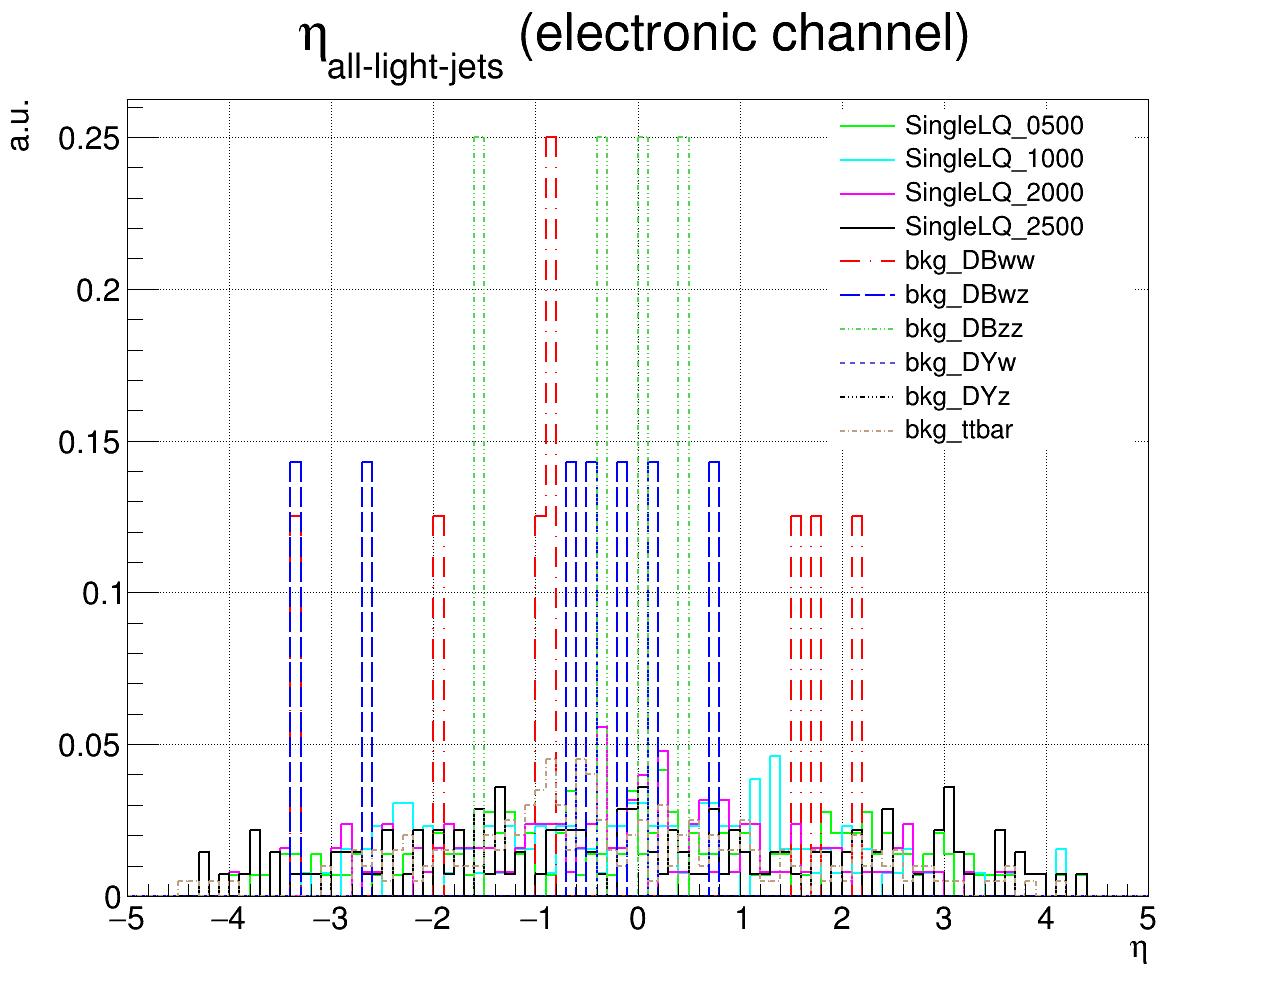

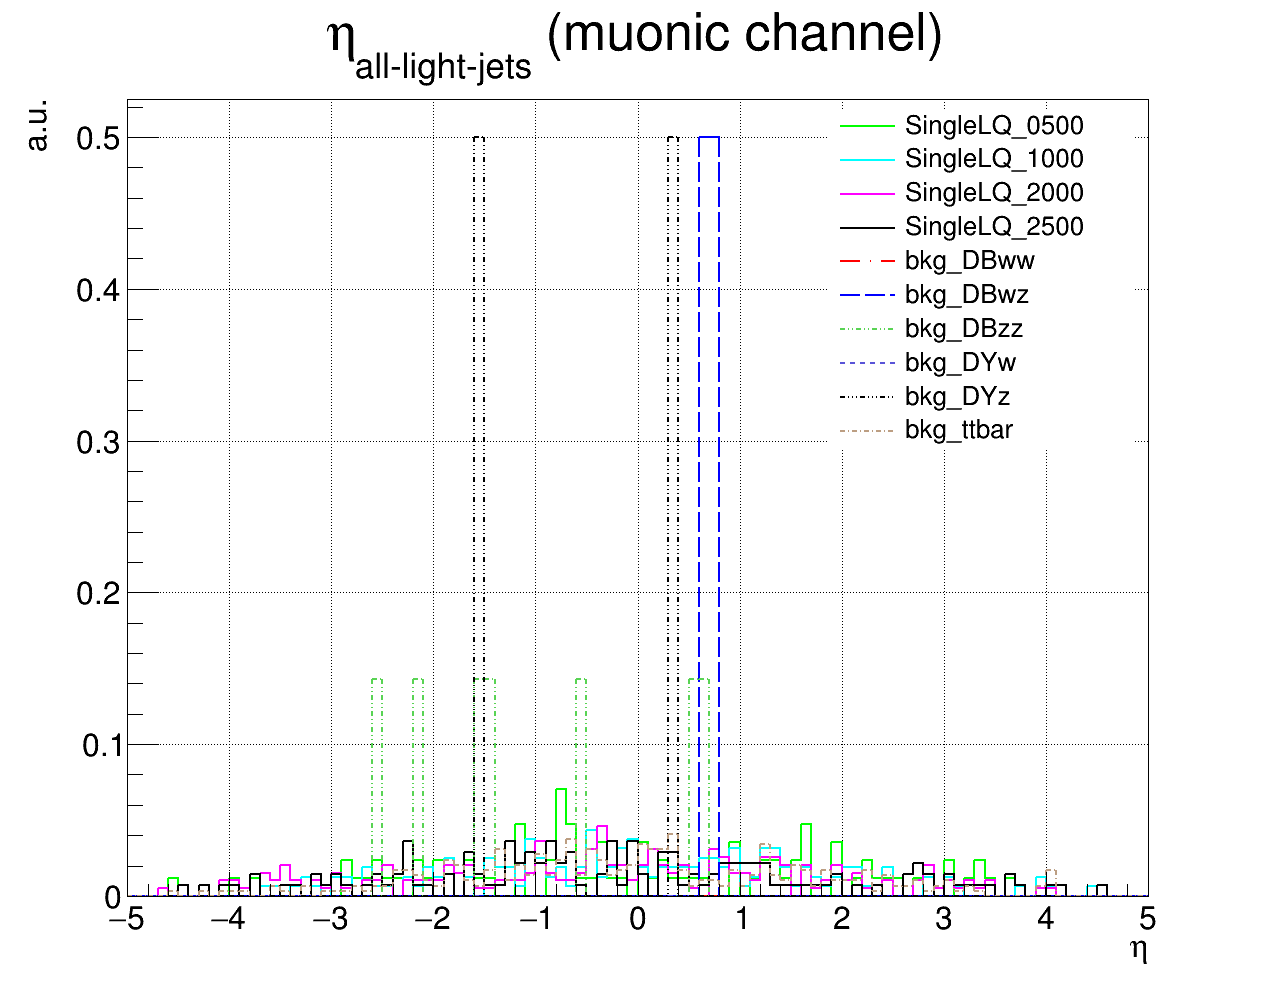

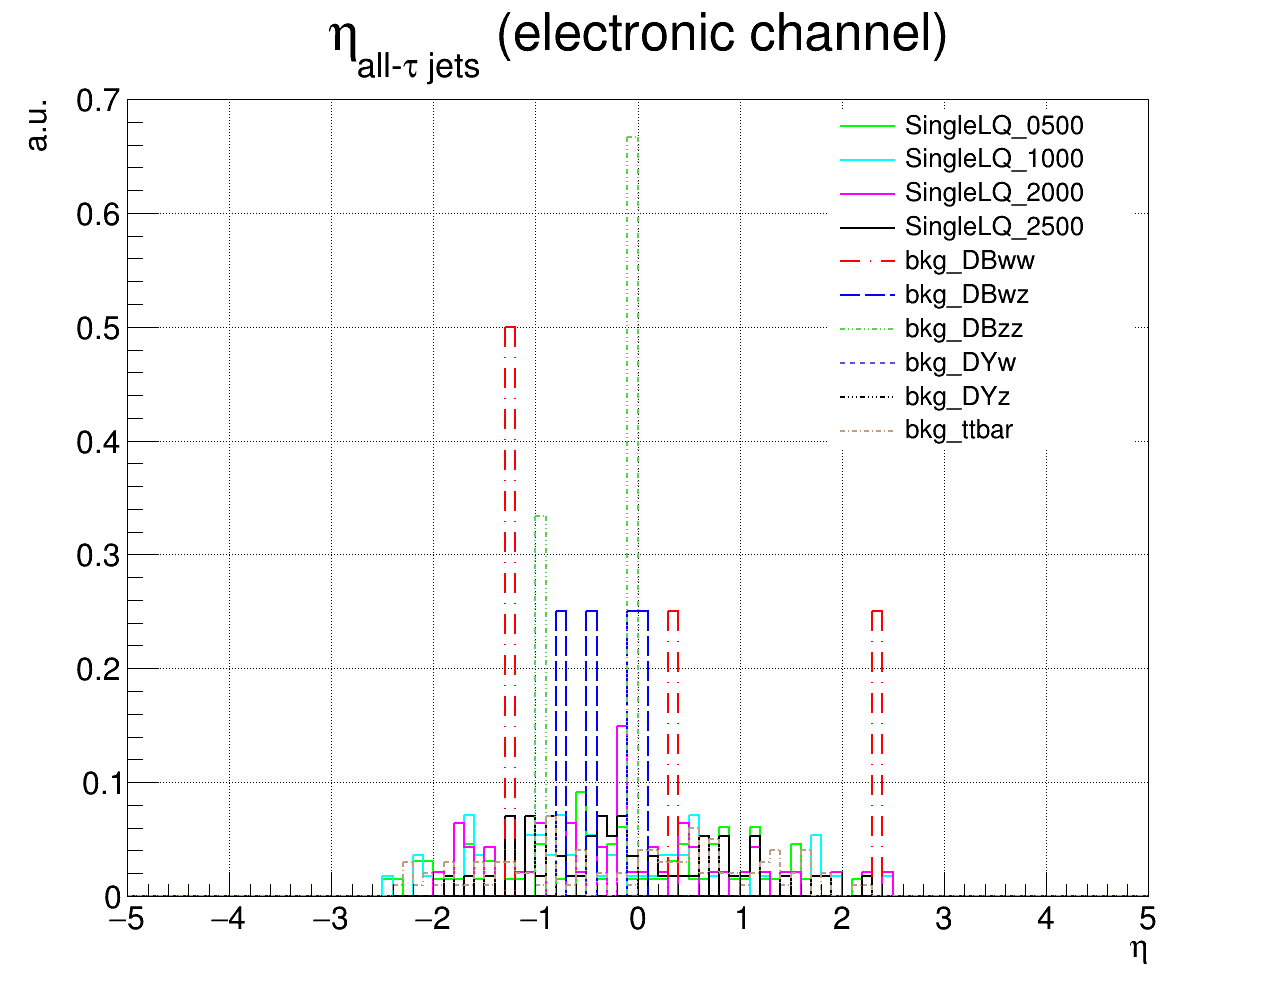

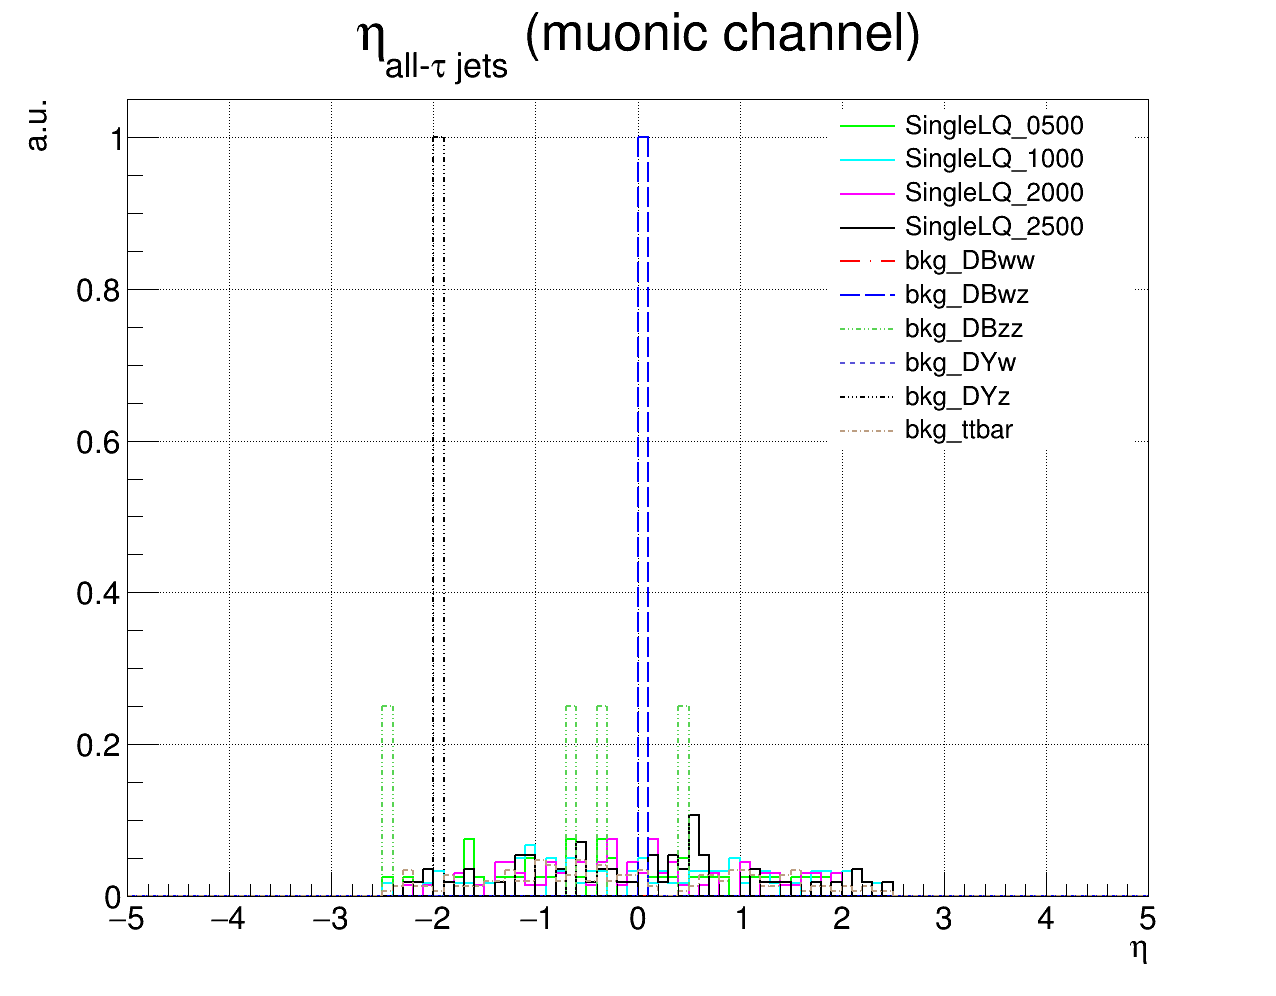

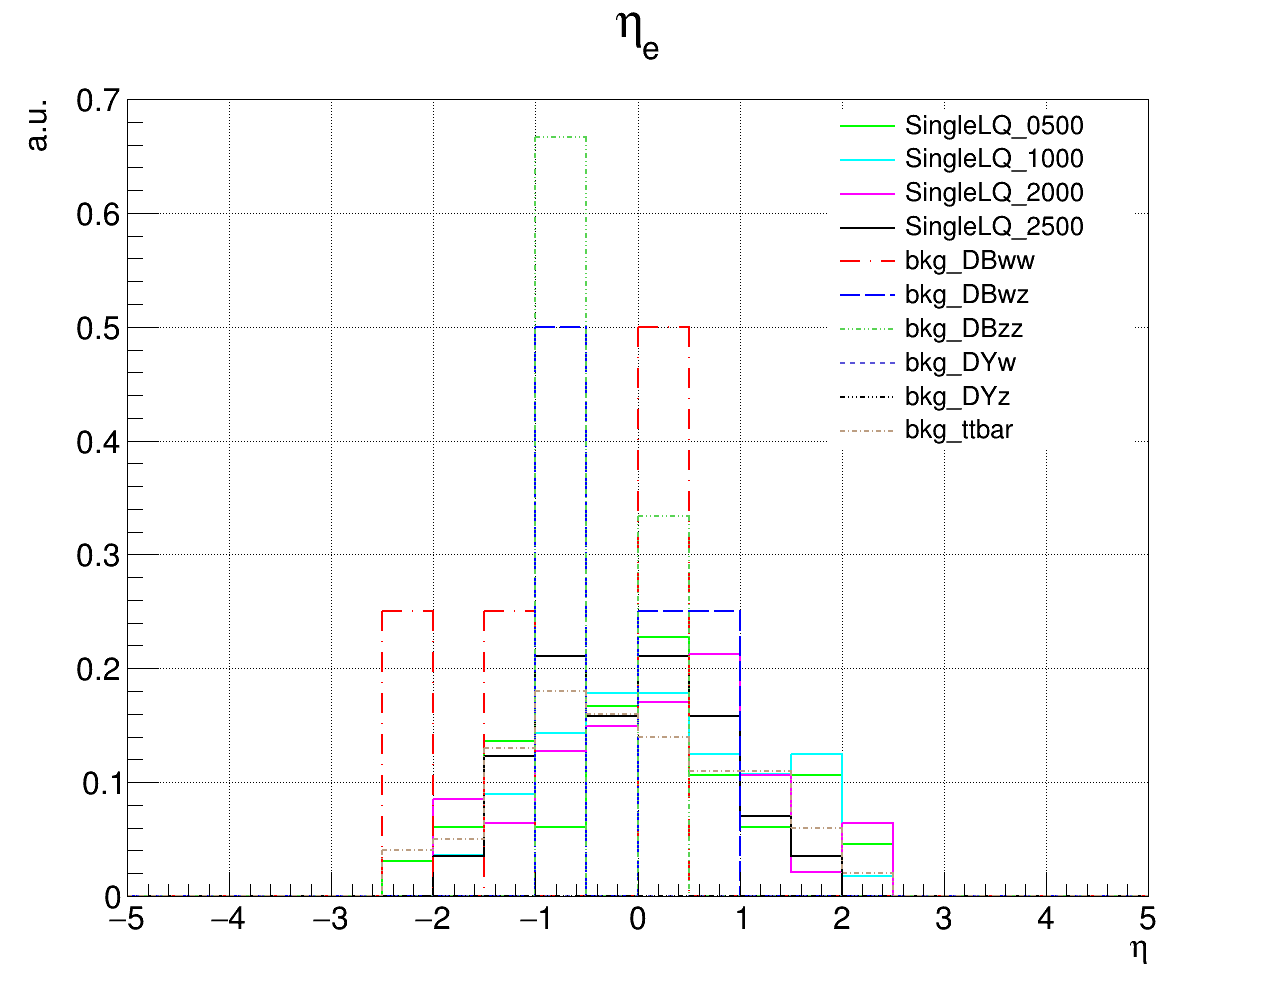

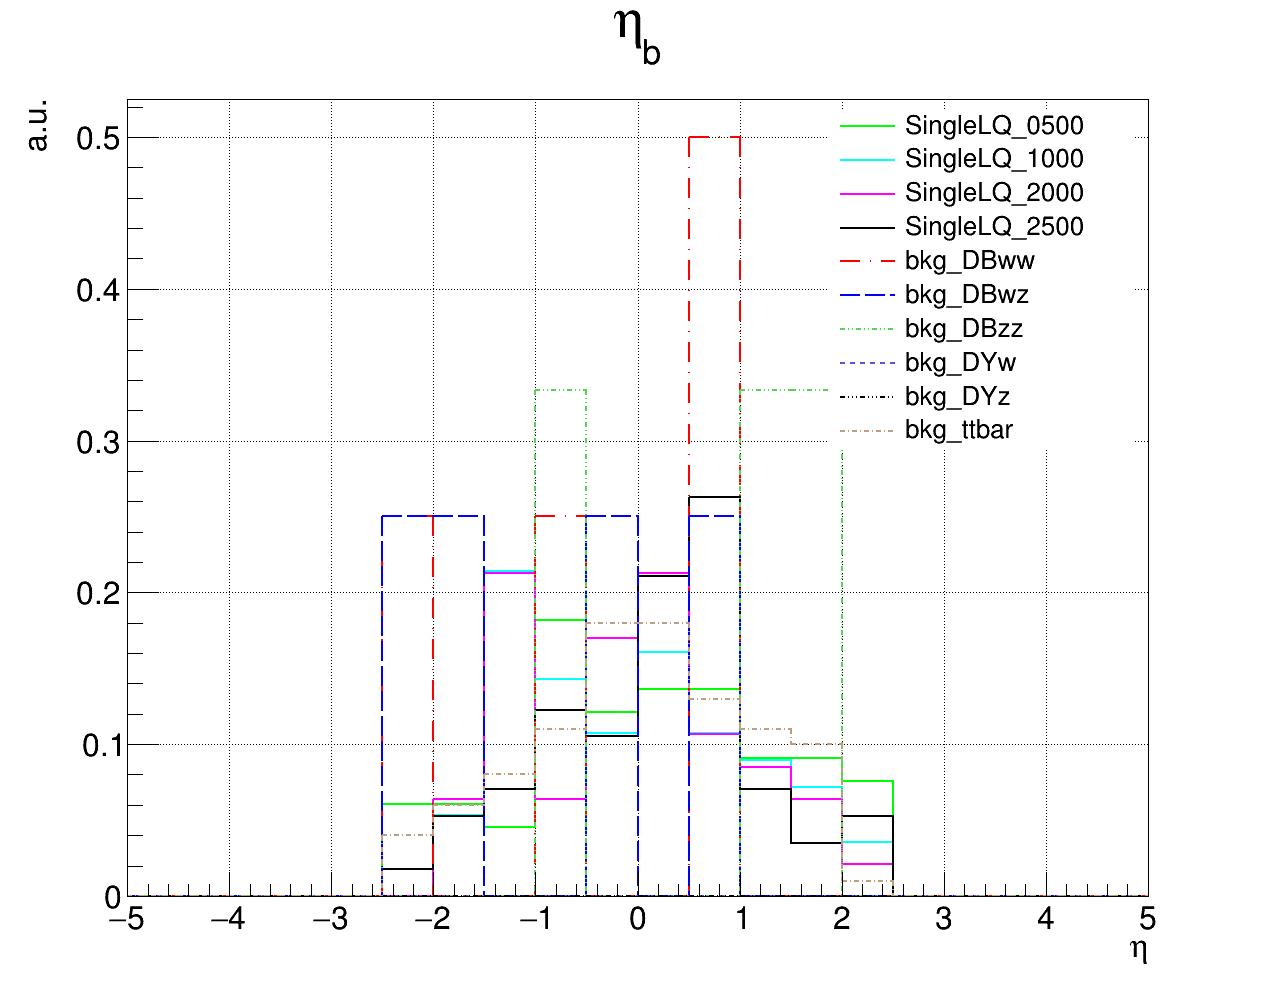

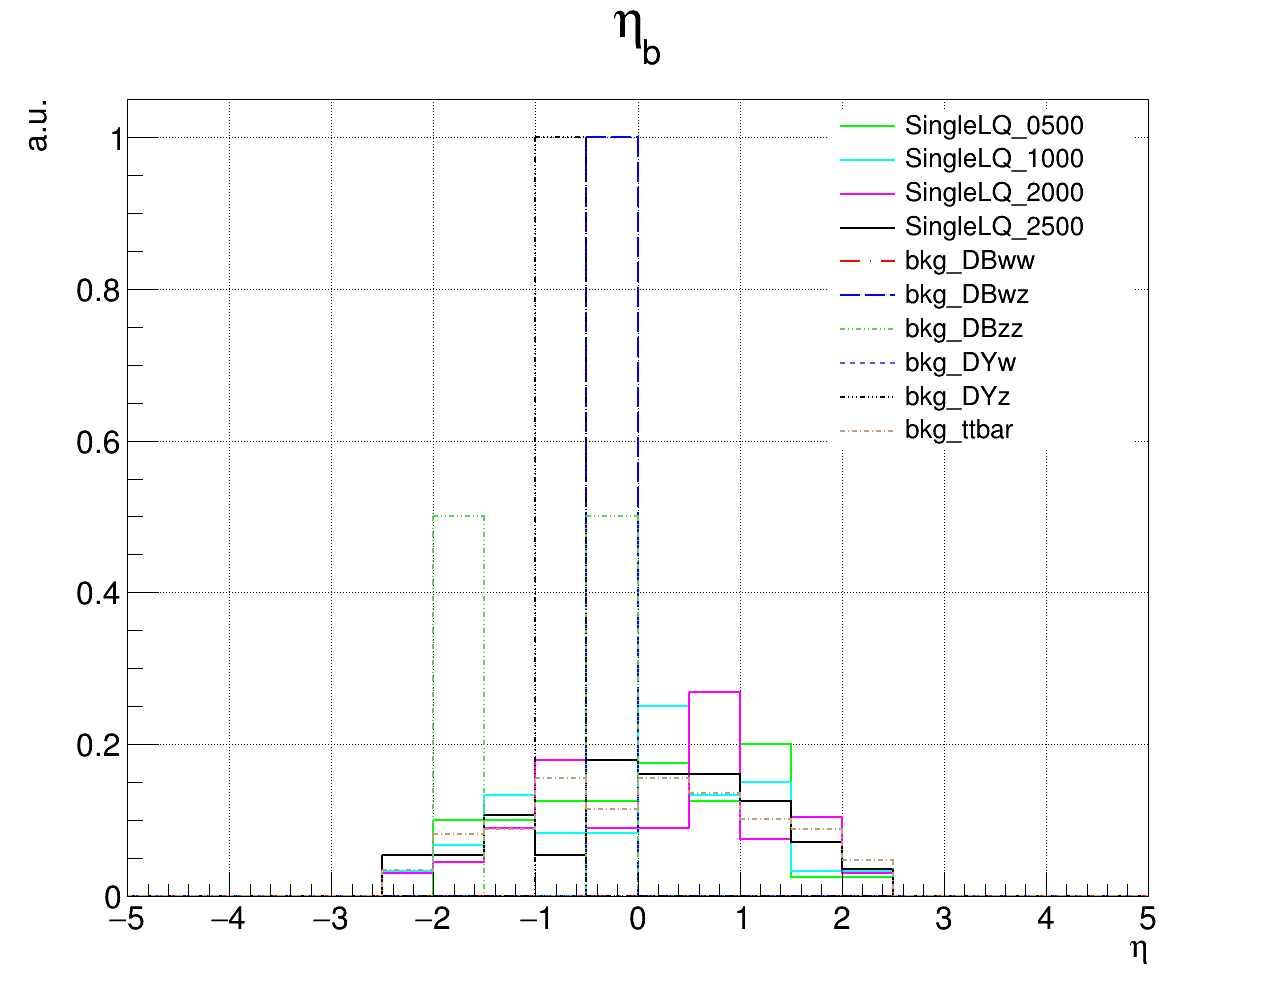

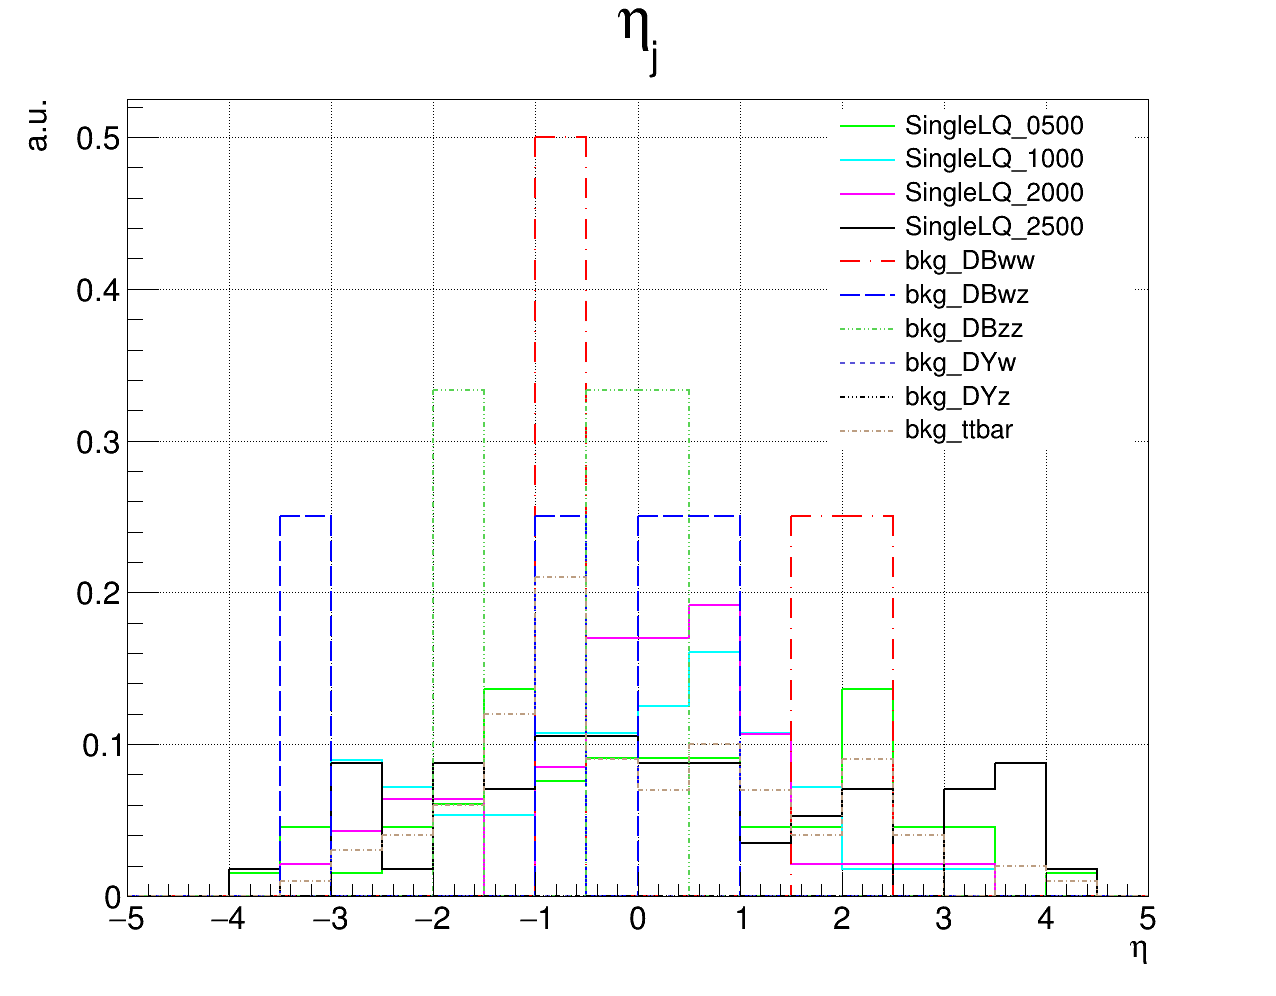

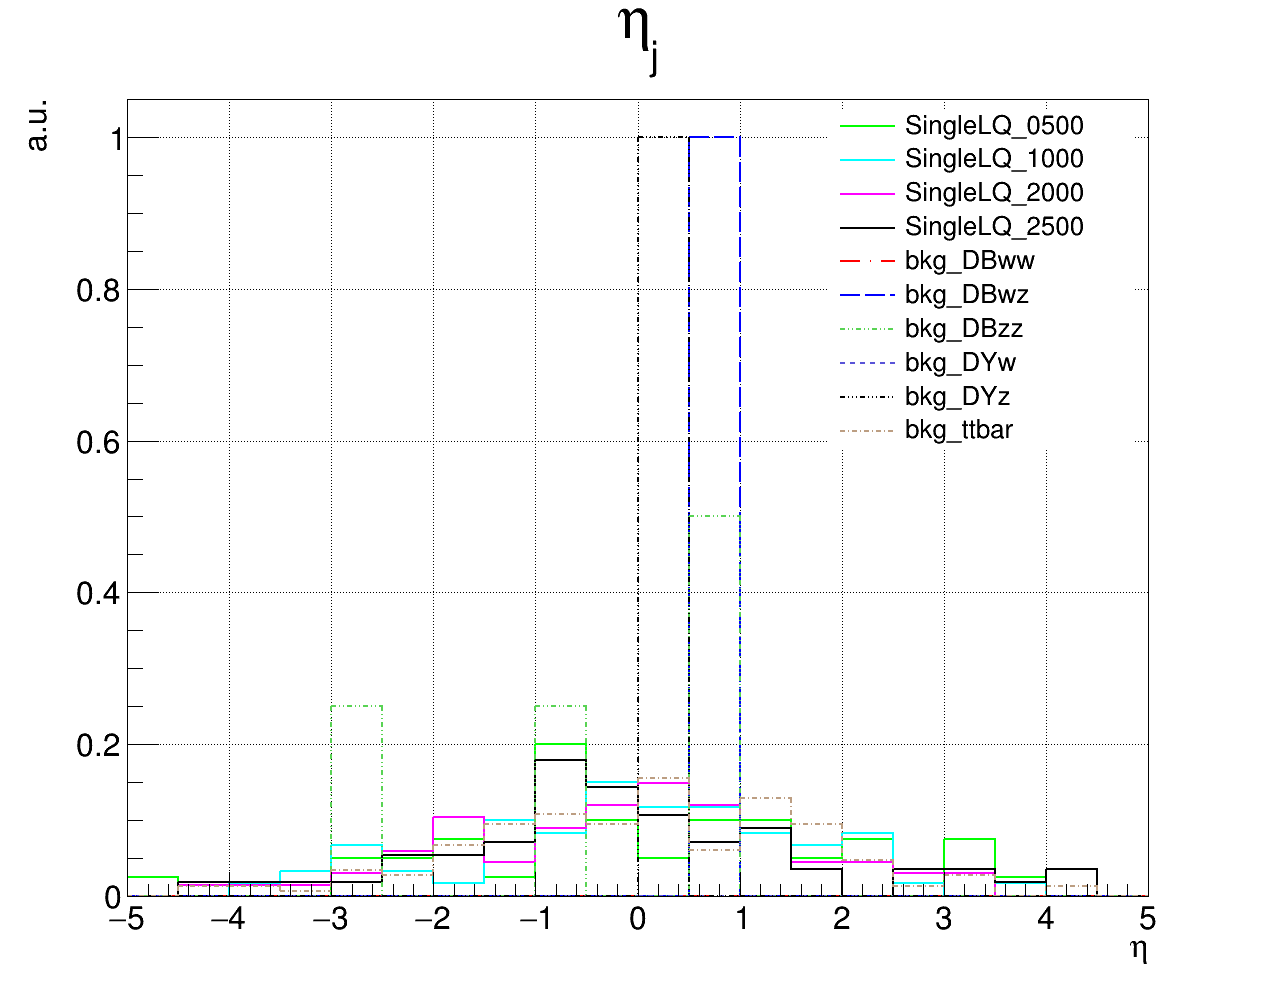

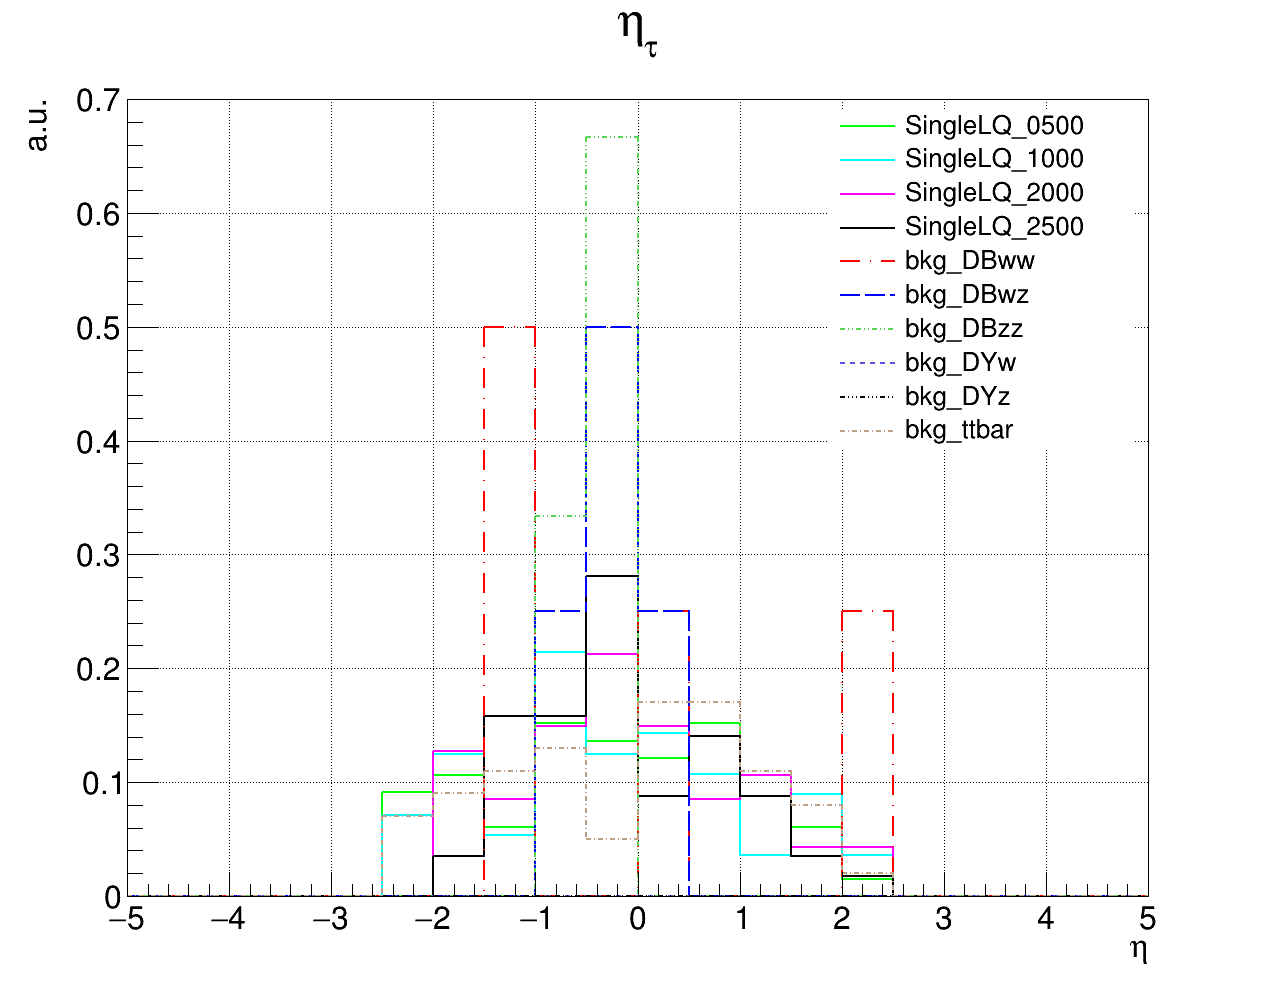

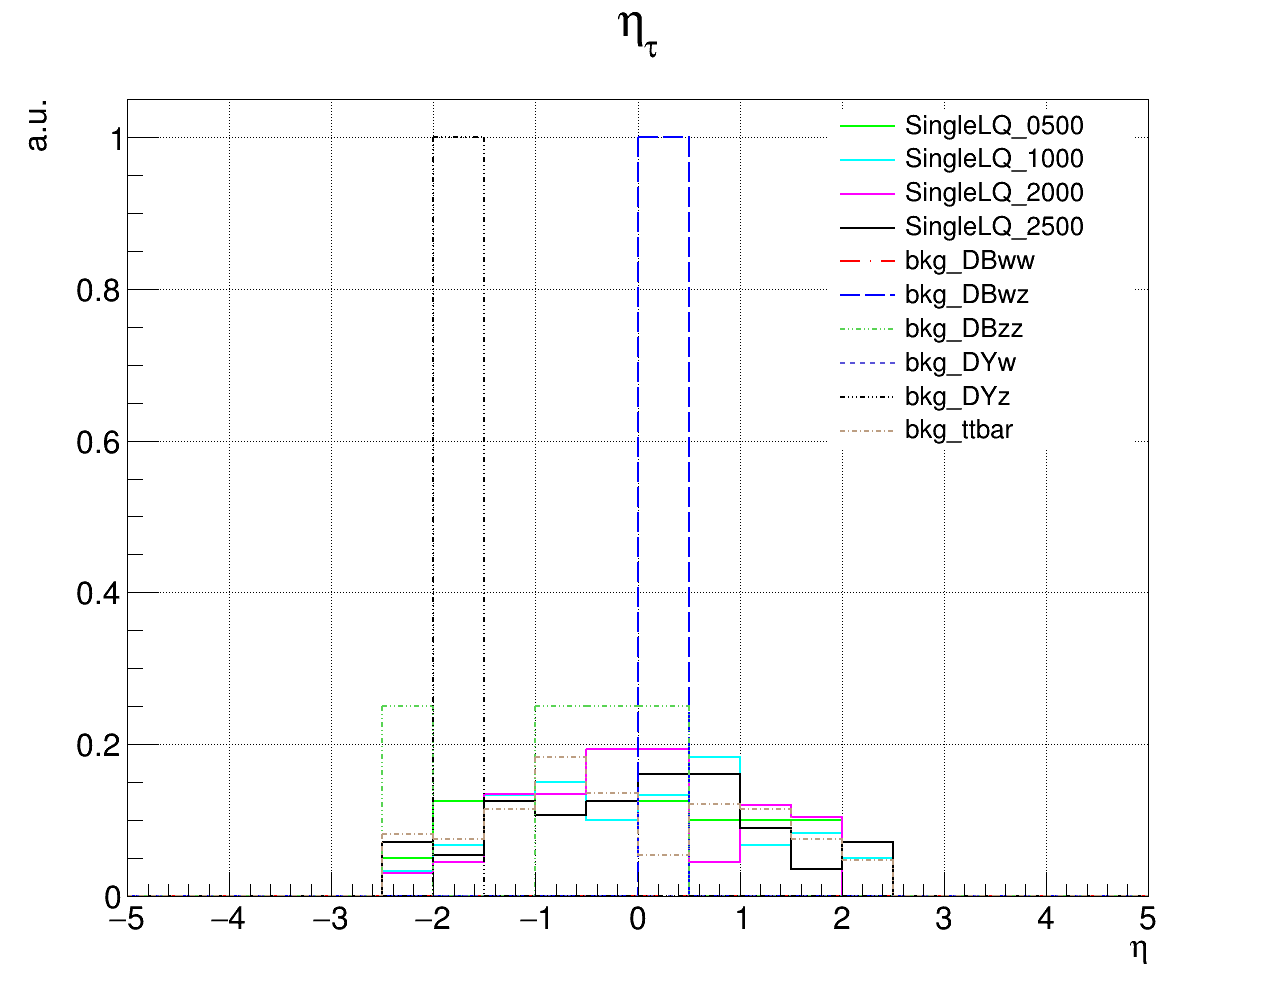

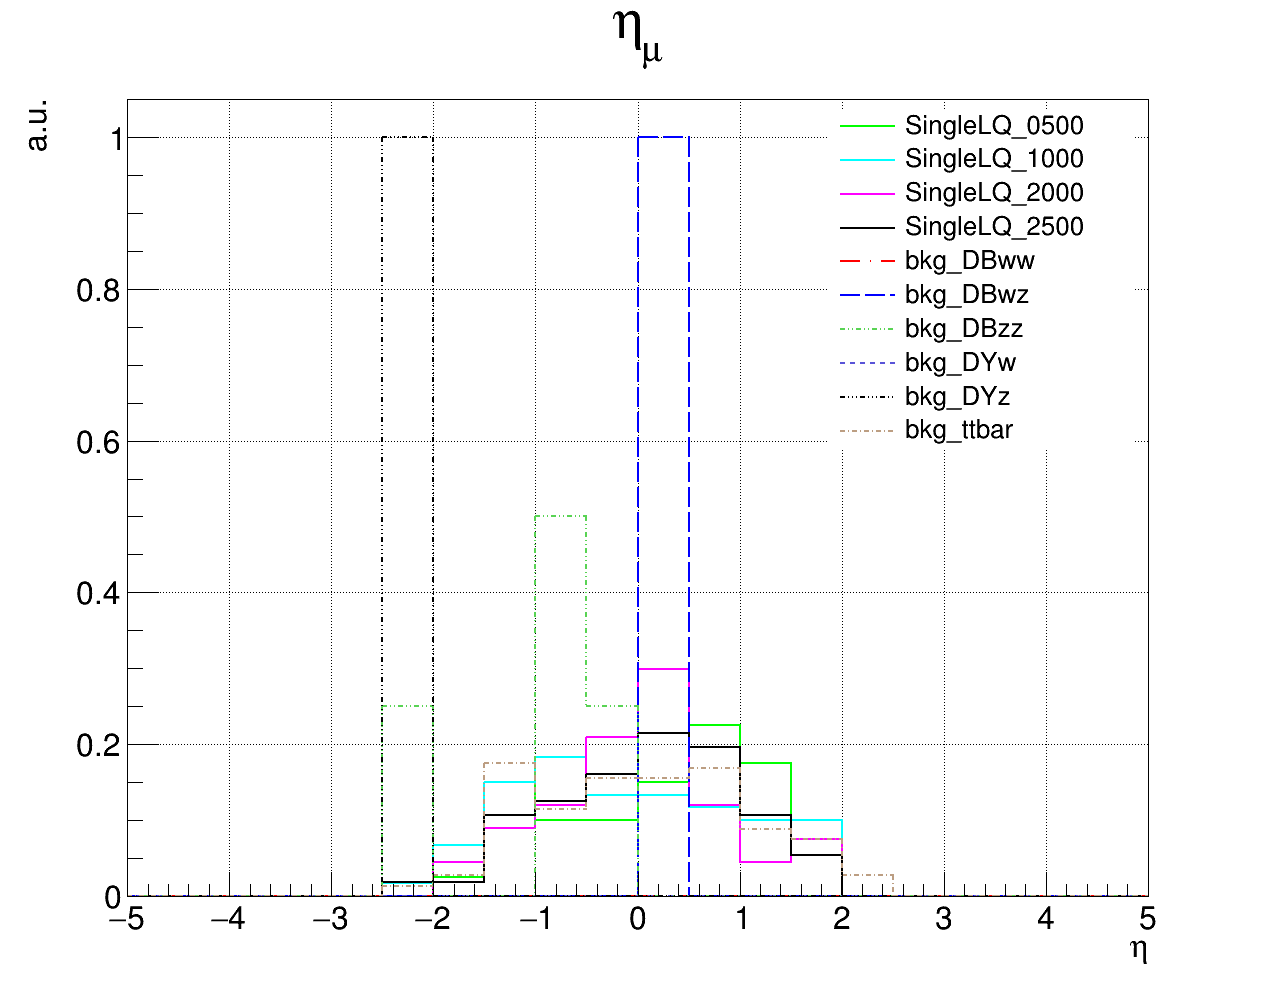

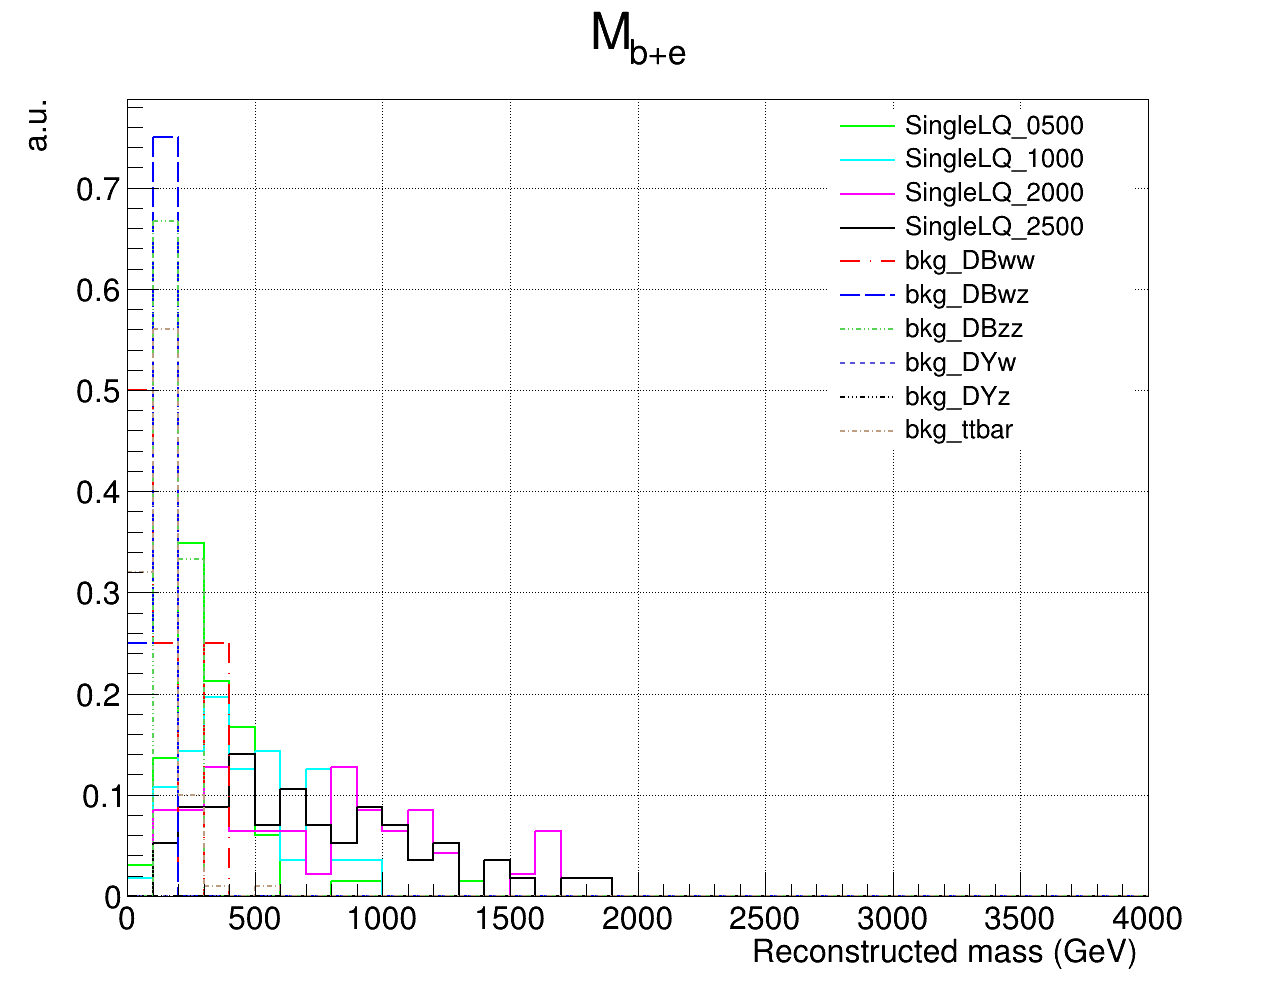

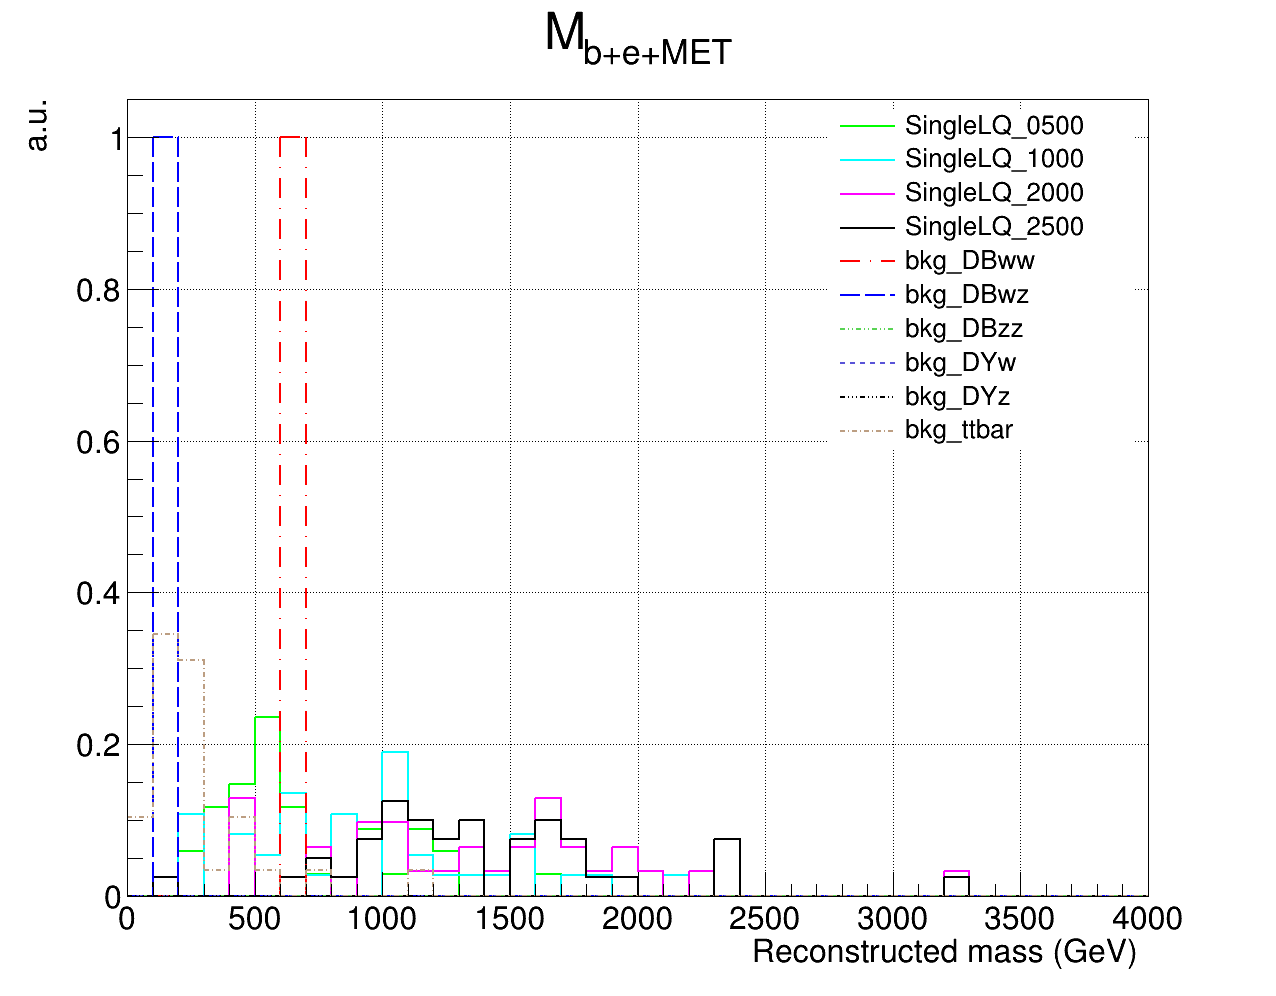

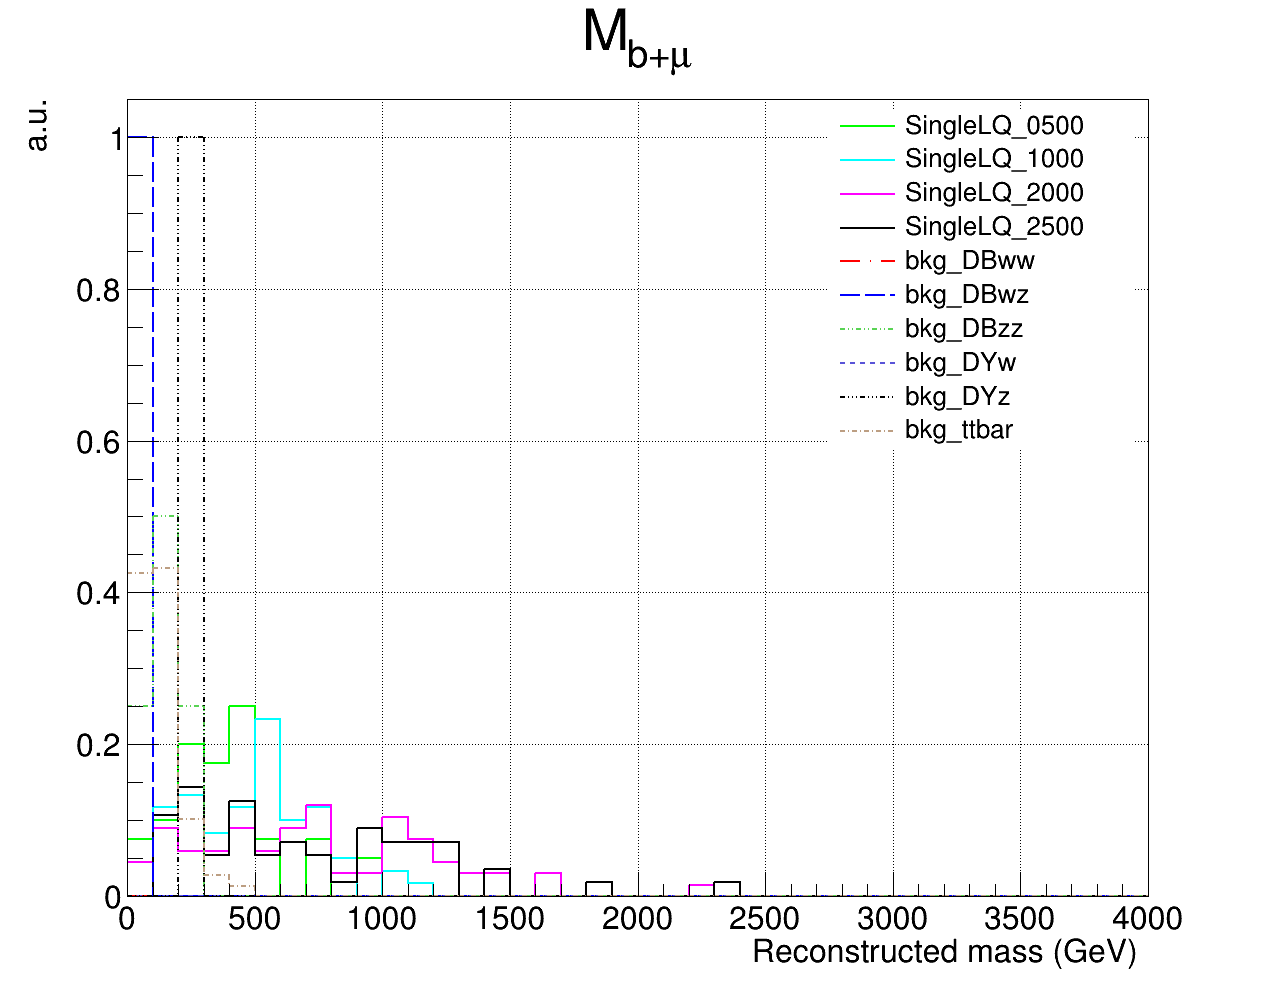

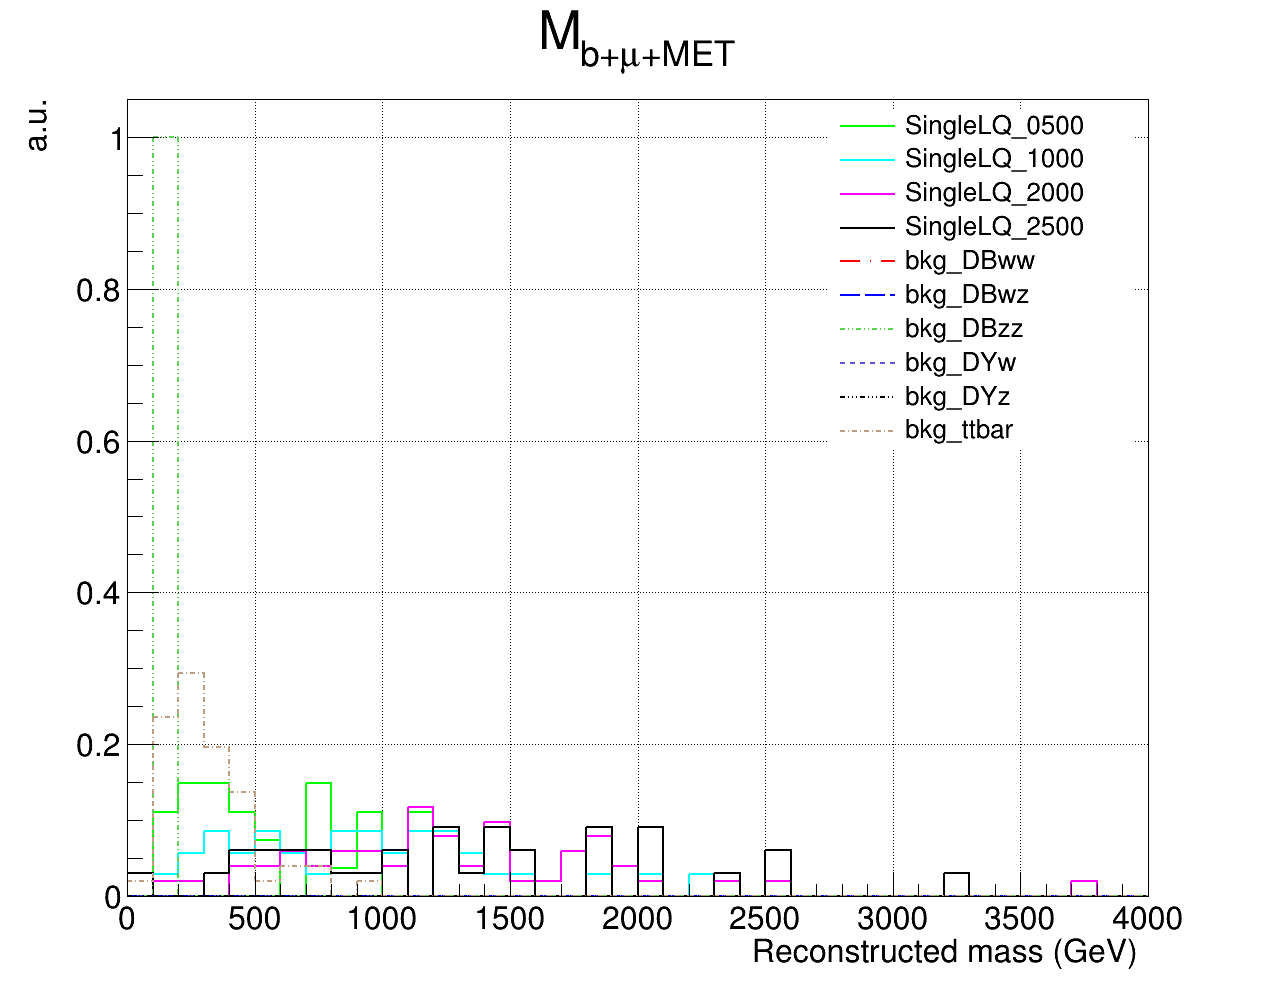

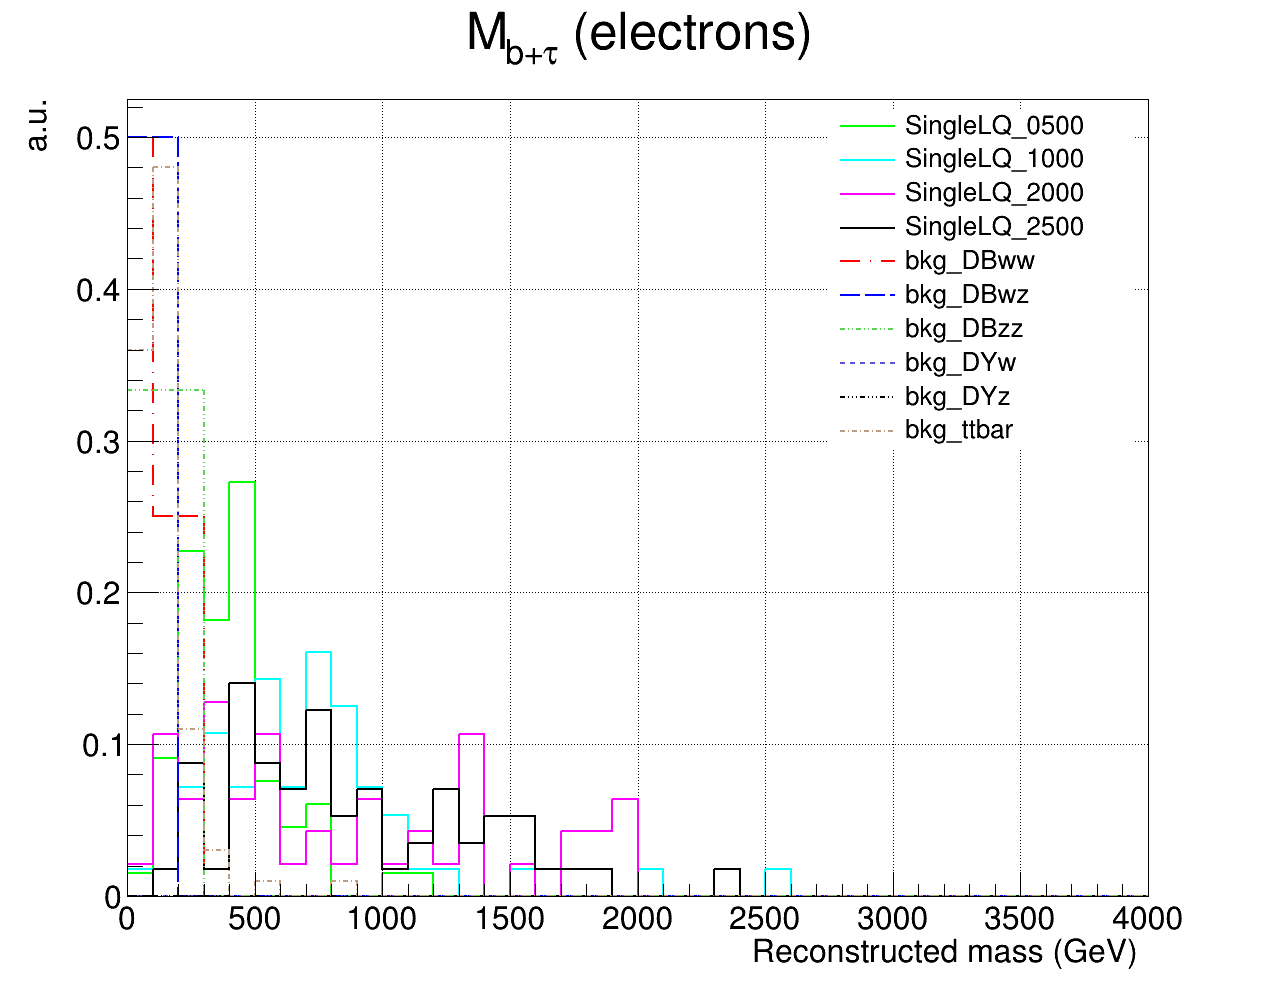

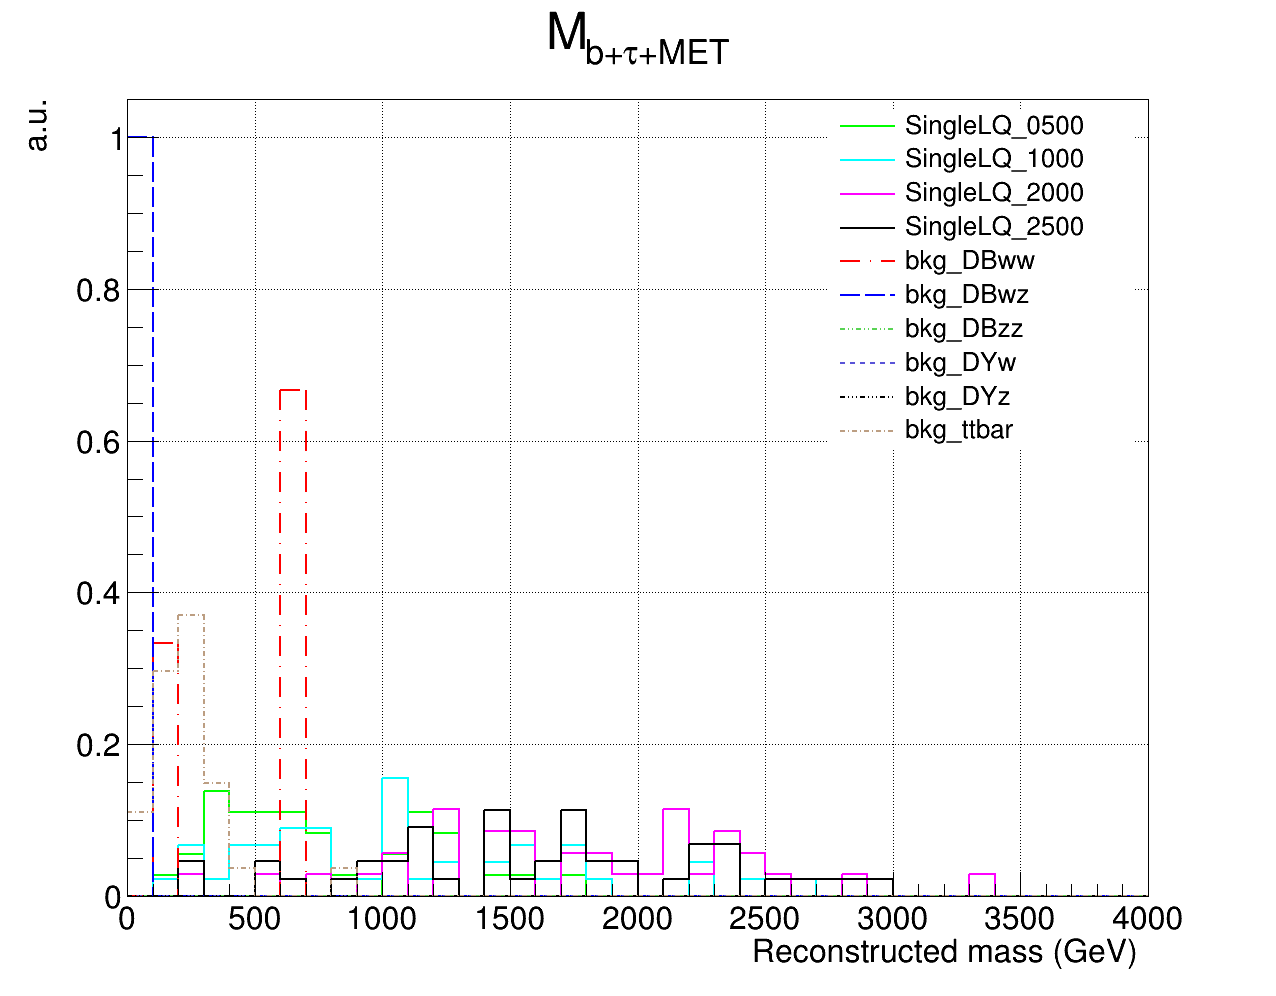

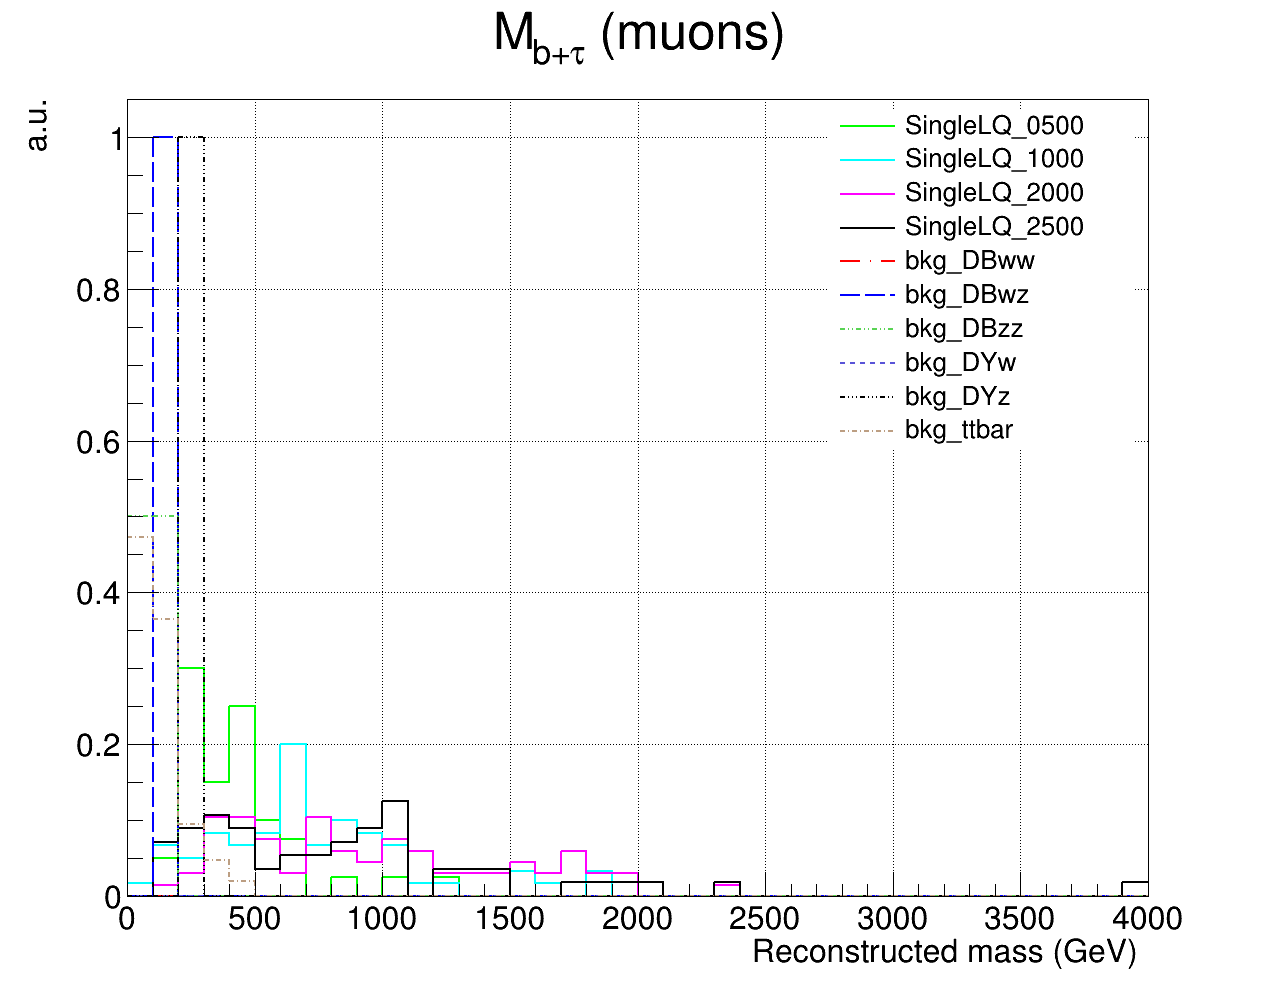

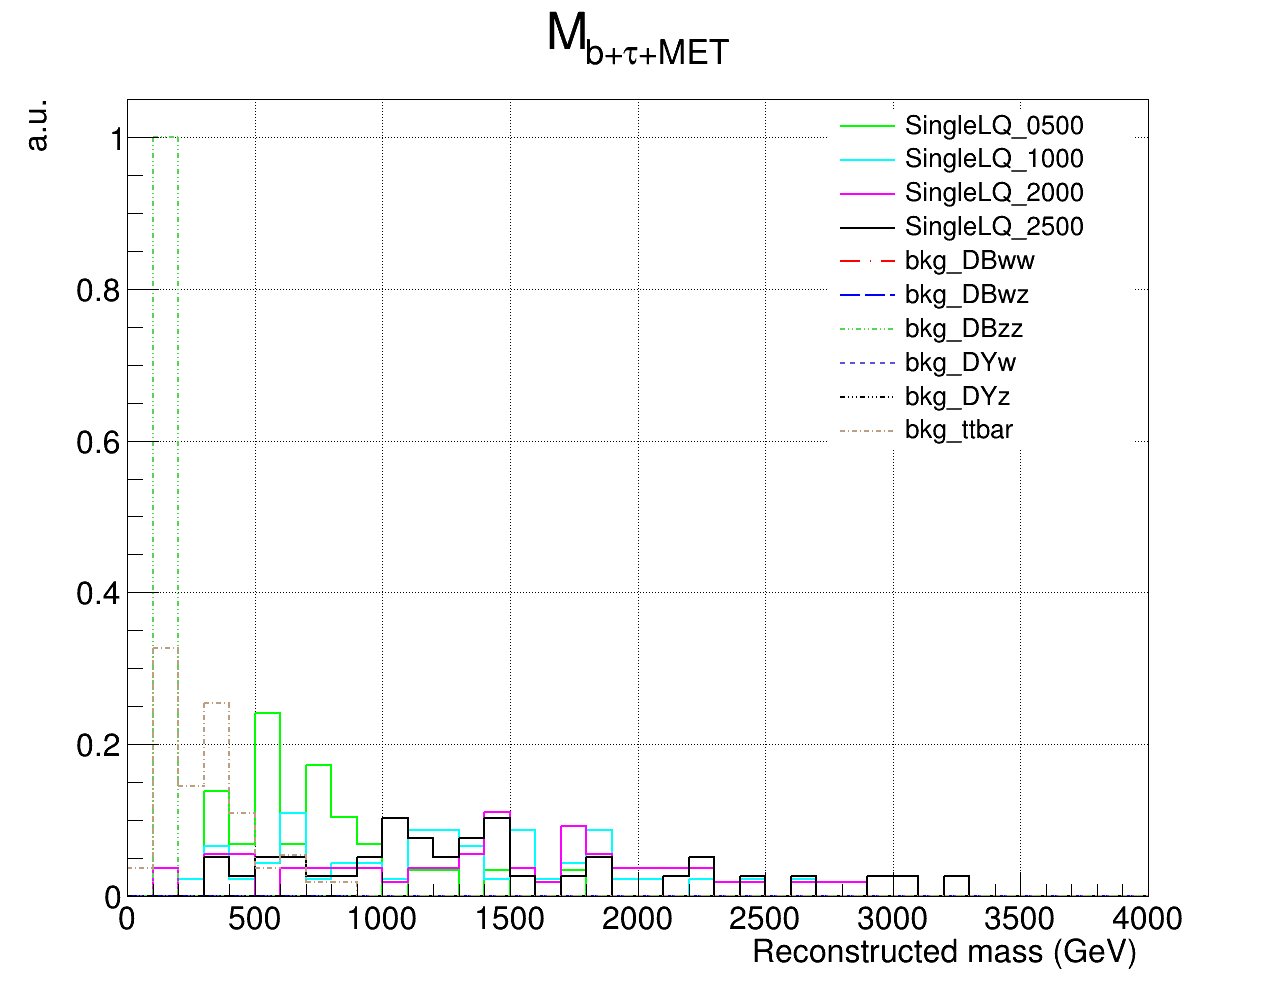

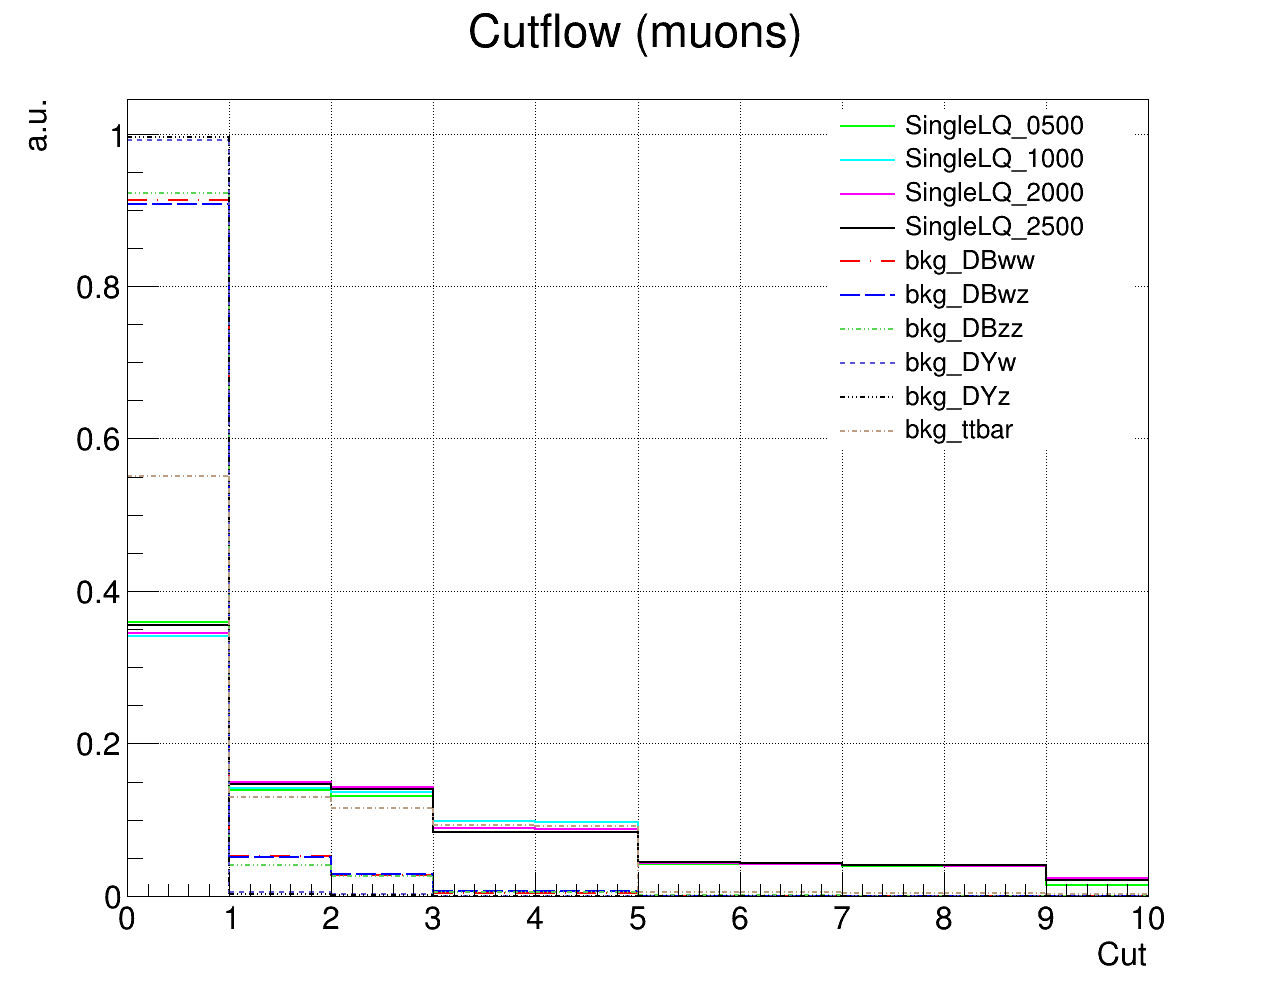

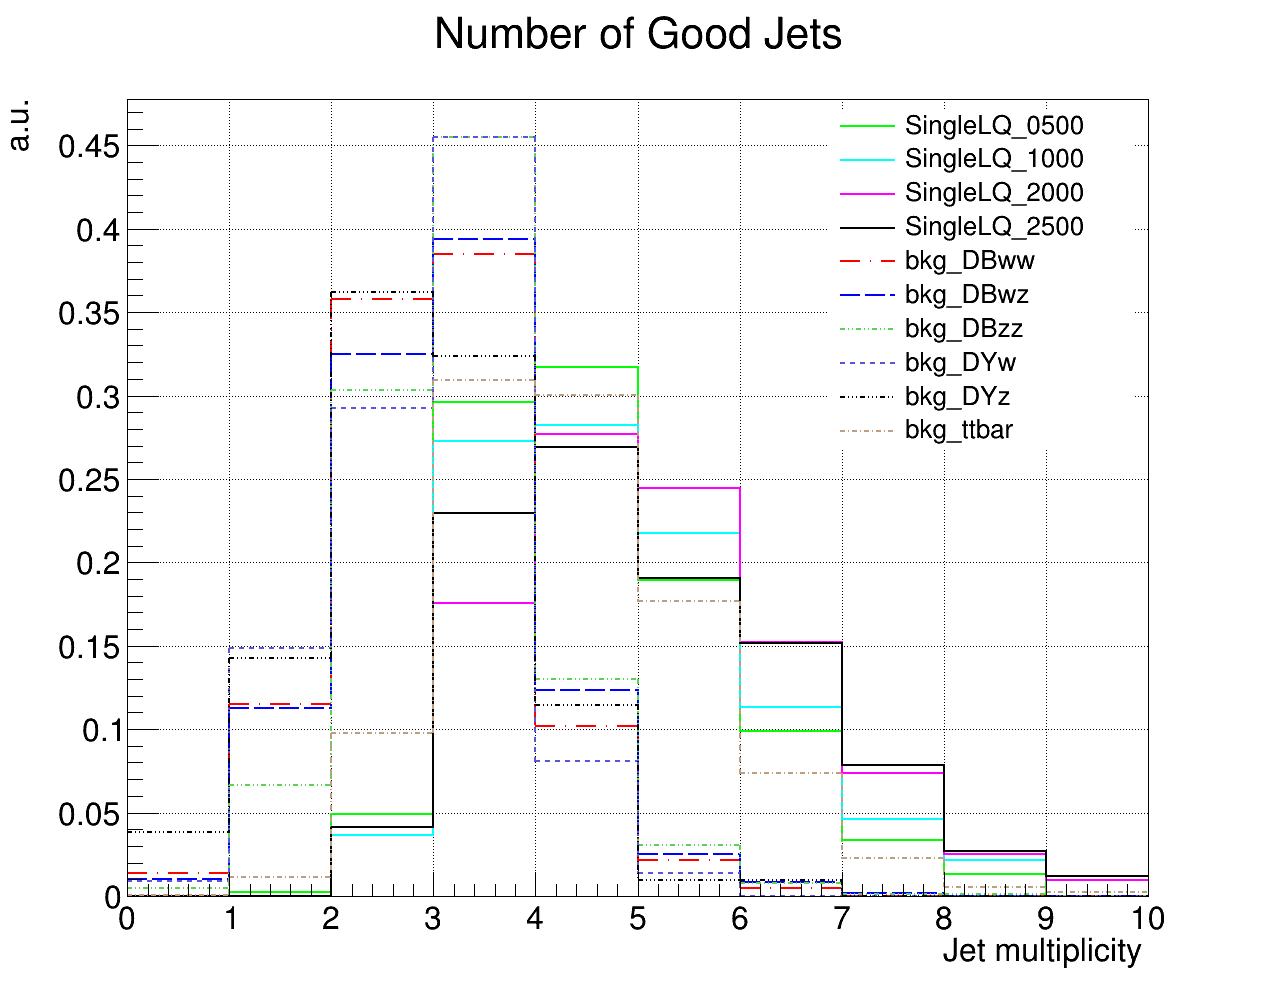

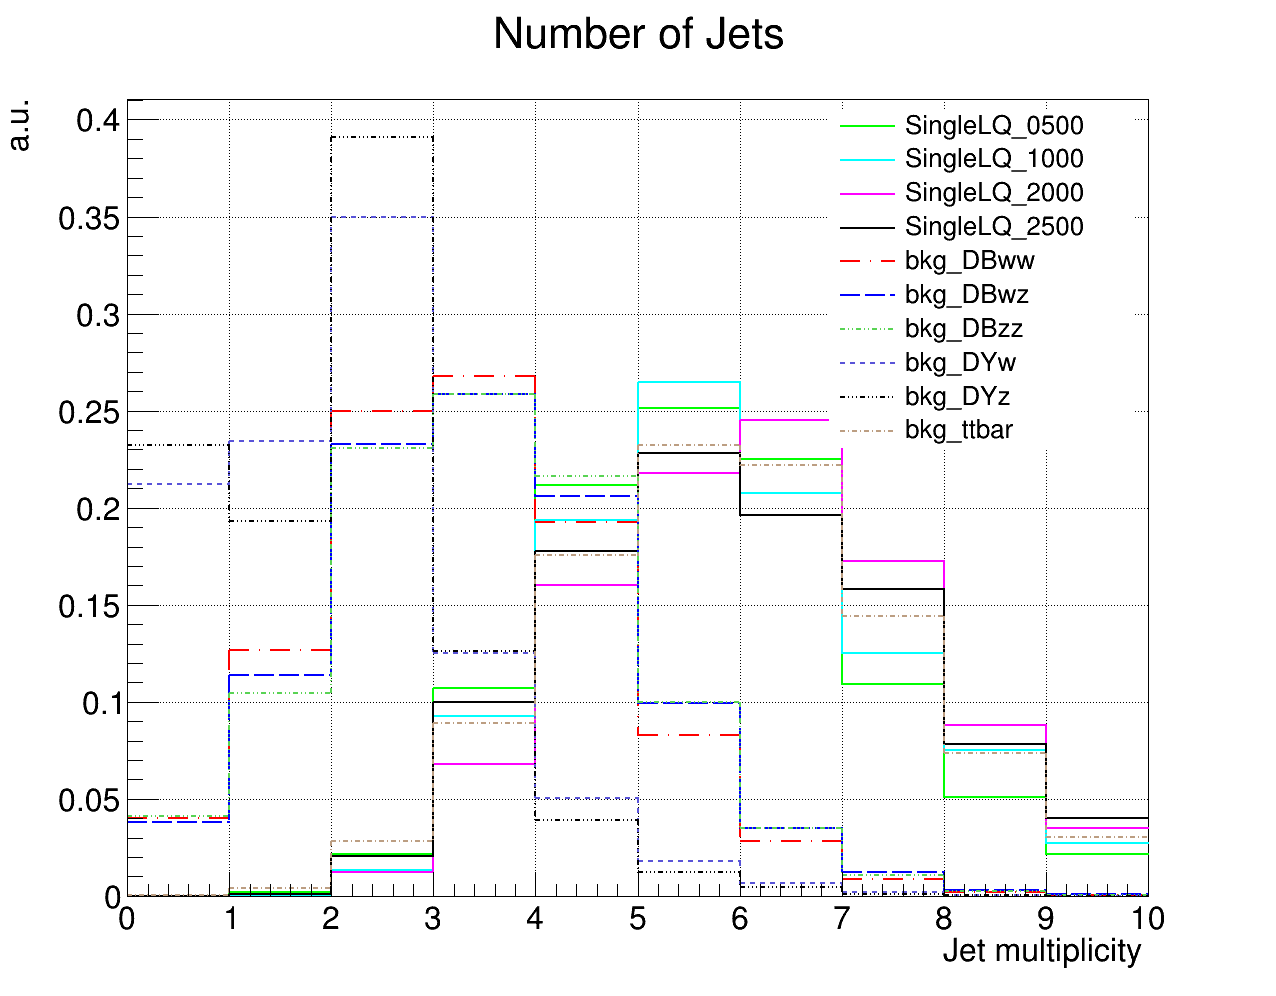

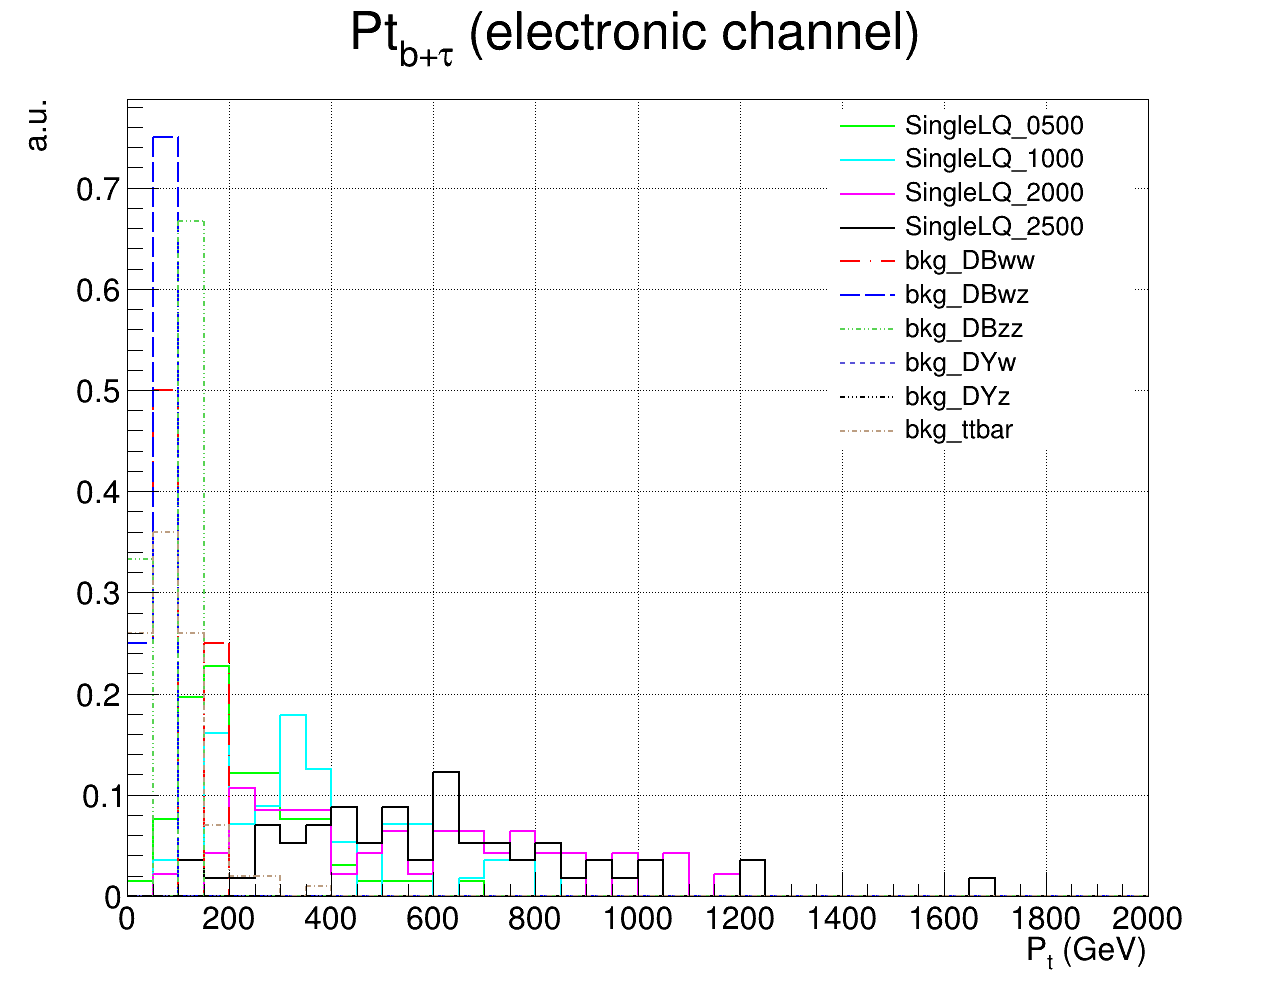

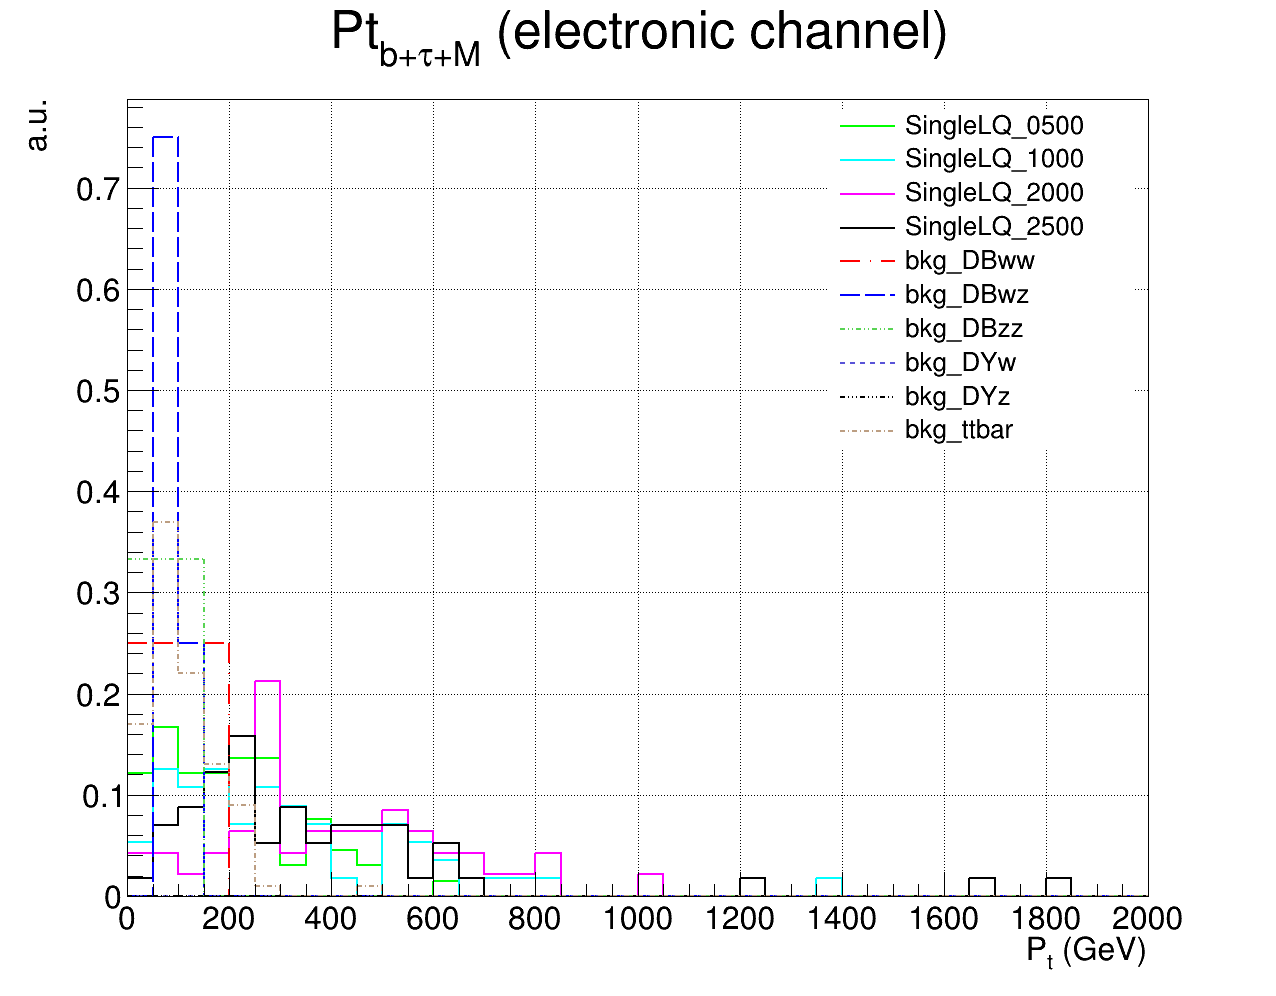

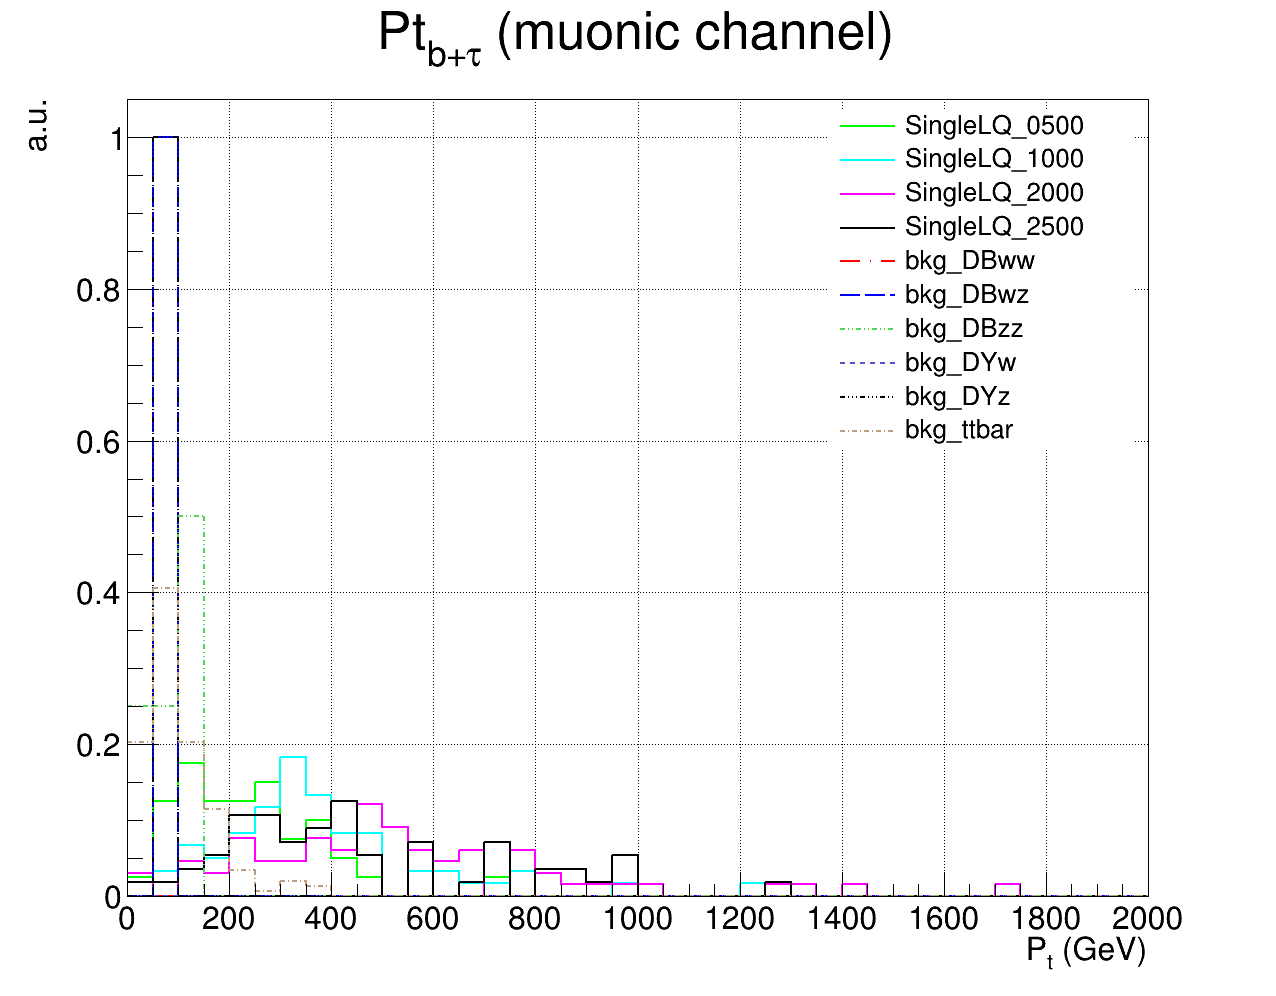

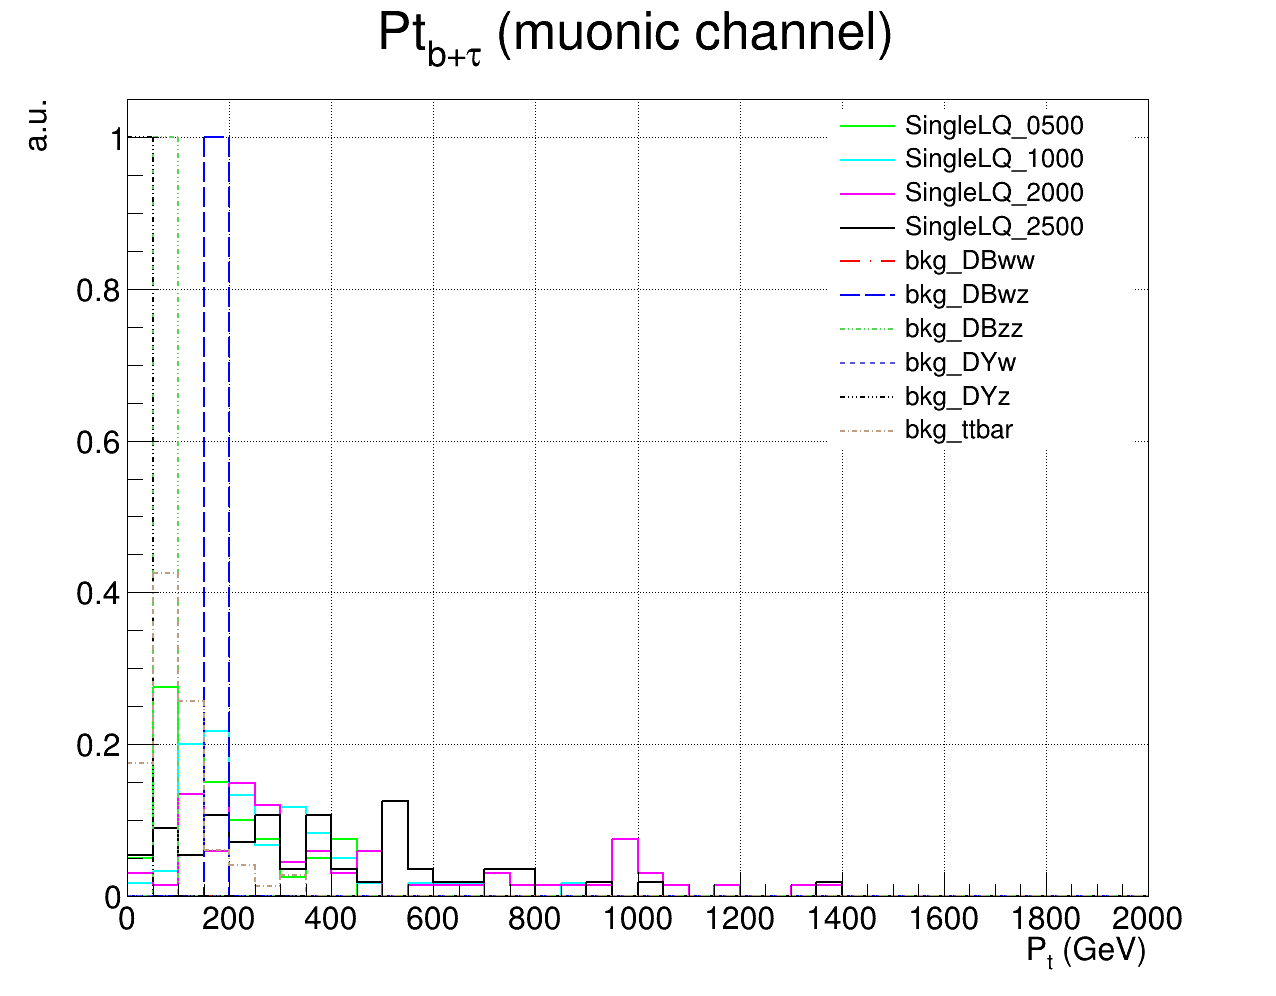

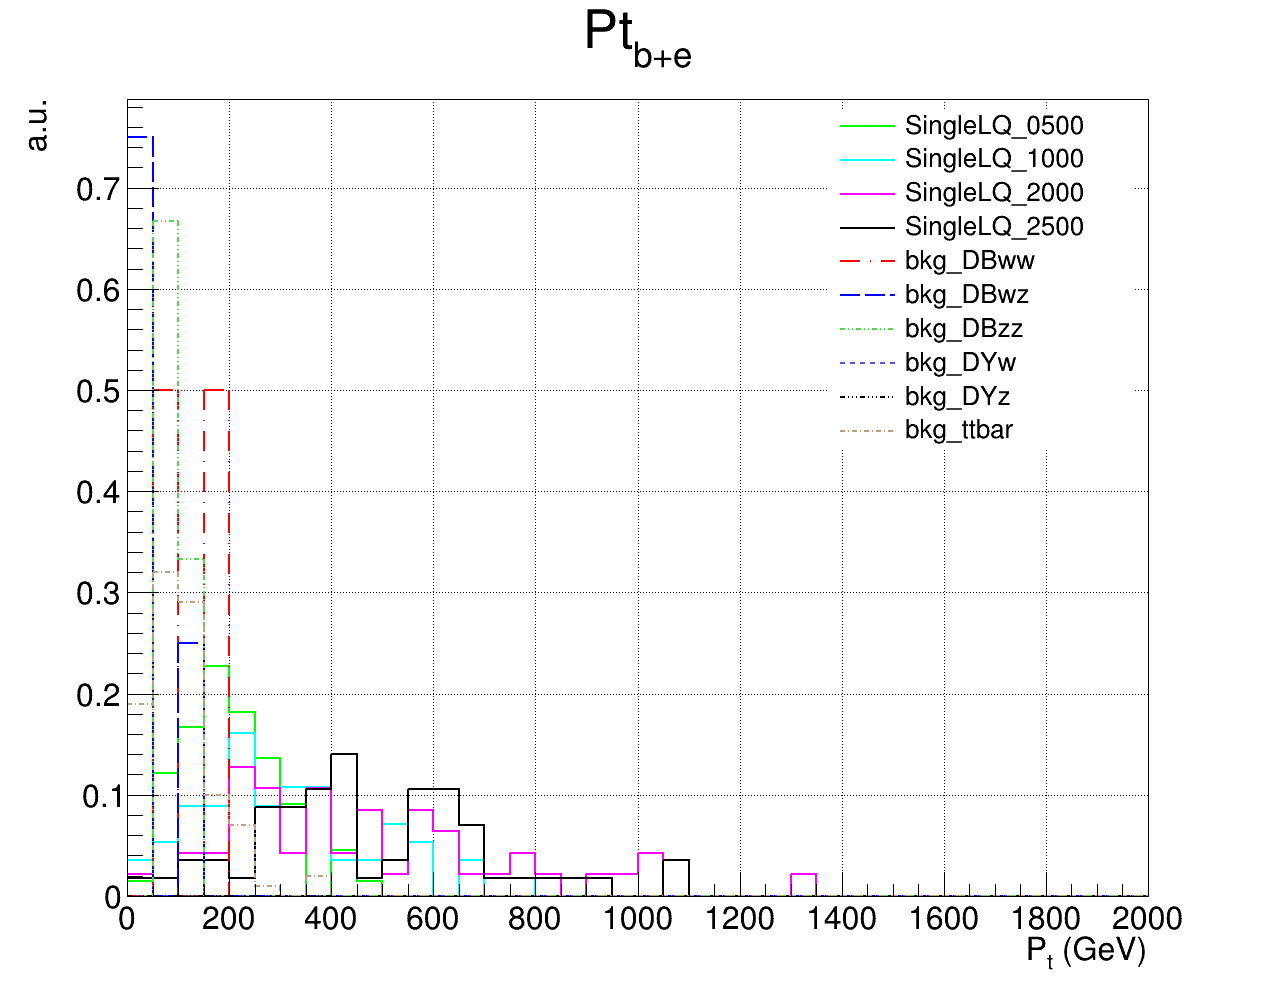

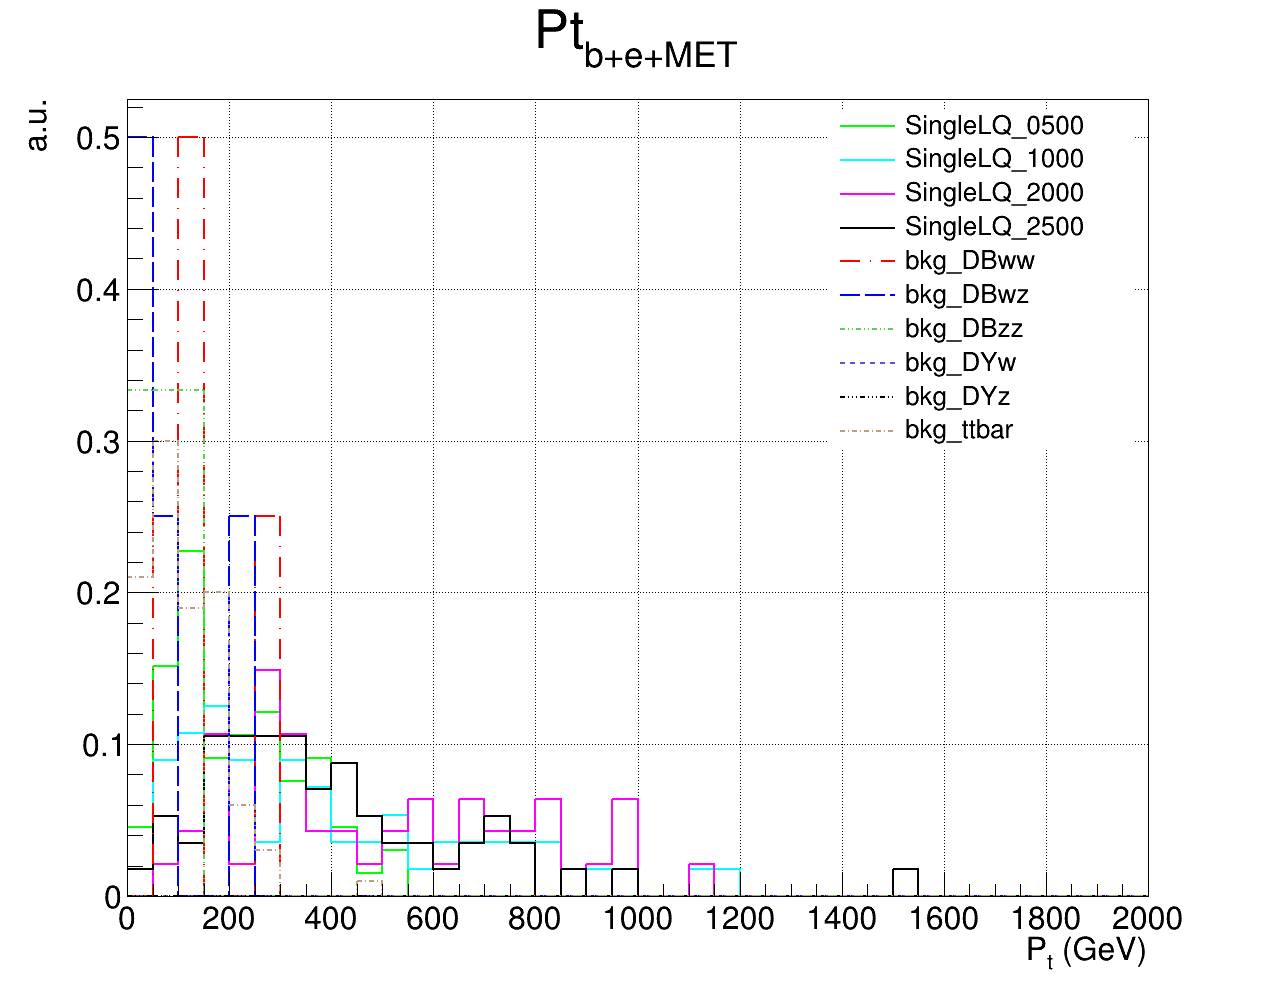

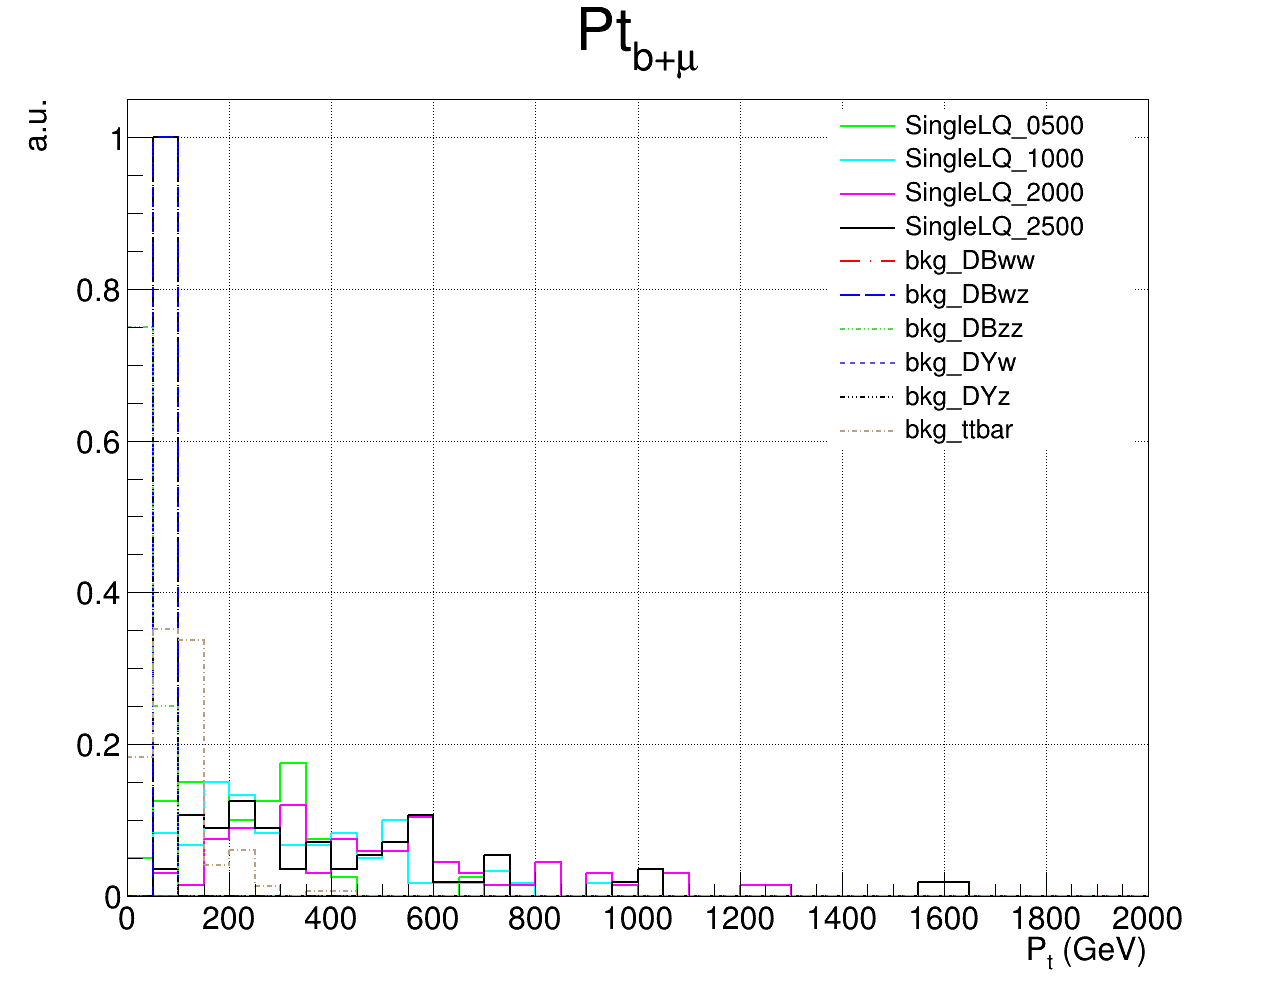

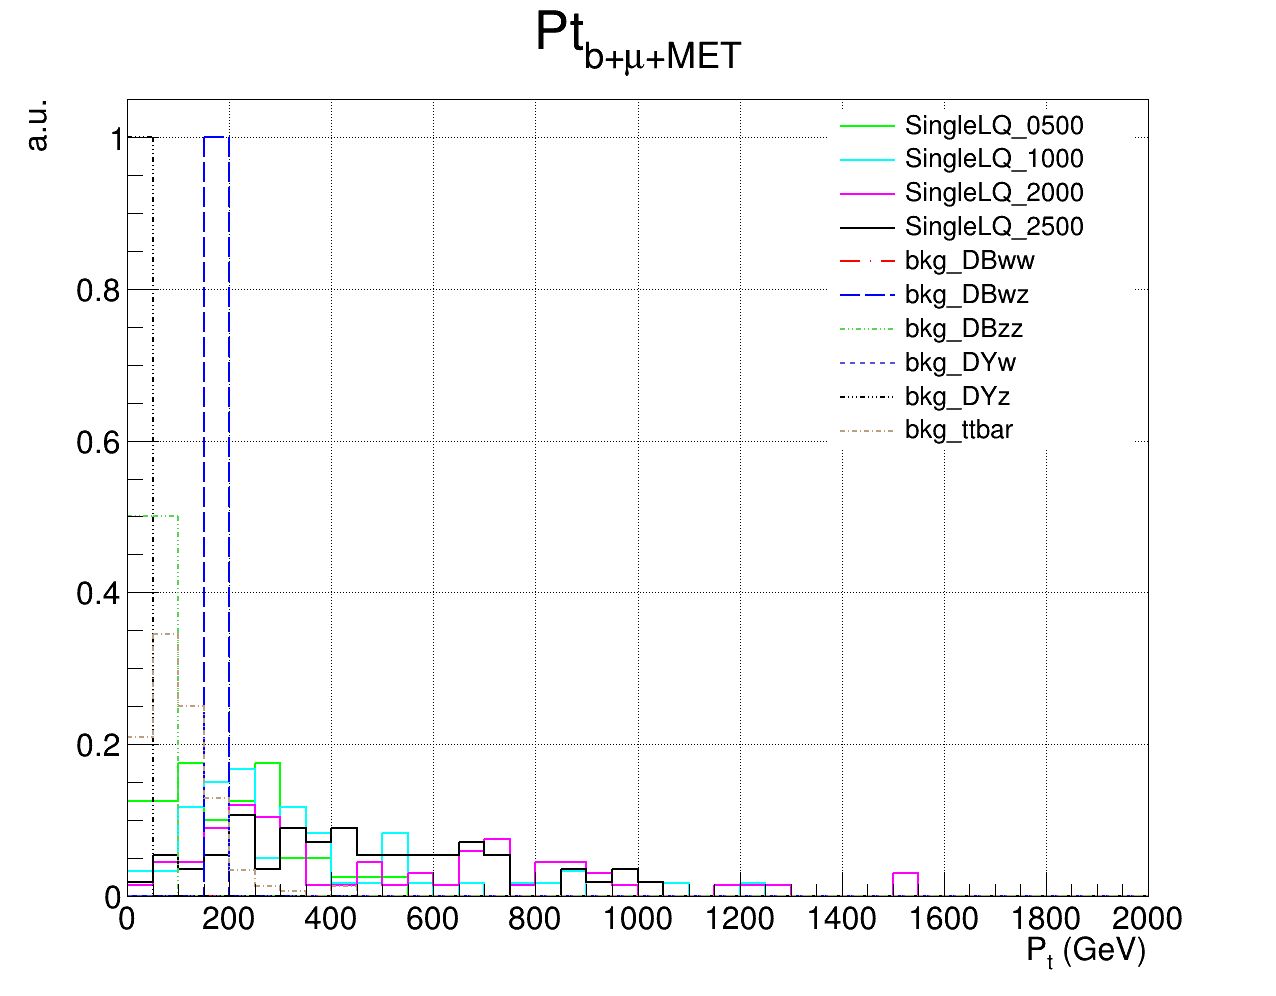

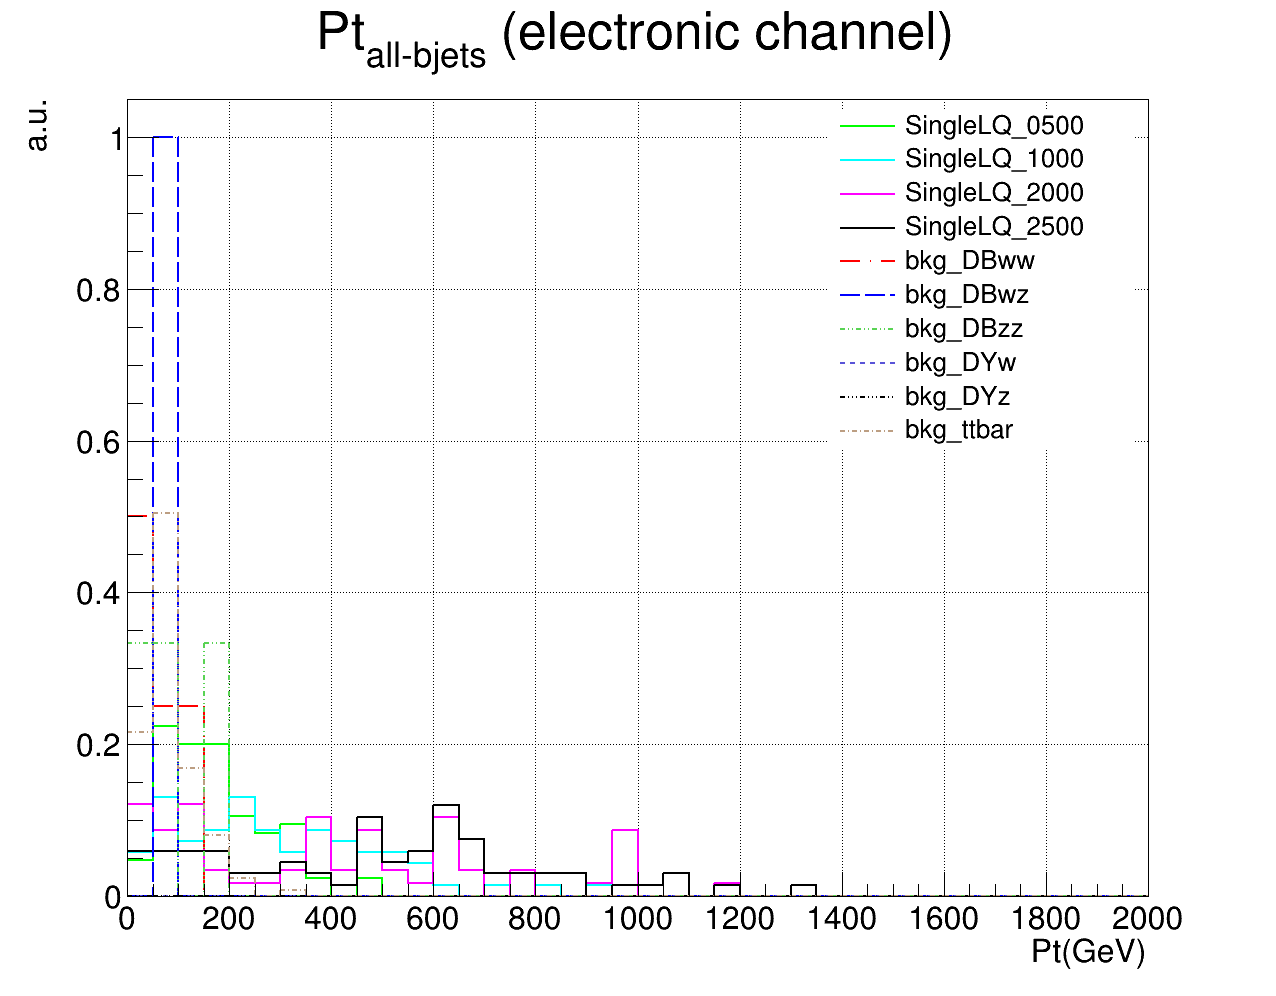

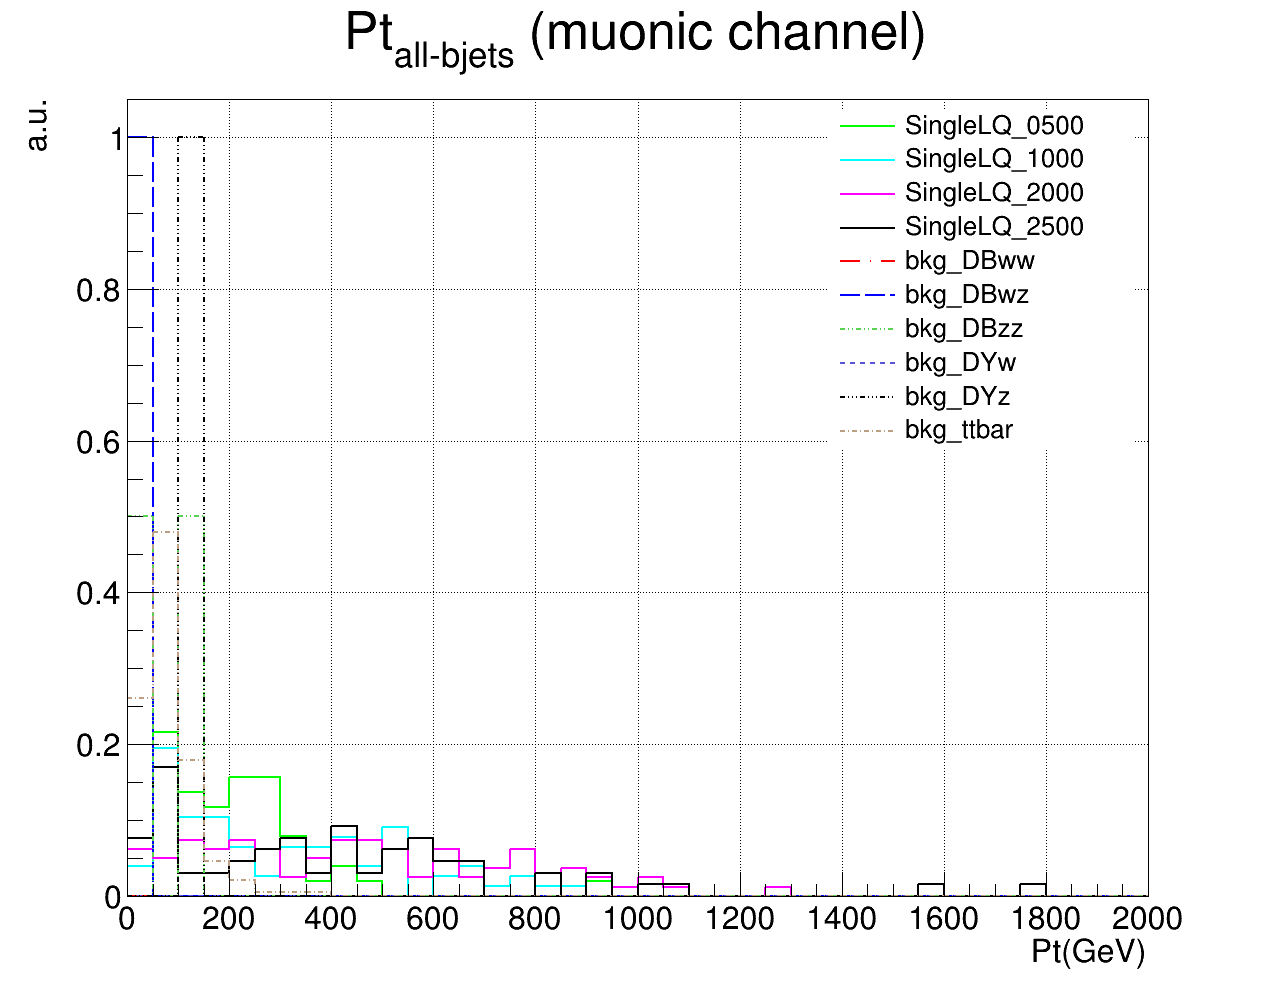

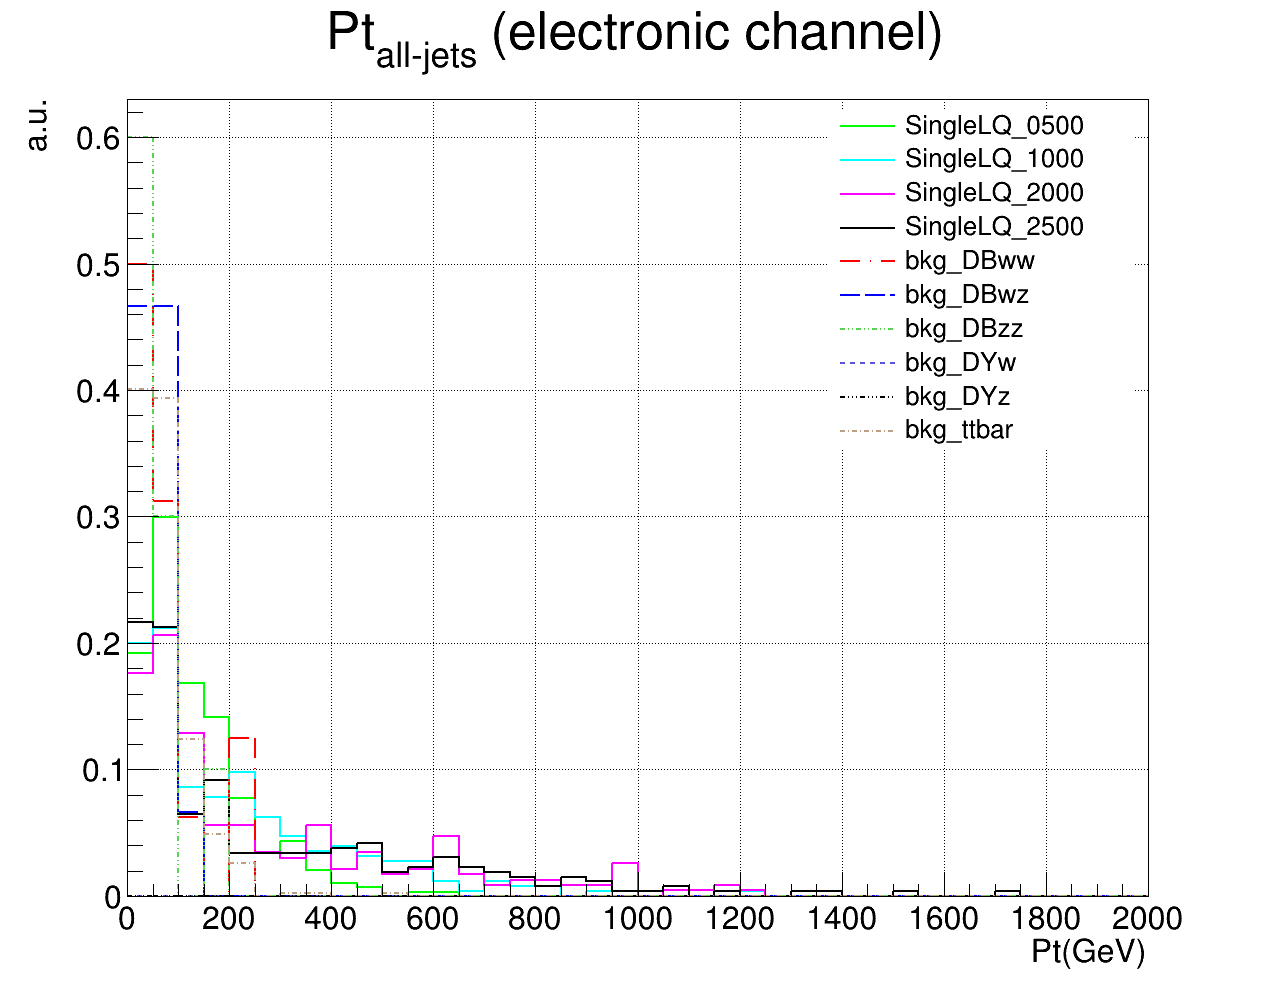

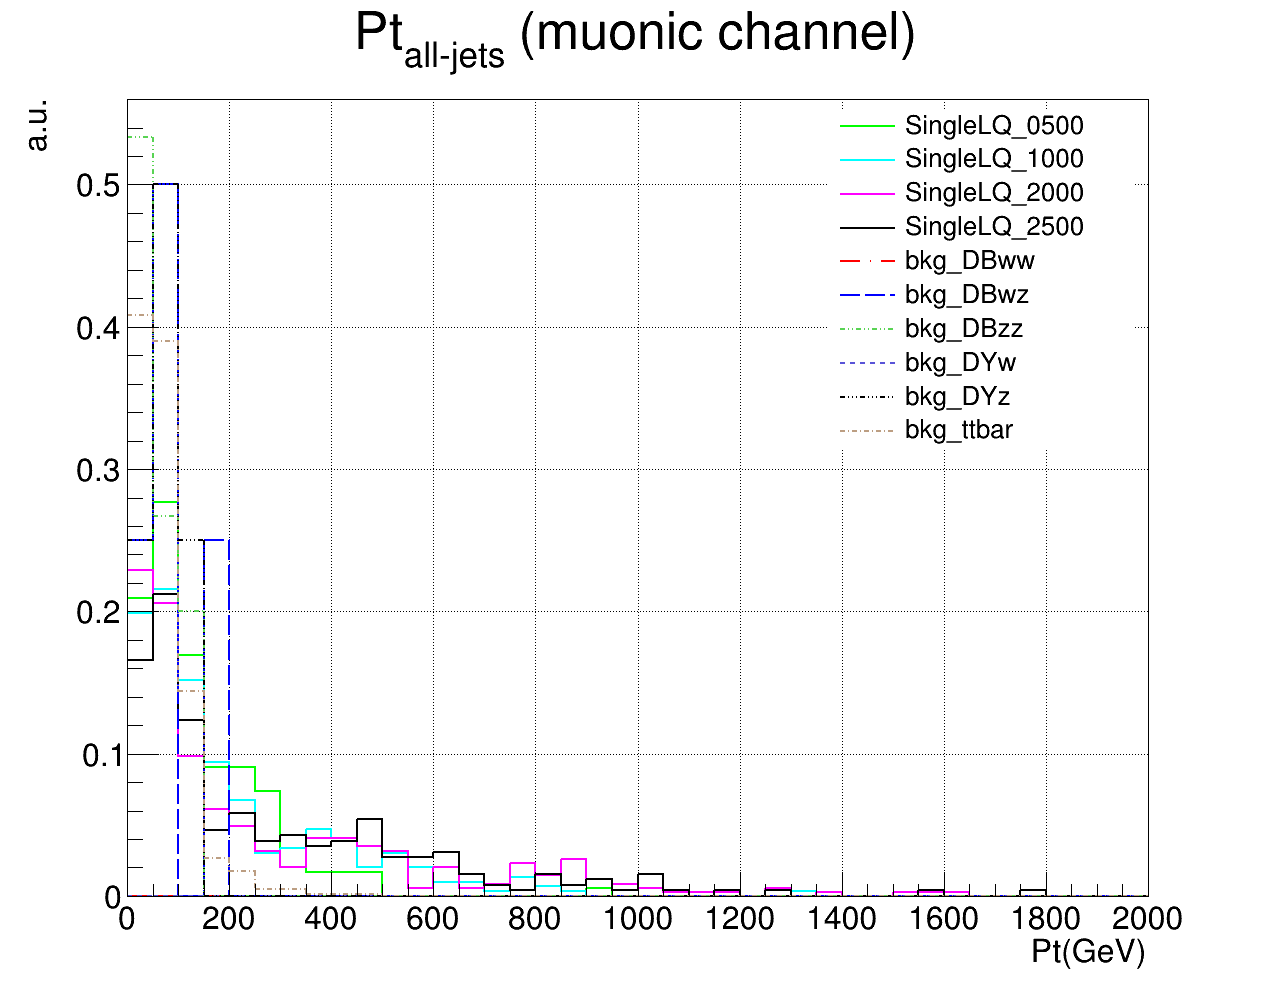

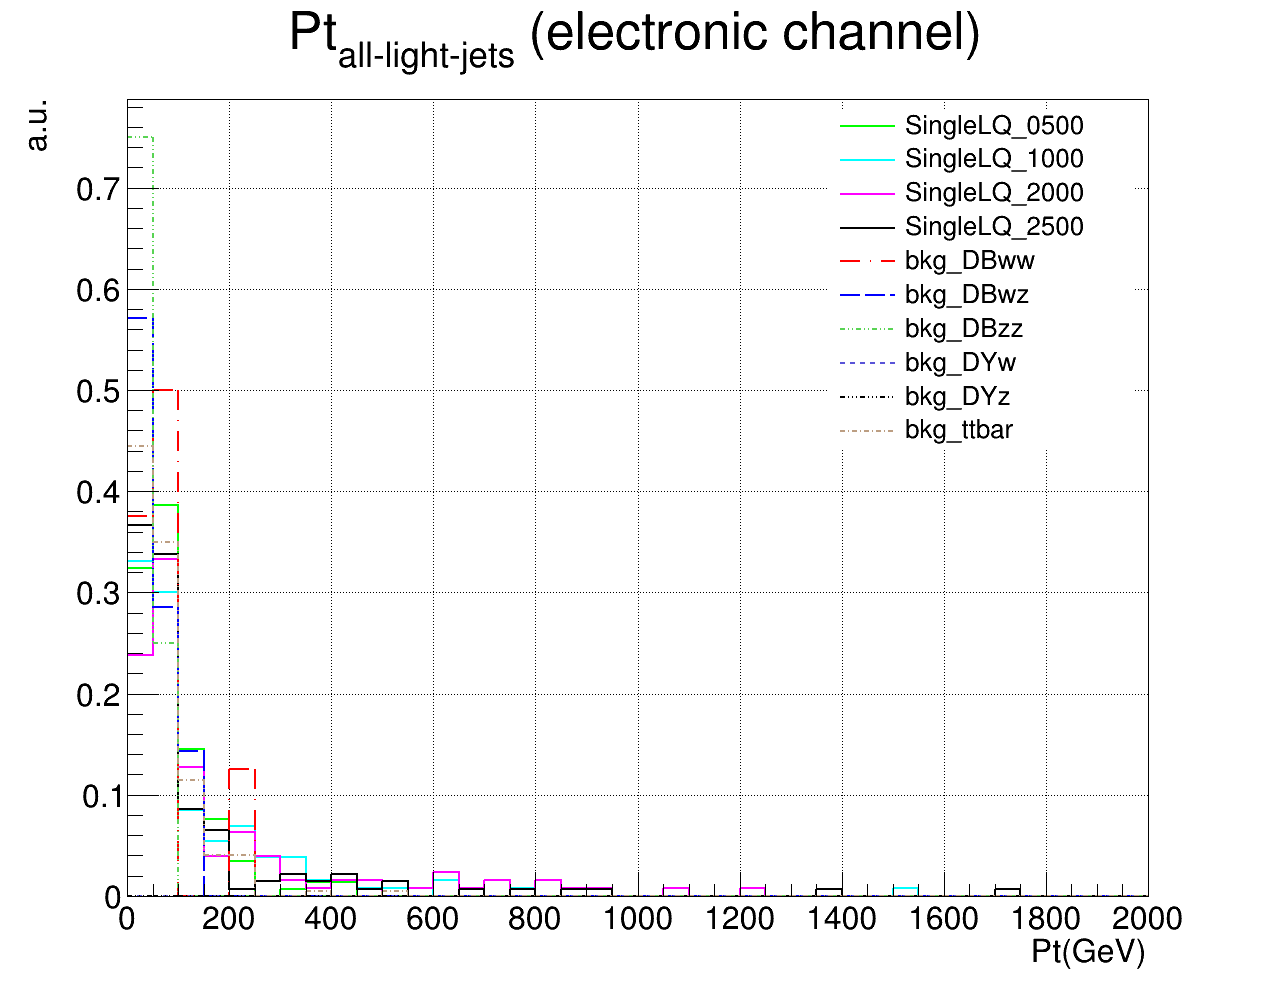

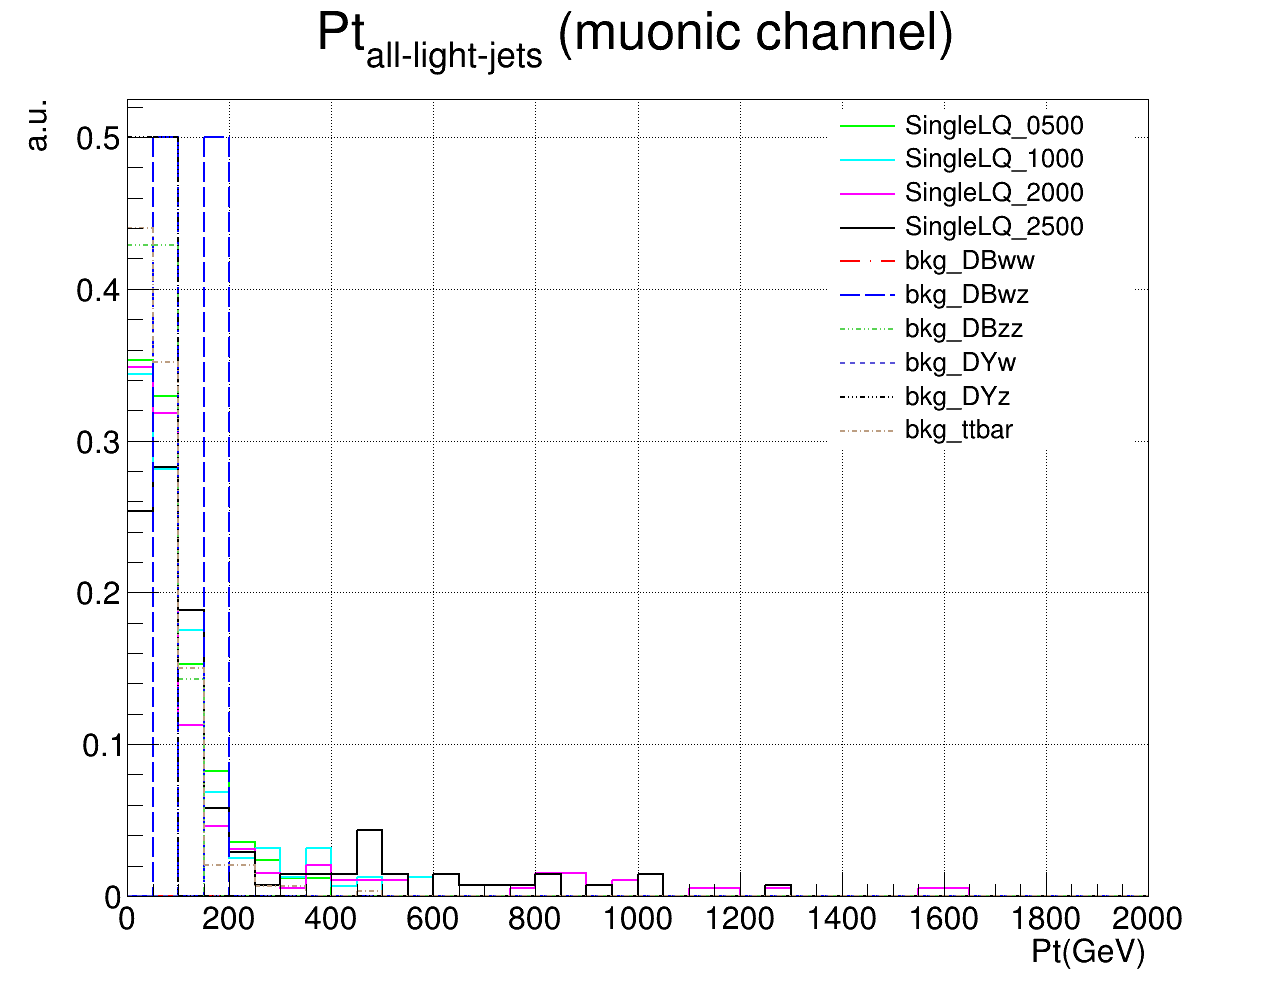

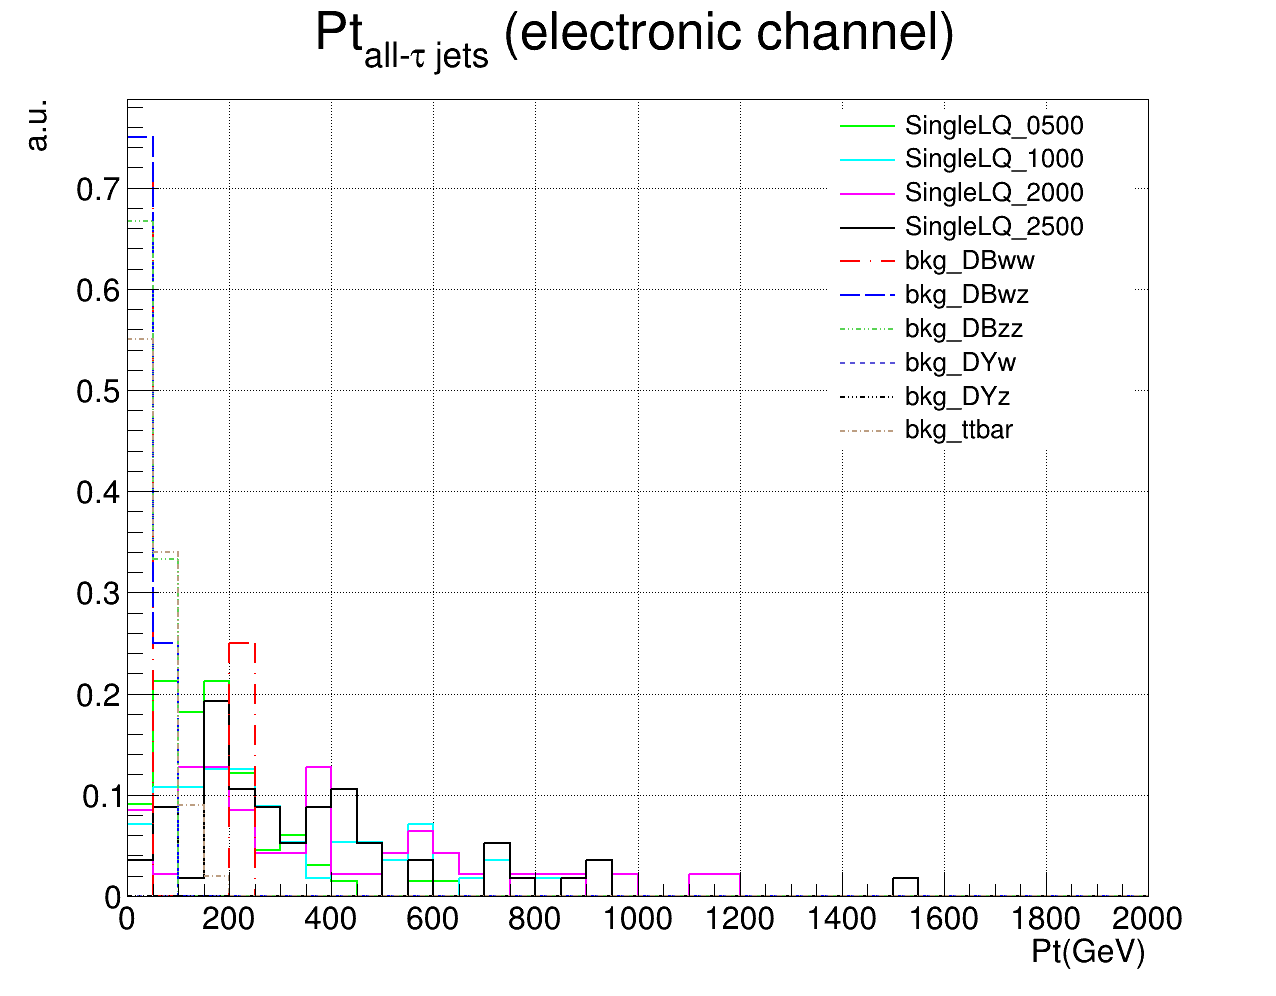

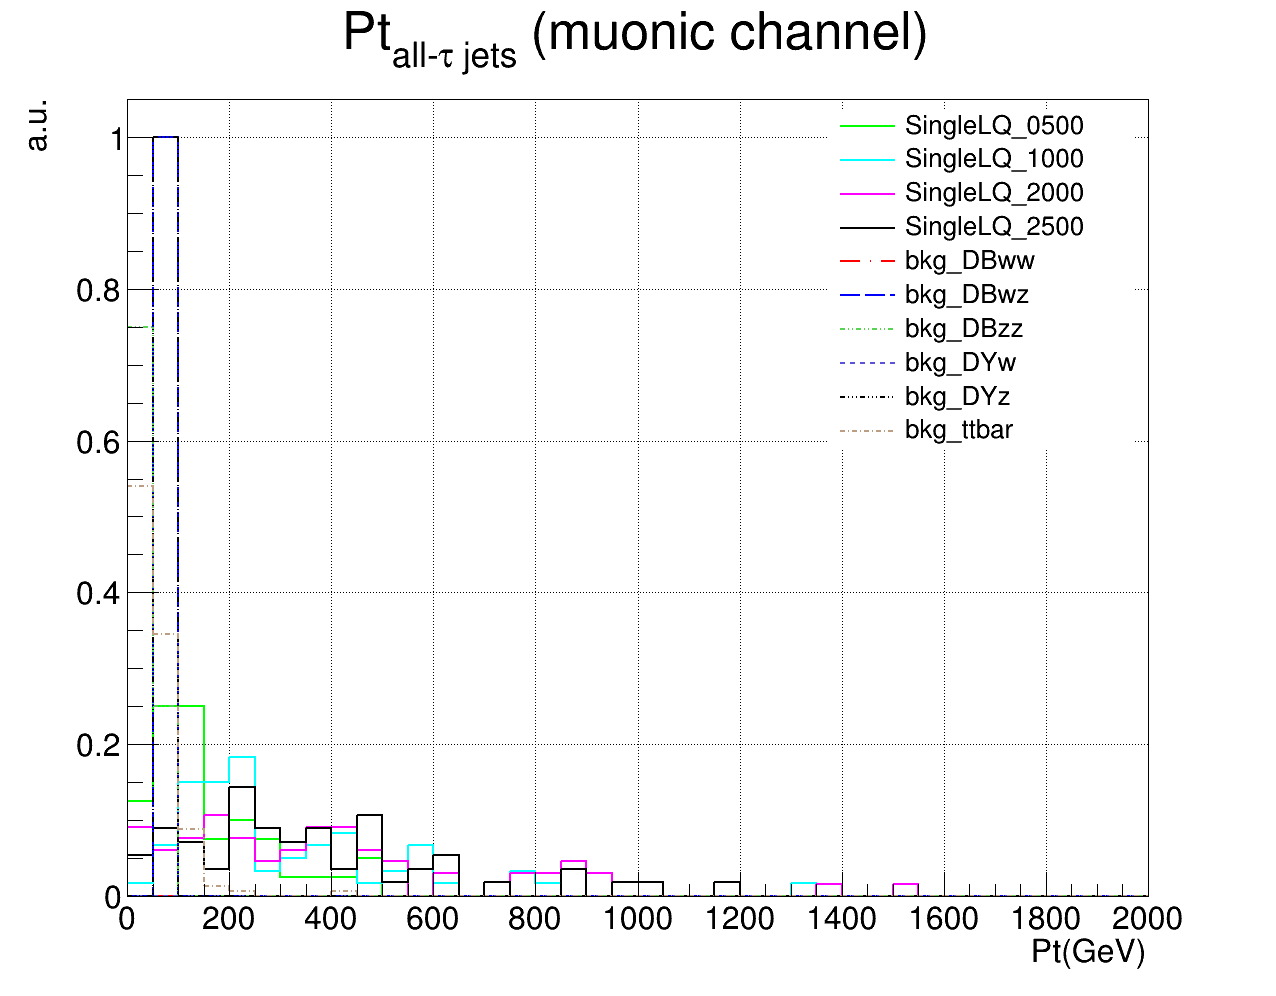

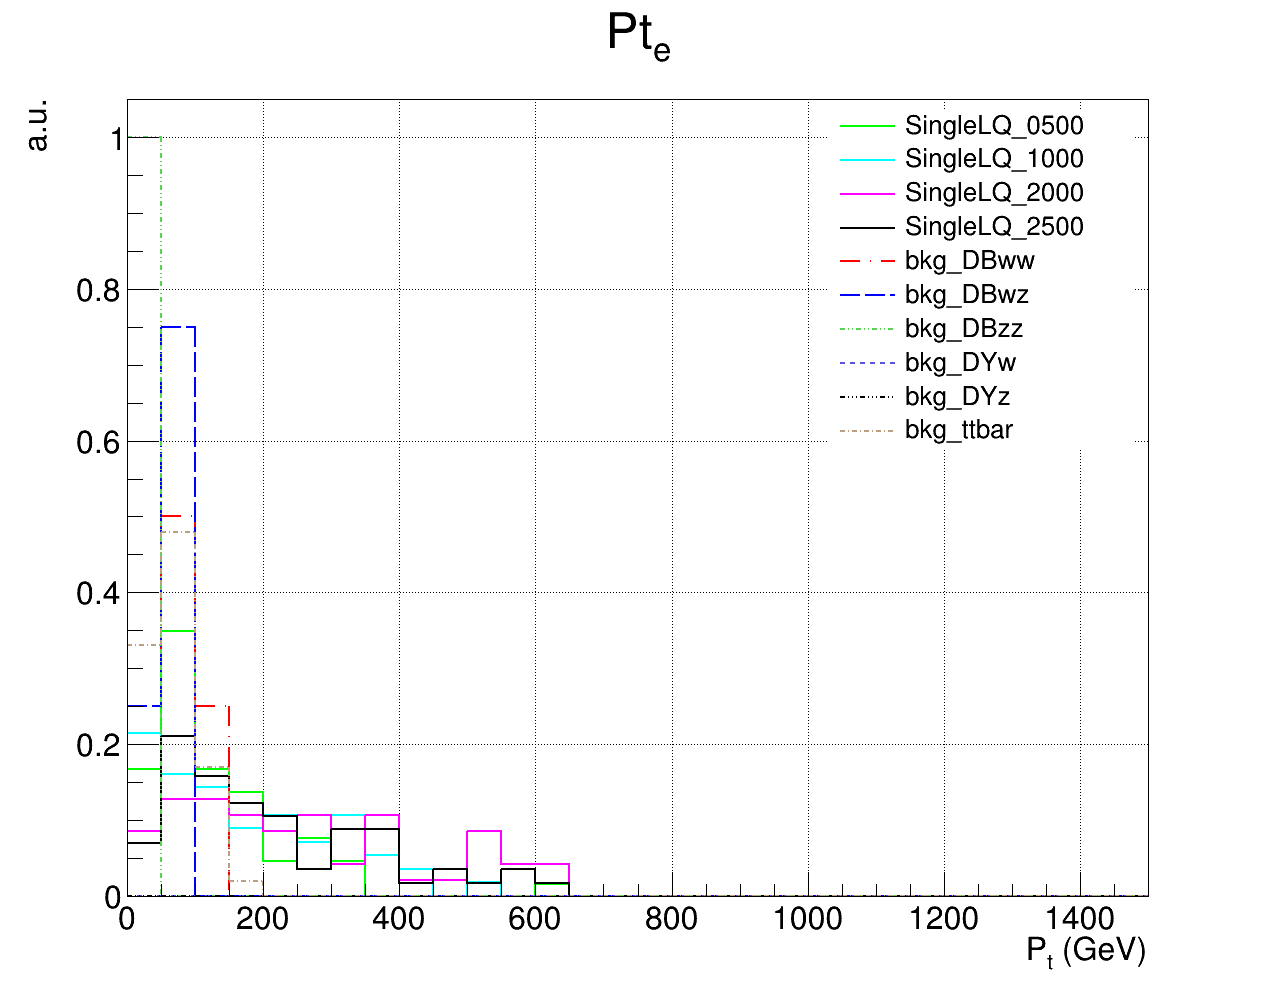

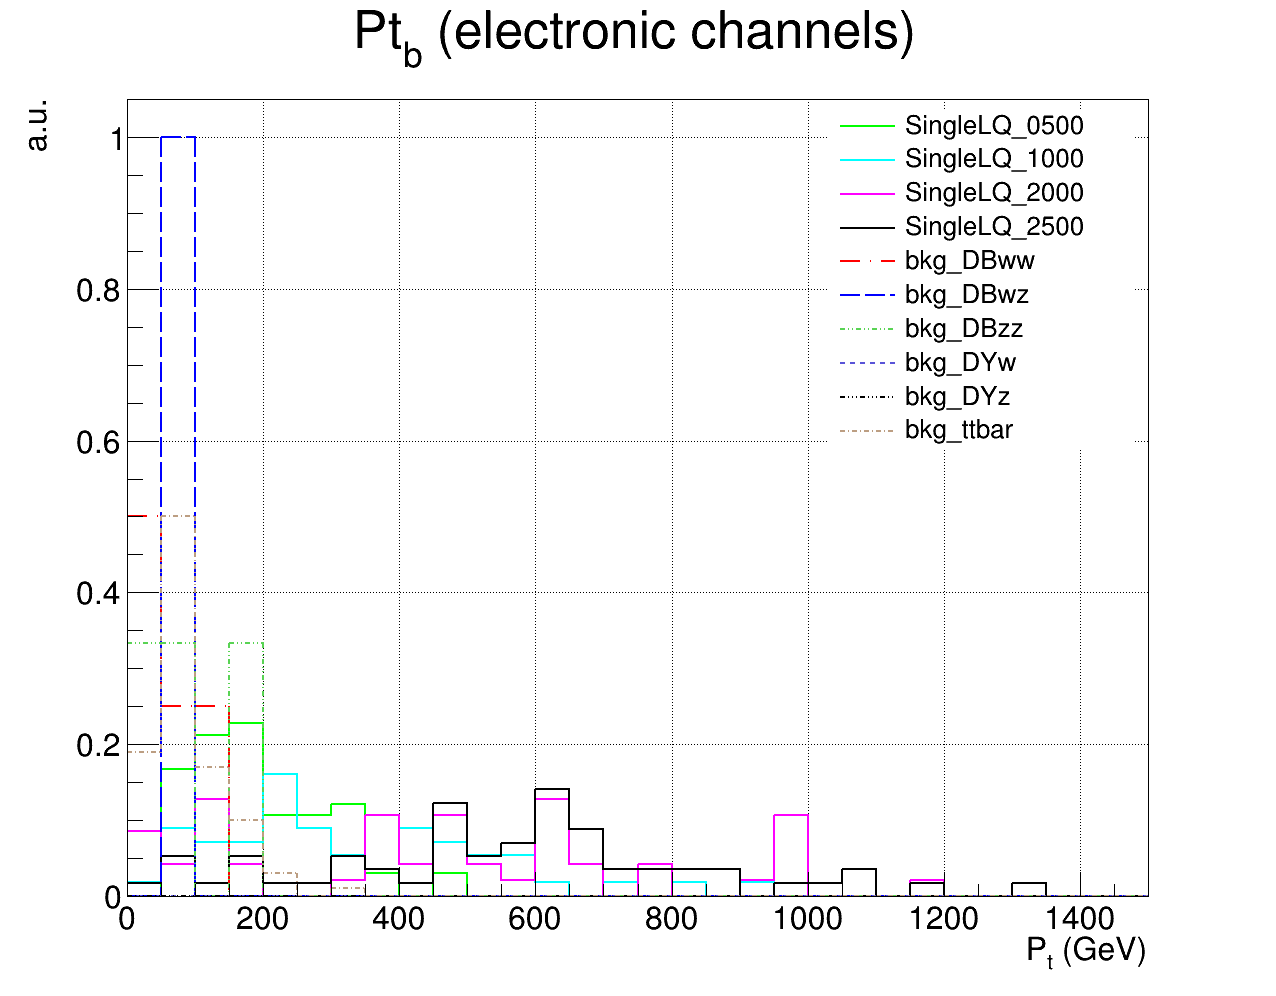

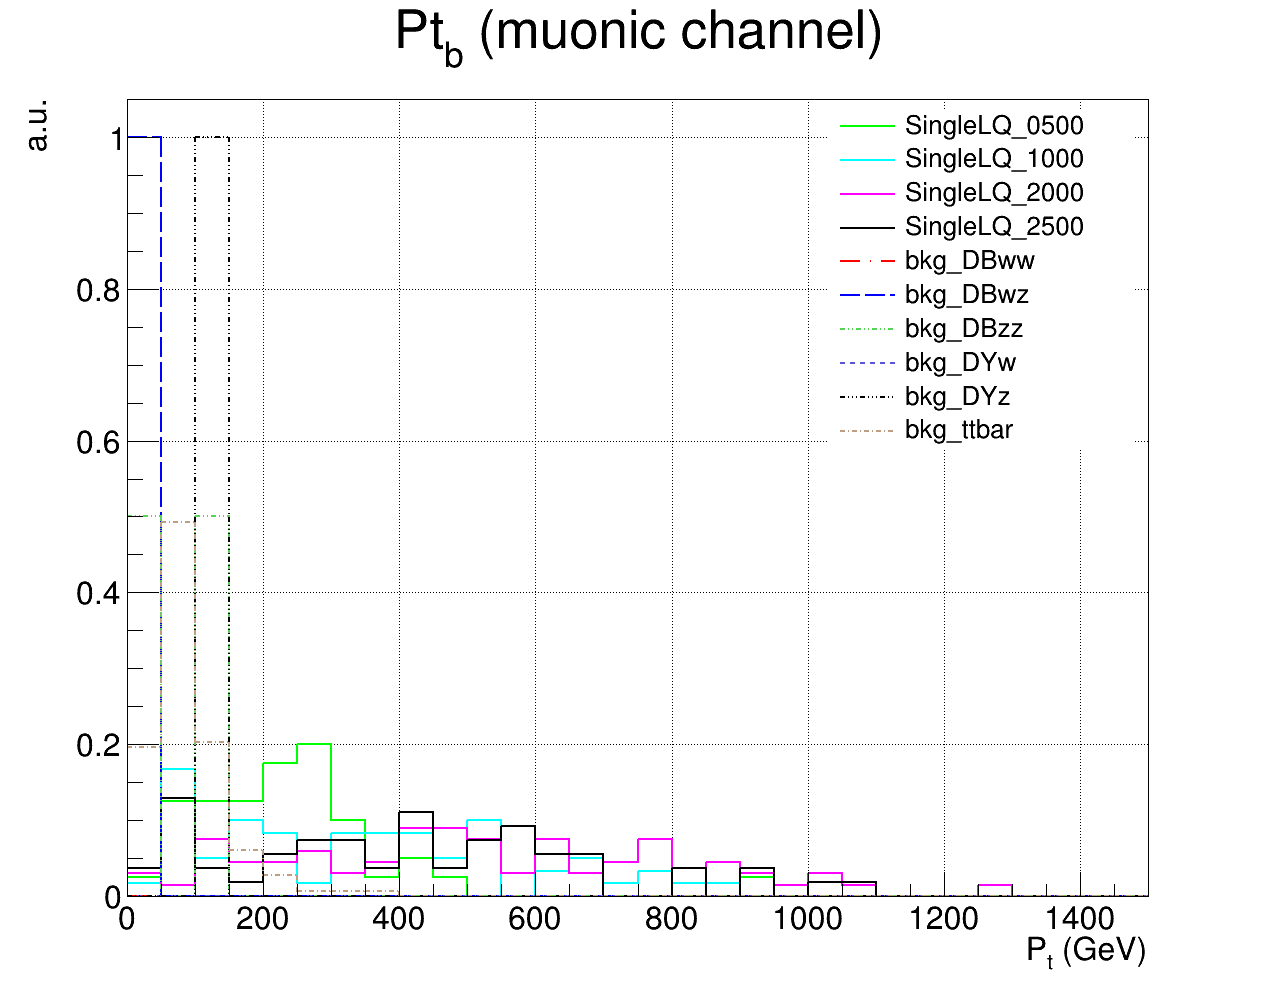

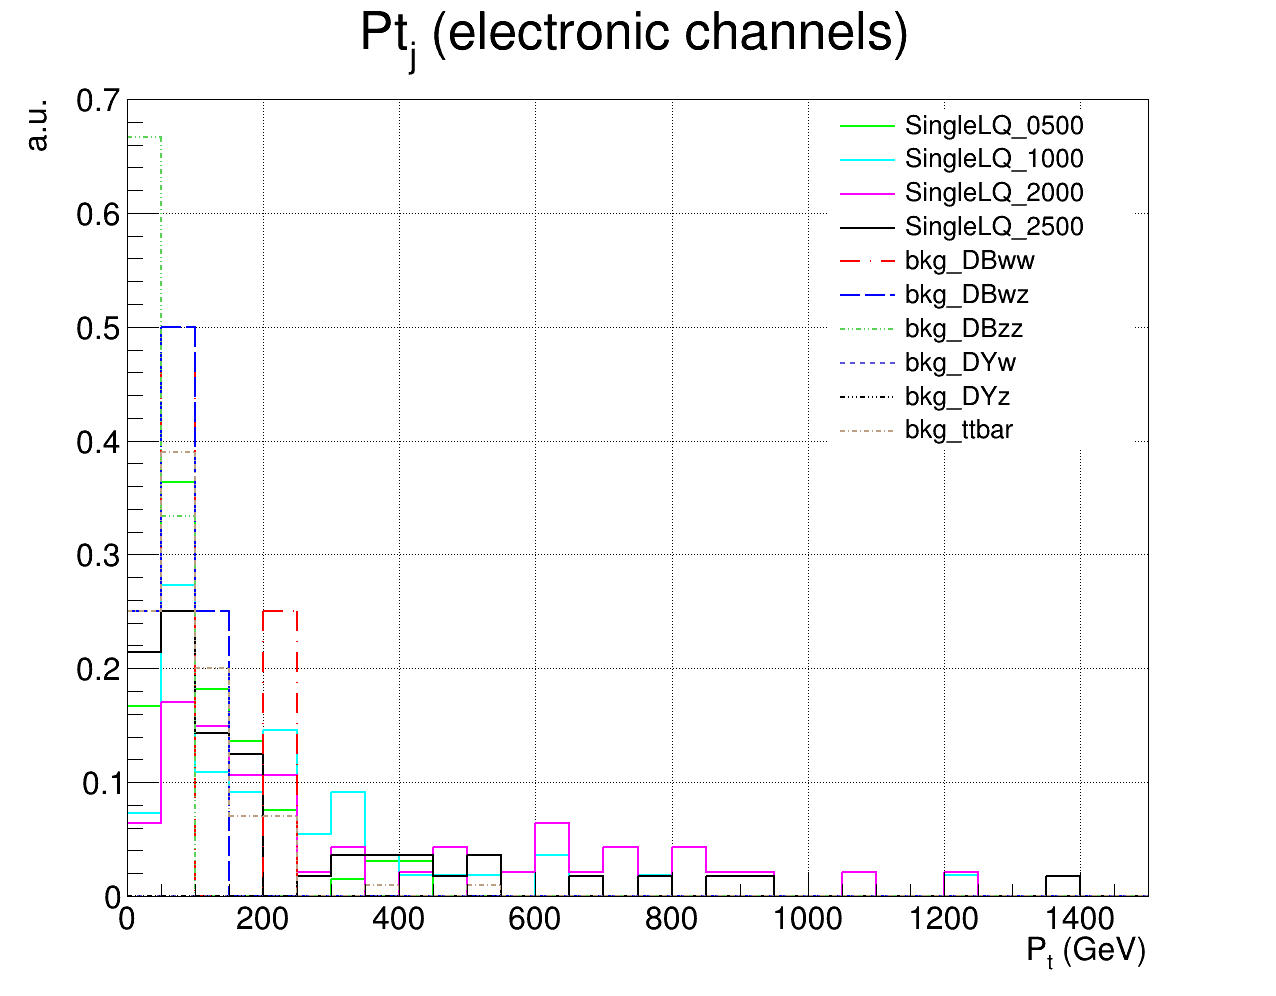

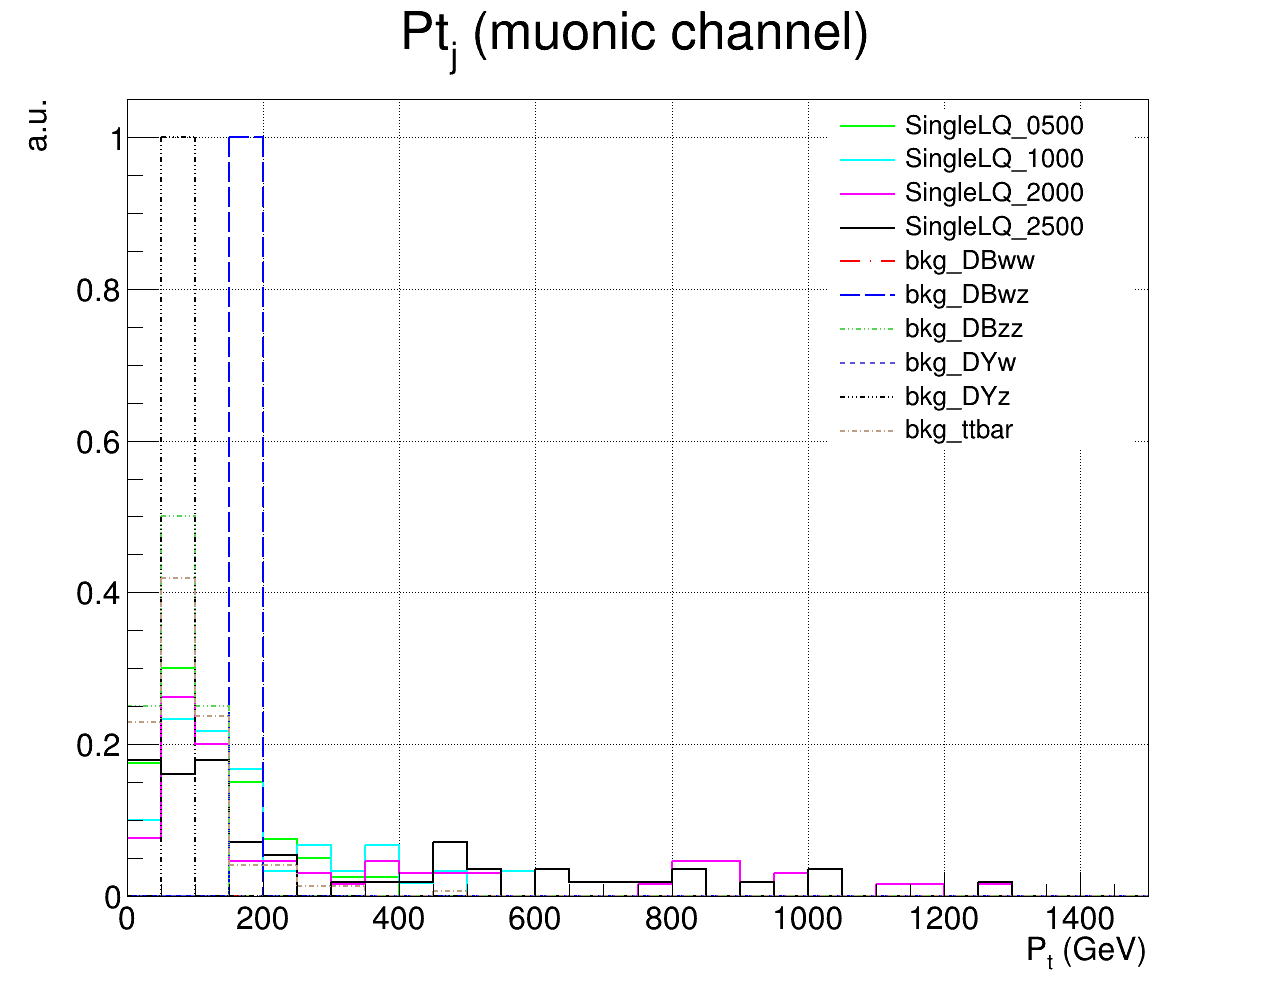

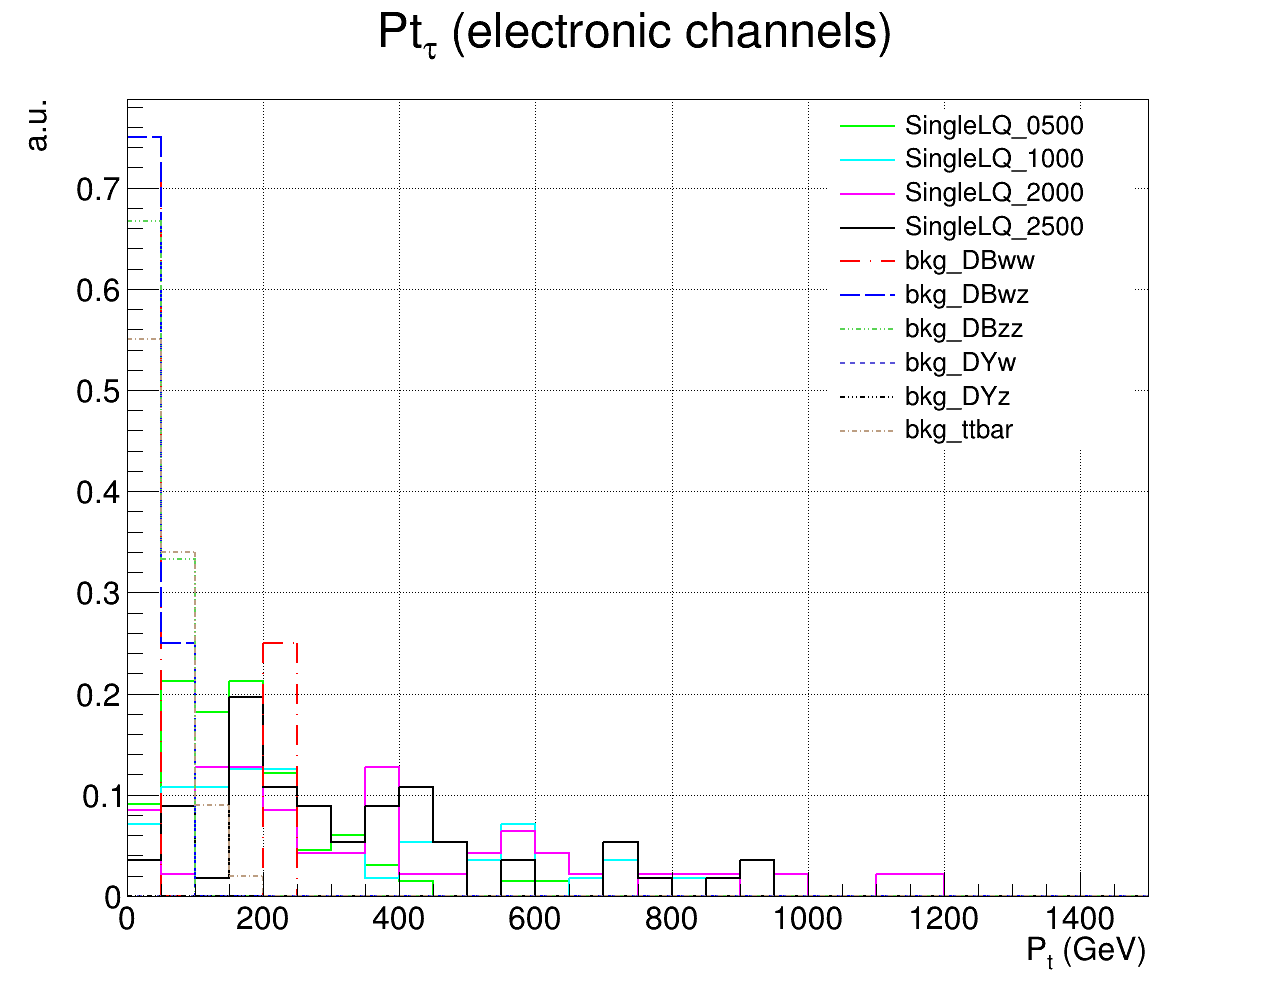

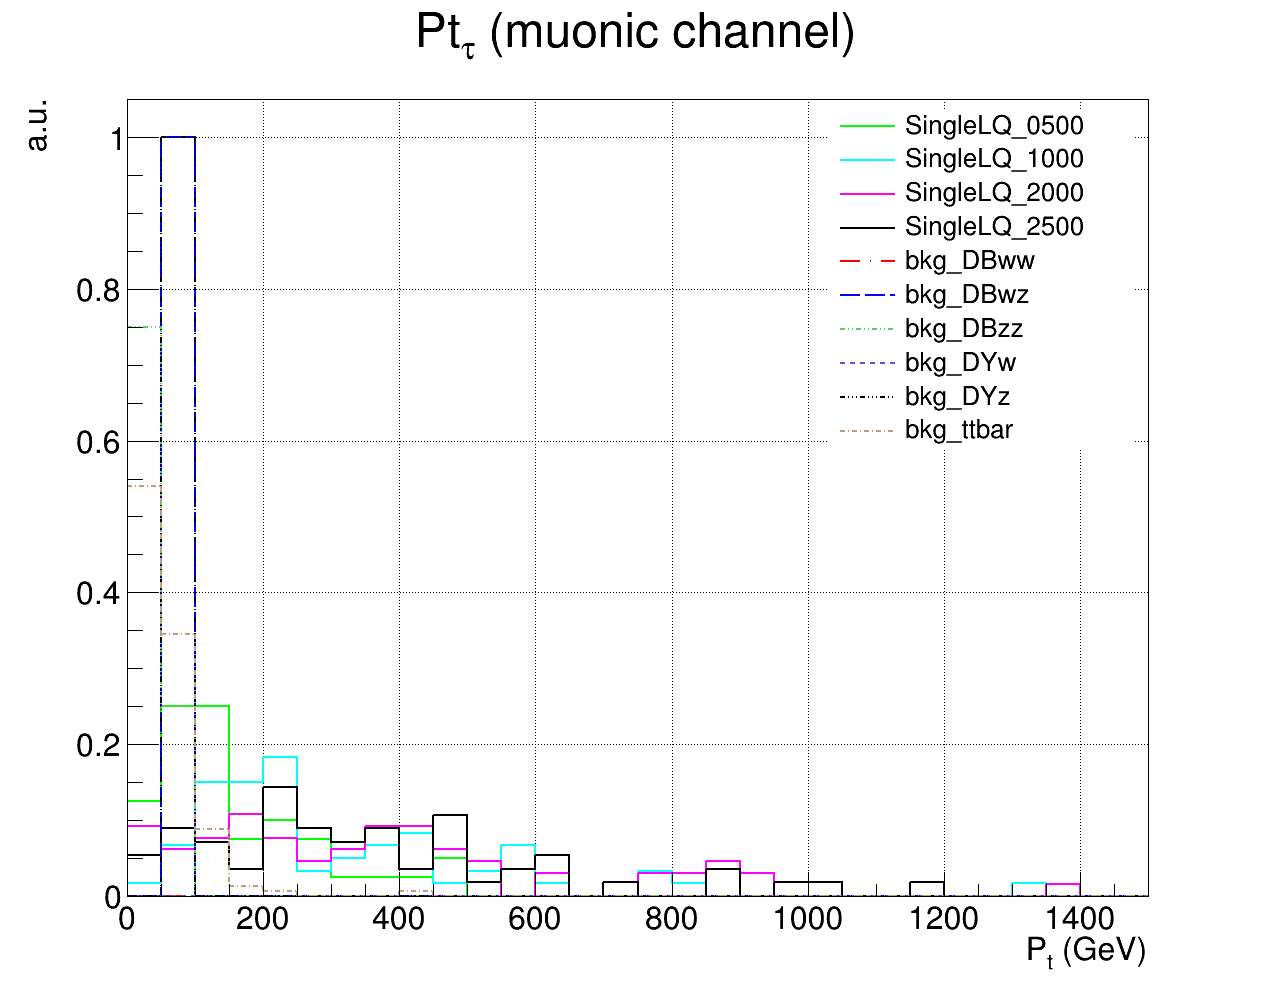

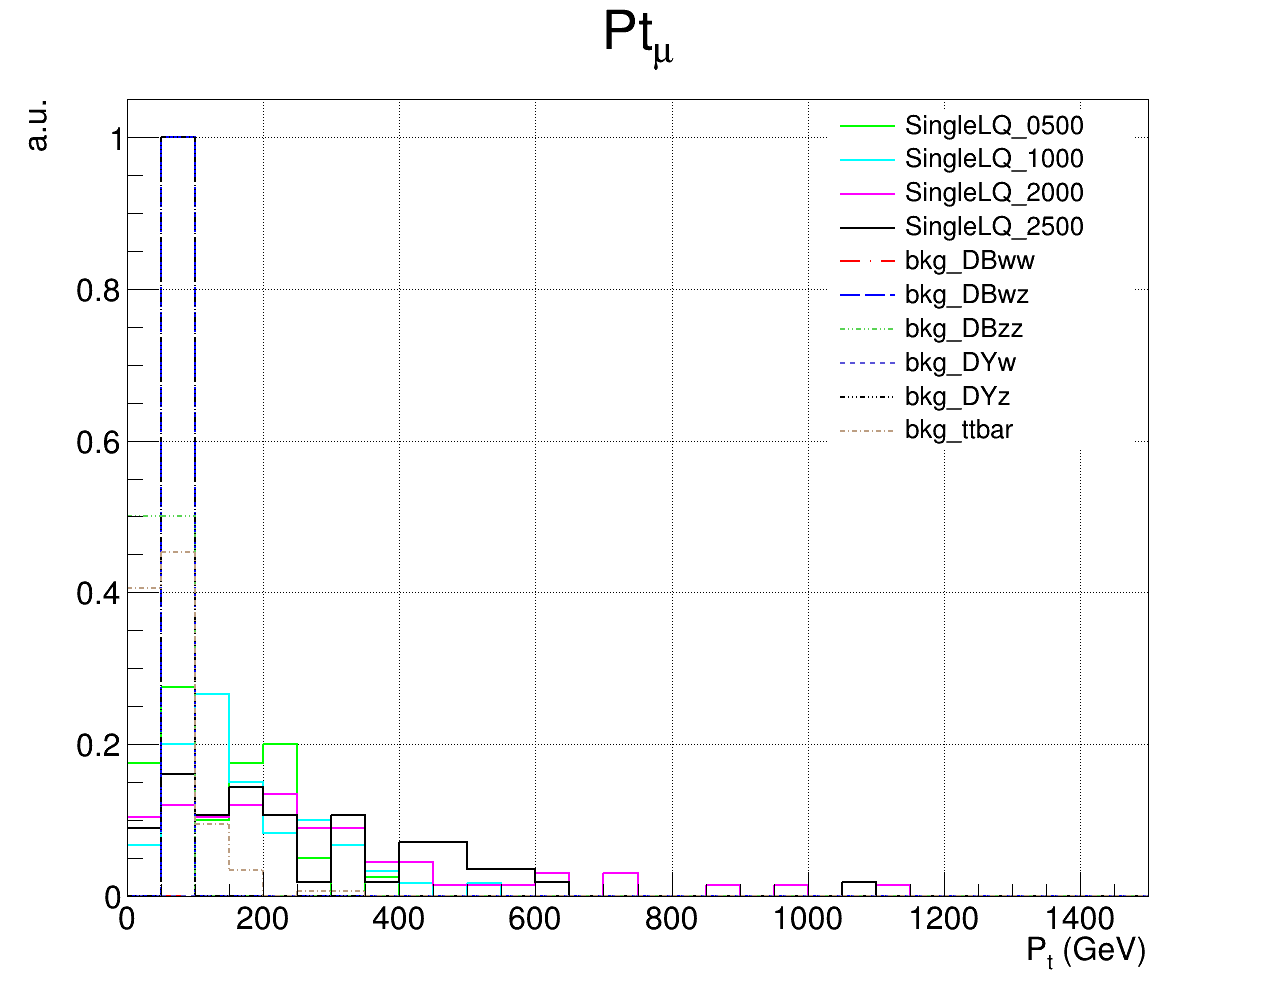

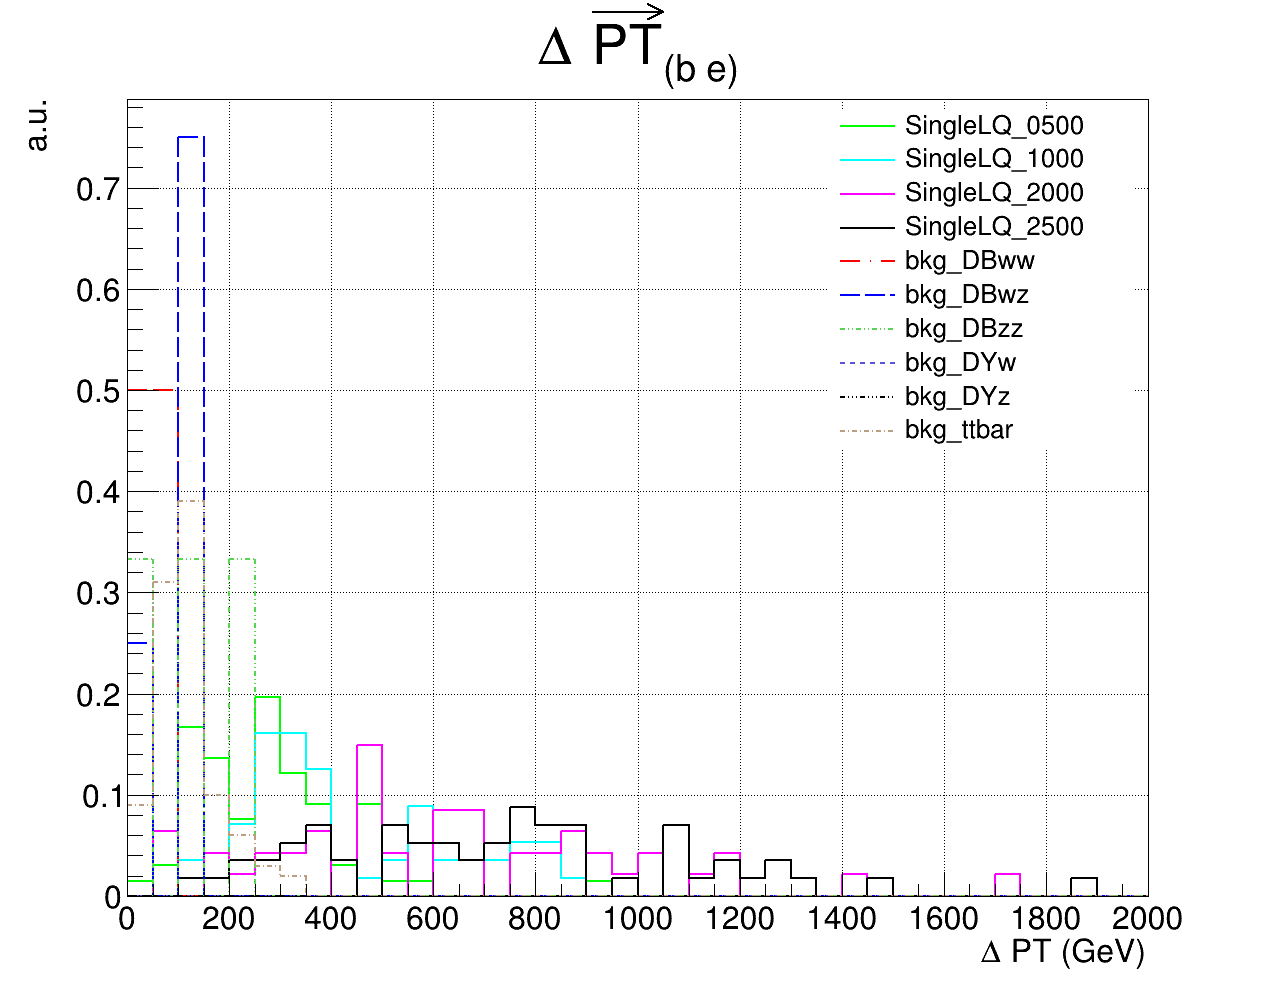

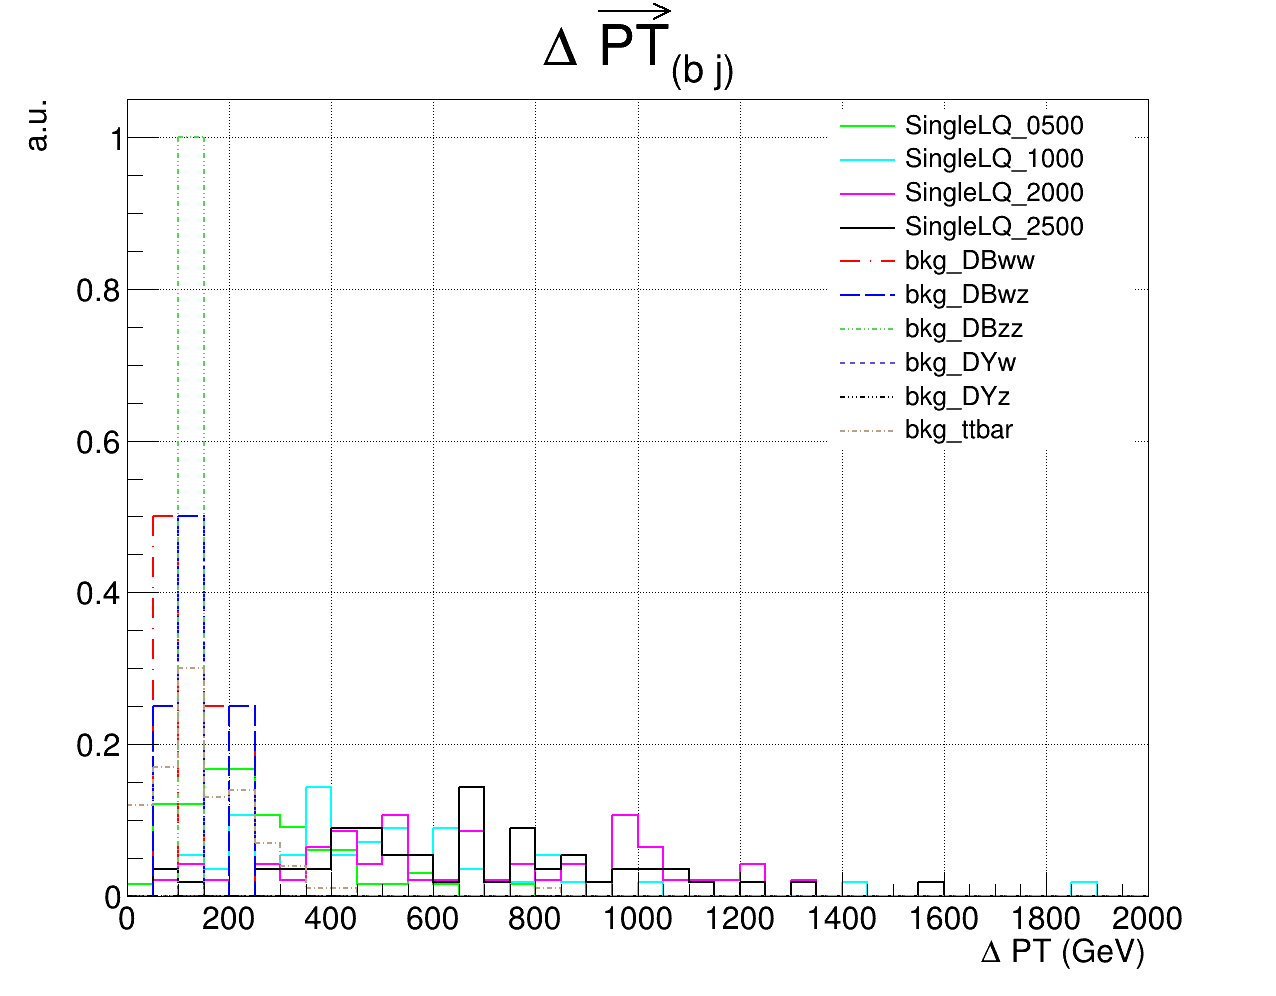

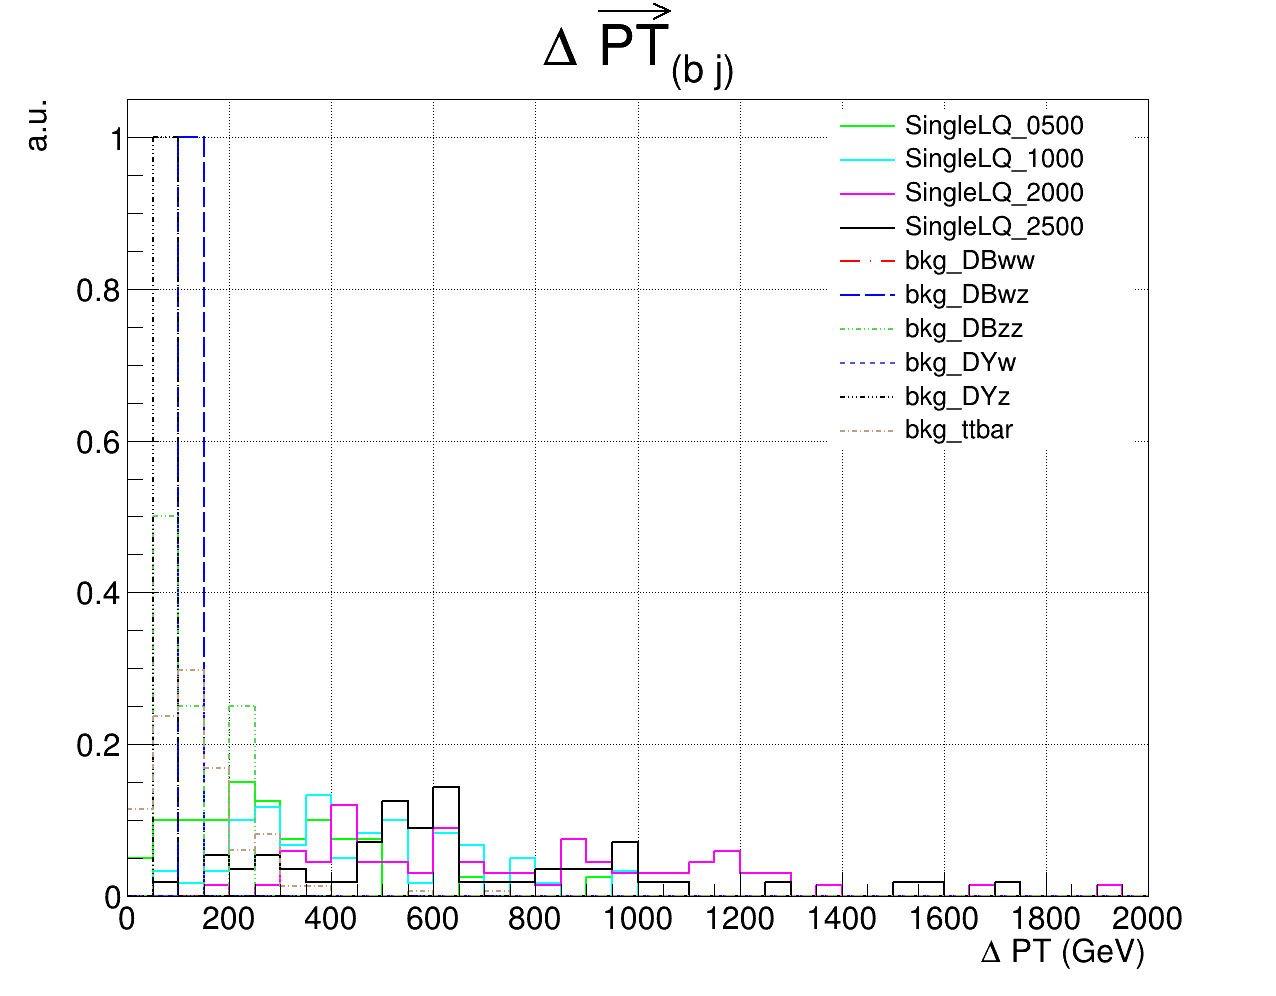

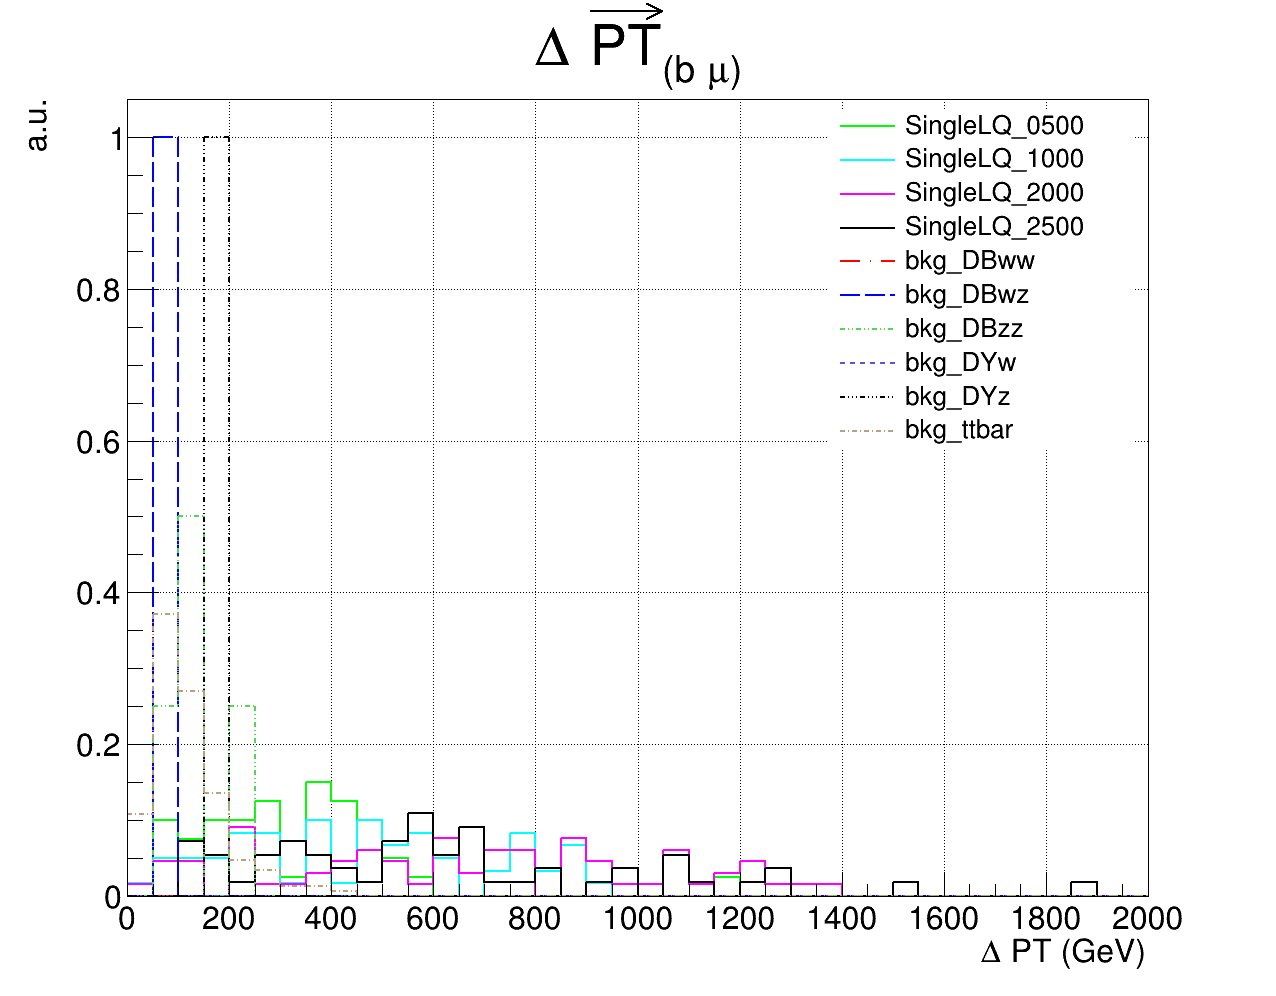

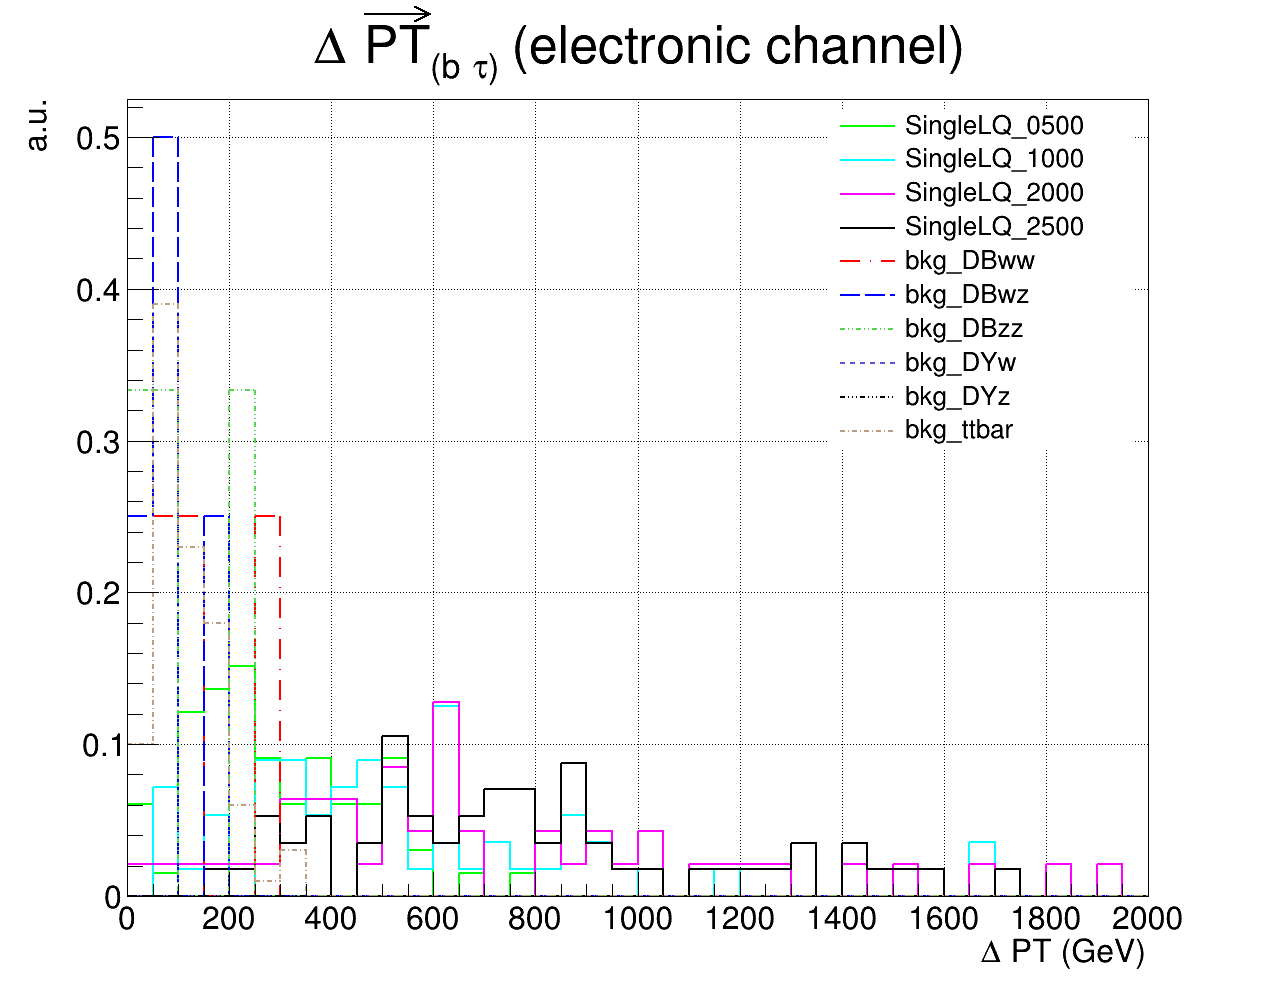

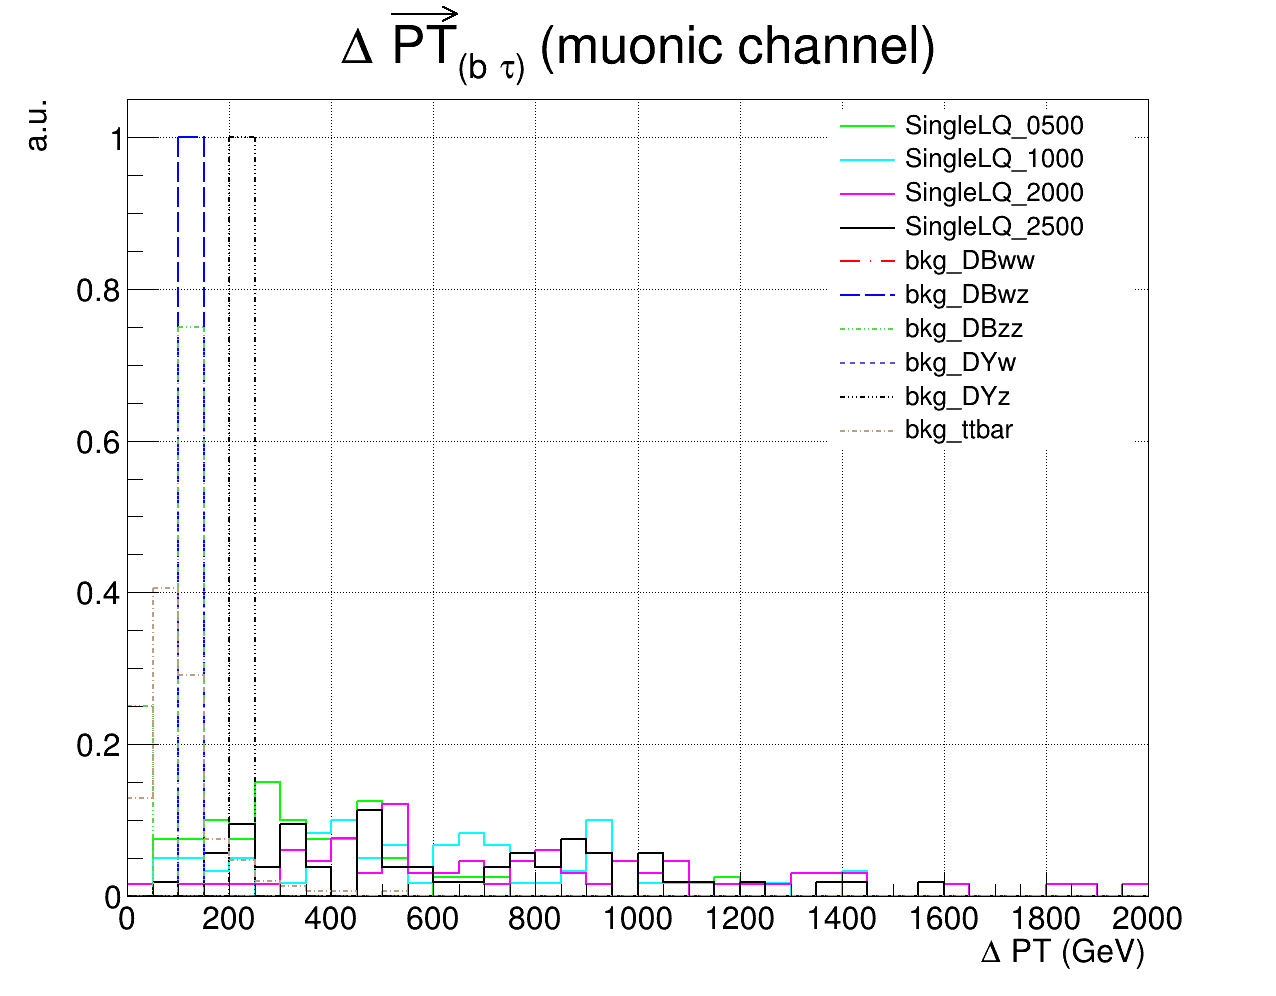

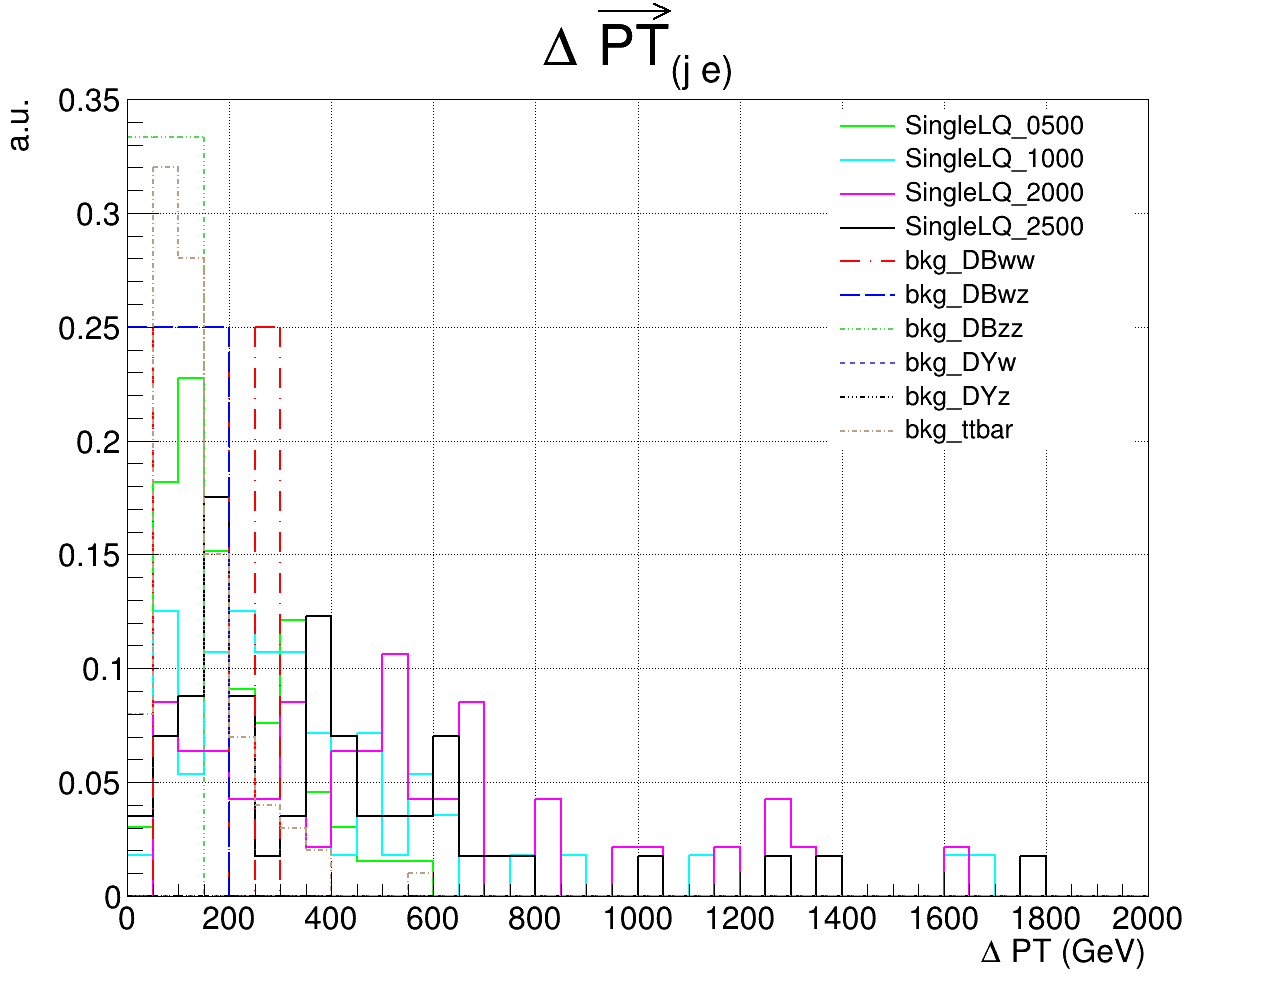

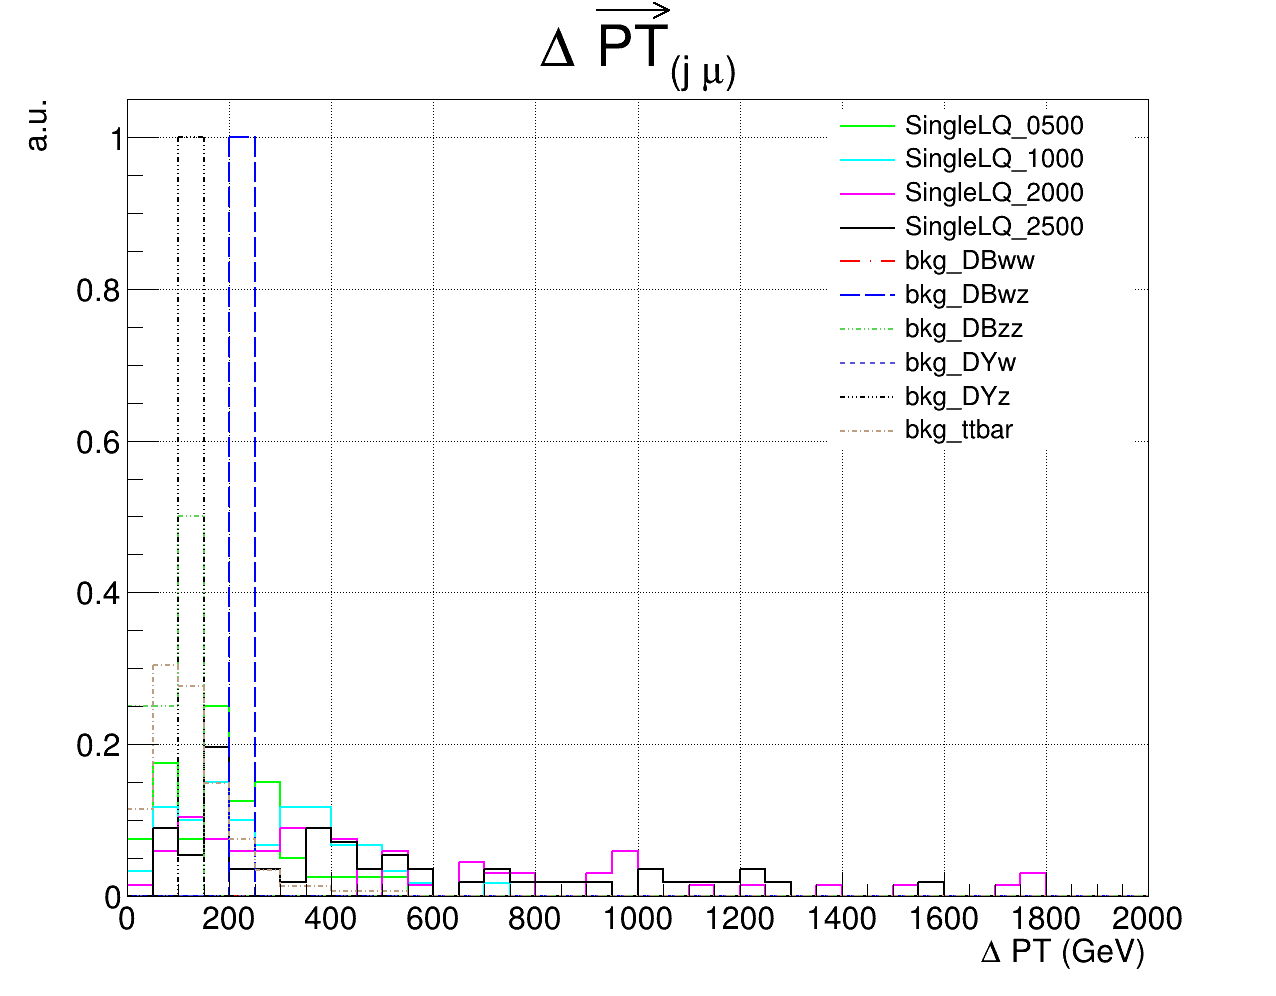

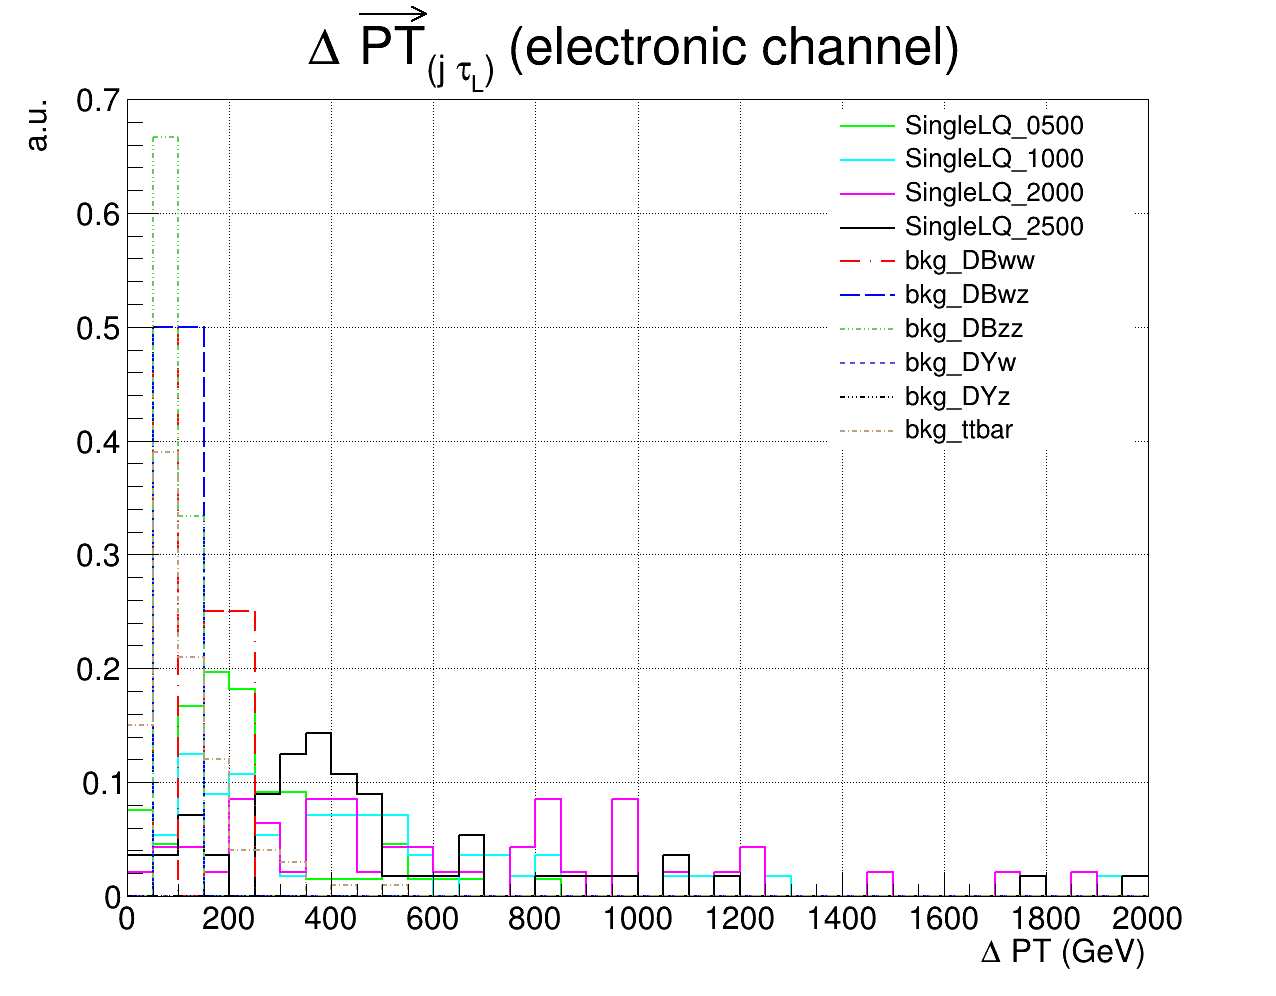

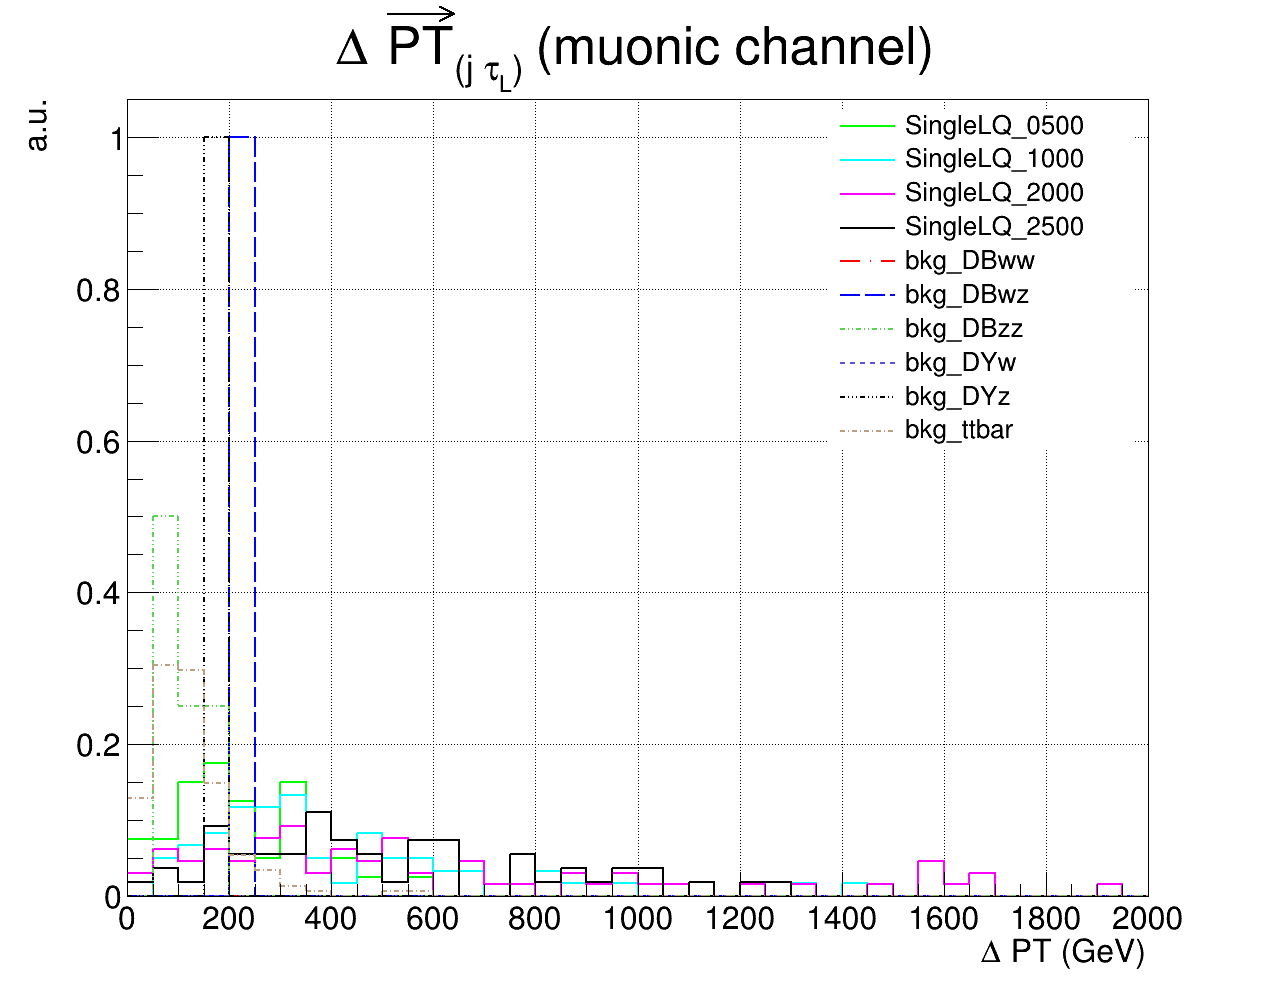

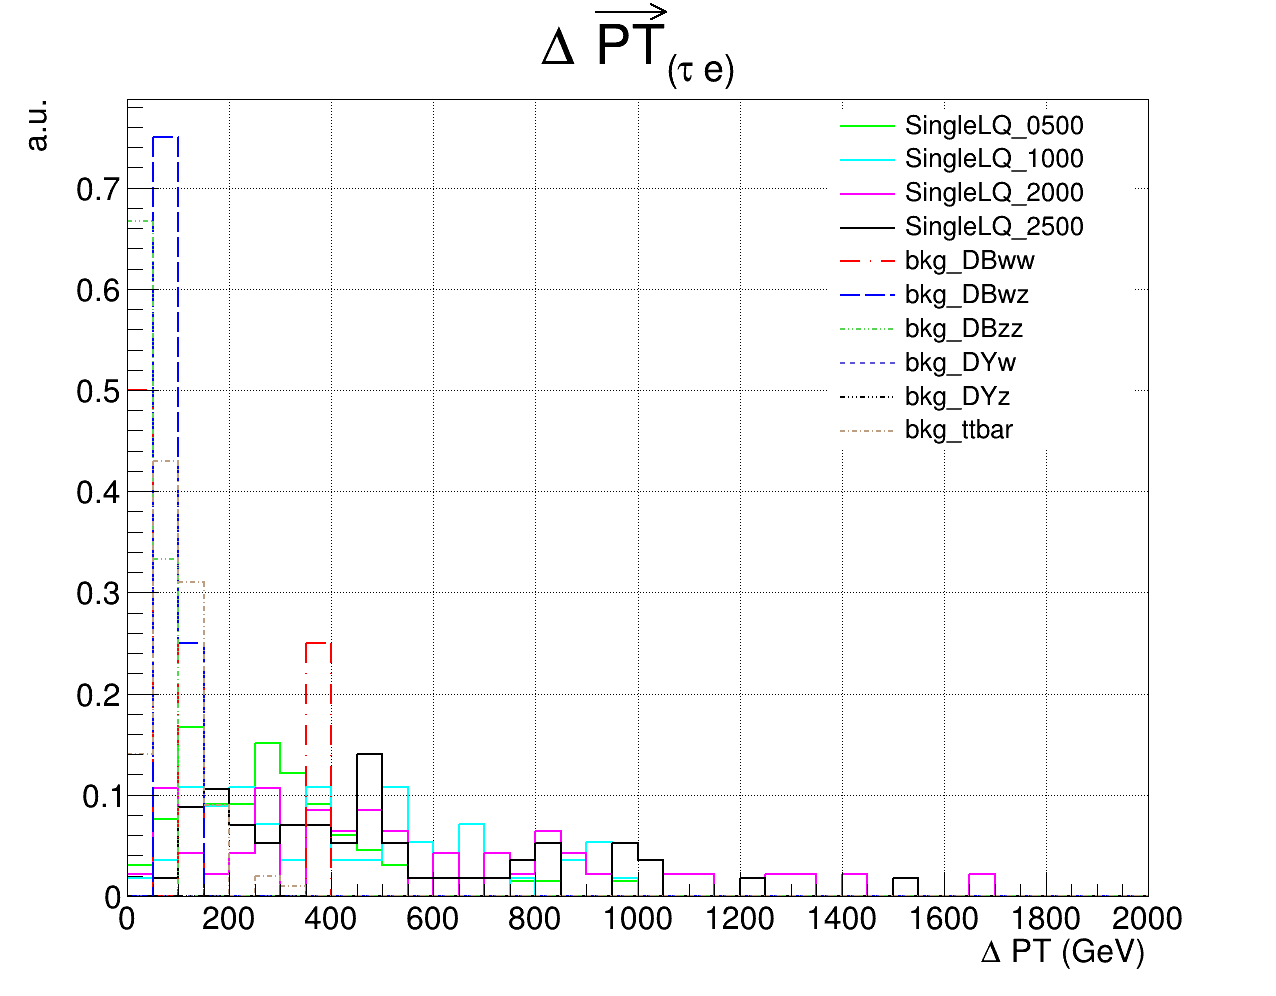

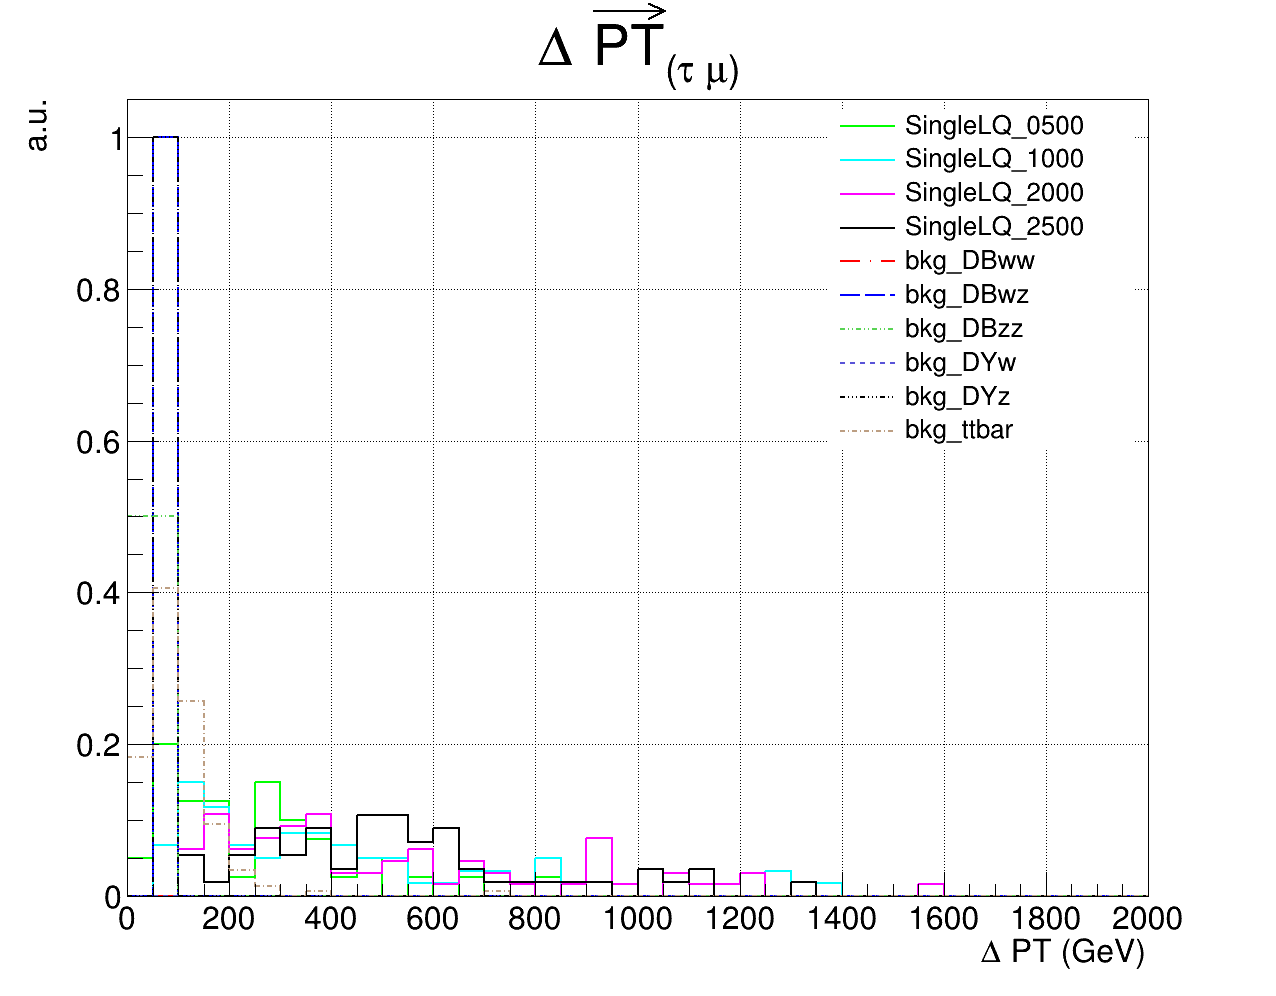

In [15]:
import os
from IPython.display import Image, display

listOfImageNames=[]
current_path = os.getcwd()
files=next(os.walk(current_path))[2]
for file in files:
    if ".png" in file:
        listOfImageNames+=[file]
listOfImageNames.sort()
for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [16]:
import os
import csv
current_path = os.getcwd()
files=next(os.walk(current_path))[2]
csv_files=[]
for file in files:
    if ".csv" in file:
        if not (file =="SimulationsPaths.csv"):
            csv_files+=[file]
data_dict={}

f=open("SingleLQ_0500_electrons.csv")
csvreader = csv.reader(f)

def read_csv(file):
    pass
type(csvreader)

FileNotFoundError: [Errno 2] No such file or directory: 'SingleLQ_500_electrons.csv'